In [1]:
# Sean Dougherty
# 15/5/2022
# ppc_agn_merger.py analysis notebook
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import scipy.stats.distributions as dist

from time import sleep
from tqdm import tqdm

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
gamma = 1.4
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # 0.7 for omega

import pickle

from scipy.stats import distributions
from scipy.interpolate import interp1d
import scipy
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'

0.0144

## PPC at different 2sigma cuts

In [ ]:
# # read in results
sig_cut = 10
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
rdf

In [ ]:
# # add an AGN count per pair column:
# rdf['mAGN'] = [0]*len(rdf)

# LX_AGN = 10**42
# rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
# rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

AGN_frac = {}
dif_cuts = {}
iso_count = {}
PDF_width = {}
sig_cuts = [10,3,2,1,0.5,0.25]
# sig_cuts = [1,0.5,0.25]


for sig_cut in sig_cuts:
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)

    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    PDF_width[str(sig_cut)] = np.zeros(len(bins))

    # split data frame up into each bin
    for i, rnge in enumerate(bins):
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]

        # calculating AGN per pair here
        AGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])) #* len(bin_df))
        PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 

    # get graphical data
    pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    dif_cuts[str(sig_cut)] = pAGN_fracs
    iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

In [2]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [ ]:
# # well this didn't work bc no data but it should've
# # get graphical data
# pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [ ]:
# # plot results:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# ax.scatter(kpc_meds, pAGN_fracs)
# ax.set_xlim(0,100)
# plt.show()

In [ ]:
# PDF_width

In [ ]:
# dif_cuts[str(sig_cut)] = pAGN_fracs
# iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())
# marker = ['^','o','X','s','*','d'] * 8
# markers = np.transpose(np.reshape(marker, (8,3)))
kpcs = np.zeros((3,8))
for i in range(0,len(kpcs)):
    kpc_medu = [km+i for km in kpc_meds]
    kpcs[i] = kpc_medu
dif_cut = np.array([dif_cuts[key] for key in dif_cuts])
PDF_wid = np.array([PDF_width[key] for key in PDF_width])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
# ax.scatter(kpcs, dif_cut, s=100, c=PDF_wid)#, marker=markers)
# ax.set_ylim(0,0.12)
# ax.set_xlabel('kpc')
# ax.set_ylabel('AGN fraction')

# marker = ['^','o','X','s','*','d'] * 6
for i, key in enumerate(dif_cuts):
    kpc_medu = [km+i for km in kpc_meds]
    ax.scatter(kpc_medu, dif_cuts[key], s=100, c=PDF_width[key], marker=marker[i], edgecolors='black')
    ax.scatter(-100,-100, marker=marker[i], s=100, edgecolors='black', facecolor='white', label='2$\sigma$ = '+key)
    # ax.set_title('AGN fractions with different $\sigma$ criteria', fontsize=20)
    ax.set_xlim(0,105)
    ax.set_ylim(0,0.1)
    ax.set_xlabel('kpc', fontsize=15)
    ax.set_ylabel('AGN fraction', fontsize=15)
    ax.legend(fontsize=15)
    # cbar = fig.colorbar(pdat, ax=ax[0], vmax=2, vmin=0)
    # cbar.set_label('mean $2\sigma$', fontsize=15)
    # ax[1].bar(float(key), iso_count[key], label='2$\sigma$ = '+key)
    # ax[1].set_title('$N_{pairs} / N_{iso}$')

ax.set_xticks(np.arange(0,100,20))
ax.set_xticklabels(np.arange(0,100,20),fontsize=15)
ax.set_yticks(np.arange(0,0.11,0.02))
ax.set_yticklabels(np.arange(0,0.11,0.02),fontsize=15)

plt.savefig(PATH+'AP_PP_comparing_sigma.png')

plt.show()

## next plot the difference in AGN fraction at different pair_prob cuts


In [ ]:
prob_dat = {}
iso_count = {}
pair_count = {}

In [ ]:
# read in results
sig_cut = 0.25
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

In [ ]:
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [ ]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# AGN_frac = {}

probc = [0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]

AGN_frac = {}
prob_dat = {}
iso_count = {}
pair_count = {}
npairs = {}

# sig_cuts = [10,3,2,1,0.5,0.25]
sig_cuts = [0.5,0.25]

for sig_cut in sig_cuts:
    print(sig_cut)
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)
    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    AGN_frac[str(sig_cut)] = np.zeros((len(probc), n_bins))
    npairs[str(sig_cut)] = np.zeros((len(probc),1))

    for i, p in enumerate(probc):
        rdf2 = rdf.loc[ (rdf['pair_prob'] > p) & (rdf['prime_M'] > 10) & (rdf['field'] != 'COS') & (rdf['field'] != 'COSMOS') ]
        npairs[str(sig_cut)][i] = len(rdf2)

        # split data frame up into each bin
        for j, rnge in enumerate(bins):
            # get bin ranges from bins dictionary entries
            info = bins[rnge].split('-')
            low = float(info[0])
            high = float(info[1])

            # sort into bins
            bin_df = rdf2[ (rdf2['kpc_sep'] > low) & (rdf2['kpc_sep'] <= high) ]

            # calculating AGN per pair here
            AGN_frac[str(sig_cut)][i,j] = (sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (sum(bin_df['pair_prob'])))# * len(bin_df)))

    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    prob_dat = AGN_frac
    iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
    pair_count = npairs

In [ ]:
bin_df

In [ ]:
# # get graphical data
# # pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# prob_dat[str(sig_cut)] = AGN_frac
# iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
# pair_count[str(sig_cut)] = npairs

In [ ]:
# kpc_meds

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharey=True)
fig.subplots_adjust(wspace=0)

for k, key in enumerate(prob_dat):
    for i in range(0,len(prob_dat[key])):
        kpc_medu = [km+(i*1) for km in kpc_meds]
        ax[k].scatter(kpc_medu, prob_dat[key][i], label='$\mathcal{N}_z$ < '+str(probc[i]), s=50)
    #ax[k].set_ylim(0,8e-5)
    ax[k].set_ylim(0,0.12)
    ax[k].set_xlim(-5,105)
    ax[k].set_title('2$\sigma$ < '+key, fontsize=20)
    ax[k].legend(fontsize=15, ncol=2, loc='lower left')
    
ax[0].set_xticks(np.arange(0,105,20))
ax[0].set_xticklabels(np.arange(0,105,20),fontsize=15)
ax[0].set_yticks(np.arange(0,0.12,0.02))
ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)

ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].set_ylabel('AGN fraction', fontsize=15)


ax[1].set_xticks(np.arange(0,105,20))
ax[1].set_xticklabels(np.arange(0,105,20),fontsize=15)
    
plt.savefig(PATH+'AP_PP_comparing_prob_cuts.png')
    
plt.show()     

### remember this is AGN fraction per pairs ###

## GDN and COSMOS Deblended test

In [35]:
mass_lo = 9.4
z_type='p'
field='GDN'
df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/GDN_data2_DBL.csv',
                dtype={'ZSPEC_R':object})
df = df.loc[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > mass_lo) & (df['MASS'] < 15) &
            (df['SIG_DIFF'] > 0) & (df['ZPHOT_PEAK'] > 0) ] 
df = df.reset_index(drop=True)

# calculate AB mags:
# df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
# df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
# df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
# df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)

# first thing is change df based on z_type
df['z'] = df['ZPHOT_PEAK']
if z_type == 'ps':
    df.loc[ df['ZBEST_TYPE'] == 's', 'z' ] = df['ZSPEC']
    df.loc[ df['ZBEST_TYPE'] == 's', 'SIG_DIFF' ] = 0

all_df = df.loc[ (df['z'] >= 0.5) & (df['z'] <= 3.0) ].reset_index(drop=True)
# all_df = df

# calculate LX
all_df['LX'] = ( all_df['FX'] * 4 * np.pi * ((cosmo.luminosity_distance(all_df['z']).to(u.cm))**2).value * 
                                                            ((1+all_df['z'])**(gamma-2)) )
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# Flag IR AGN based on Donley and Stern
# look at IR luminosities
all_df['IR_CANDELS'] = [0]*len(all_df)
all_df['IR_LIU'] = [0]*len(all_df)

all_df.loc[ (np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']) >= 0.08) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= 0.15) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))-0.27) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) <= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))+0.27) &
           (all_df['IRAC_CH2_FLUX'] > all_df['IRAC_CH1_FLUX']) &
           (all_df['IRAC_CH3_FLUX'] > all_df['IRAC_CH2_FLUX']) &
           (all_df['IRAC_CH4_FLUX'] > all_df['IRAC_CH3_FLUX']), 'IR_CANDELS'] = 1

# set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
all_df.loc[ (all_df['IRAC_CH1_FLUX'] <= 0) | (all_df['IRAC_CH2_FLUX'] <= 0) |
           (all_df['IRAC_CH3_FLUX'] <= 0) | (all_df['IRAC_CH4_FLUX'] <= 0), 'IR_CANDELS' ] = 0
all_df.loc[ (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] < 5) | (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] < 5) |
           (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] < 5) | (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] < 5),
          'IR_CANDELS' ] = 0


all_df.loc[ (np.log10(all_df['FLUX_IRAC3_Liu']/all_df['FLUX_IRAC1_Liu']) >= 0.08) &
           (np.log10(all_df['FLUX_IRAC4_Liu']/all_df['FLUX_IRAC2_Liu']) >= 0.15) &
           (np.log10(all_df['FLUX_IRAC4_Liu']/all_df['FLUX_IRAC2_Liu']) >= (1.21*np.log10(all_df['FLUX_IRAC3_Liu']/all_df['FLUX_IRAC1_Liu']))-0.27) &
           (np.log10(all_df['FLUX_IRAC4_Liu']/all_df['FLUX_IRAC2_Liu']) <= (1.21*np.log10(all_df['FLUX_IRAC3_Liu']/all_df['FLUX_IRAC1_Liu']))+0.27) &
           (all_df['FLUX_IRAC2_Liu'] > all_df['FLUX_IRAC1_Liu']) &
           (all_df['FLUX_IRAC3_Liu'] > all_df['FLUX_IRAC2_Liu']) &
           (all_df['FLUX_IRAC4_Liu'] > all_df['FLUX_IRAC3_Liu']), 'IR_LIU'] = 1

# set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
all_df.loc[ (all_df['FLUX_IRAC1_Liu'] <= 0) | (all_df['FLUX_IRAC2_Liu'] <= 0) |
           (all_df['FLUX_IRAC3_Liu'] <= 0) | (all_df['FLUX_IRAC4_Liu'] <= 0), 'IR_LIU' ] = 0
all_df.loc[ (all_df['FLUX_IRAC1_Liu']/all_df['e_FLUX_IRAC1_Liu'] < 5) | (all_df['FLUX_IRAC2_Liu']/all_df['e_FLUX_IRAC2_Liu'] < 5) |
           (all_df['FLUX_IRAC3_Liu']/all_df['e_FLUX_IRAC3_Liu'] < 5) | (all_df['FLUX_IRAC4_Liu']/all_df['e_FLUX_IRAC4_Liu'] < 5),
          'IR_LIU' ] = 0

# now just take the information that we need
all_df['field'] = [field]*len(all_df)
# all_df['X_AGN'] = [0]*len(all_df)
# all_df.loc[ np.log10(all_df['LX']) > LX_AGN, 'X_AGN' ] = 1

# add full ch detection flags:
all_df['CH1_det'] = [0]*len(all_df)
all_df['CH2_det'] = [0]*len(all_df)
all_df['CH3_det'] = [0]*len(all_df)
all_df['CH4_det'] = [0]*len(all_df)
all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 5), 'CH1_det' ] = 1
all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 5), 'CH2_det' ] = 1
all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 5), 'CH3_det' ] = 1
all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 5), 'CH4_det' ] = 1

# all_dfs_dict[field] = all_df.loc[:, ['field','ID','z','MASS','LX','X_AGN','IR_AGN_DON','IR_AGN_STR', 
#                                     'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
#                                     'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
#                                     'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
#                                     'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]

GDN_DBL = all_df.fillna(-99)
GDN_DBL.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/GDN_data2_DBL_AGN.csv', 
                 index=False)
# 56 both IR
# 27 only CANDELS
# 15 only LIU


/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
mass_lo = 9.4
z_type='p'
field='COSMOS'
df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data2_DBL.csv',
                dtype={'ZSPEC_R':object})
df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
            (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0) & #(df['HSC_i_MAG_AUTO'] < 27) & (df['HSC_i_MAG_AUTO'] > 0)
                    (df['ZPHOT_PEAK'] > 0) & (df['CANDELS_FLAG'] == False) ]
df = df.rename(columns={'SPLASH_CH3_FLUX':'IRAC_CH3_FLUX', 'SPLASH_CH3_FLUXERR':'IRAC_CH3_FLUXERR',
                                    'SPLASH_CH4_FLUX':'IRAC_CH4_FLUX', 'SPLASH_CH4_FLUXERR':'IRAC_CH4_FLUXERR'})
df = df.reset_index(drop=True)

# calculate AB mags:
# df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
# df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
# df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
# df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)

# first thing is change df based on z_type
df['z'] = df['ZPHOT_PEAK']
if z_type == 'ps':
    df.loc[ df['ZBEST_TYPE'] == 's', 'z' ] = df['ZSPEC']
    df.loc[ df['ZBEST_TYPE'] == 's', 'SIG_DIFF' ] = 0

all_df = df.loc[ (df['z'] >= 0.5) & (df['z'] <= 3.0) ].reset_index(drop=True)
# all_df = df

# calculate LX
all_df['LX'] = ( all_df['FX'] * 4 * np.pi * ((cosmo.luminosity_distance(all_df['z']).to(u.cm))**2).value * 
                                                            ((1+all_df['z'])**(gamma-2)) )
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# Flag IR AGN based on Donley and Stern
# look at IR luminosities
all_df['IR_COSMOS'] = [0]*len(all_df)
all_df['IR_JIN'] = [0]*len(all_df)

all_df.loc[ (np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']) >= 0.08) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= 0.15) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))-0.27) &
           (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) <= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))+0.27) &
           (all_df['IRAC_CH2_FLUX'] > all_df['IRAC_CH1_FLUX']) &
           (all_df['IRAC_CH3_FLUX'] > all_df['IRAC_CH2_FLUX']) &
           (all_df['IRAC_CH4_FLUX'] > all_df['IRAC_CH3_FLUX']), 'IR_COSMOS'] = 1

# set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
all_df.loc[ (all_df['IRAC_CH1_FLUX'] <= 0) | (all_df['IRAC_CH2_FLUX'] <= 0) |
           (all_df['IRAC_CH3_FLUX'] <= 0) | (all_df['IRAC_CH4_FLUX'] <= 0), 'IR_COSMOS' ] = 0
all_df.loc[ (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] < 5) | (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] < 5) |
           (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] < 5) | (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] < 5),
          'IR_COSMOS' ] = 0


all_df.loc[ (np.log10(all_df['FCH3']/all_df['FCH1']) >= 0.08) &
           (np.log10(all_df['FCH4']/all_df['FCH2']) >= 0.15) &
           (np.log10(all_df['FCH4']/all_df['FCH2']) >= (1.21*np.log10(all_df['FCH3']/all_df['FCH1']))-0.27) &
           (np.log10(all_df['FCH4']/all_df['FCH2']) <= (1.21*np.log10(all_df['FCH3']/all_df['FCH1']))+0.27) &
           (all_df['FCH2'] > all_df['FCH1']) &
           (all_df['FCH3'] > all_df['FCH2']) &
           (all_df['FCH4'] > all_df['FCH3']), 'IR_JIN'] = 1

# set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
all_df.loc[ (all_df['FCH1'] <= 0) | (all_df['FCH2'] <= 0) |
           (all_df['FCH3'] <= 0) | (all_df['FCH4'] <= 0), 'IR_JIN' ] = 0
all_df.loc[ (all_df['FCH1']/all_df['DFCH1'] < 5) | (all_df['FCH2']/all_df['DFCH2'] < 5) |
           (all_df['FCH3']/all_df['DFCH3'] < 5) | (all_df['FCH4']/all_df['DFCH4'] < 5),
          'IR_JIN' ] = 0

# now just take the information that we need
all_df['field'] = [field]*len(all_df)
# all_df['X_AGN'] = [0]*len(all_df)
# all_df.loc[ np.log10(all_df['LX']) > LX_AGN, 'X_AGN' ] = 1

# add full ch detection flags:
all_df['CH1_det'] = [0]*len(all_df)
all_df['CH2_det'] = [0]*len(all_df)
all_df['CH3_det'] = [0]*len(all_df)
all_df['CH4_det'] = [0]*len(all_df)
all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 5), 'CH1_det' ] = 1
all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 5), 'CH2_det' ] = 1
all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 5), 'CH3_det' ] = 1
all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 5), 'CH4_det' ] = 1

# all_dfs_dict[field] = all_df.loc[:, ['field','ID','z','MASS','LX','X_AGN','IR_AGN_DON','IR_AGN_STR', 
#                                     'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
#                                     'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
#                                     'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
#                                     'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]

COSMOS_DBL = all_df.fillna(-99)

COSMOS_DBL.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data2_DBL_AGN.csv', 
                 index=False)
# 56 both IR
# 27 only CANDELS
# 15 only LIU


/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
len(COSMOS_DBL.loc[ (COSMOS_DBL['IR_COSMOS'] == 0) & (COSMOS_DBL['IR_JIN'] == 1) ]
)
# both = 403
# 2020 = 54
# DBLD = 23
# for sources separated by less than 2 arcseconds (about the resolution of IRAC) how many IR AGN are recovered in DBL?
# so go to the pair dfs in my sample then add IR_JIN col and compare

,ID,RA,DEC,ZPHOT_PEAK,FLAG_COMBINED,LP_TYPE,LP_MASK,MASS,FX,SIG_DIFF,HSC_i_MAG_APER3,HSC_i_MAG_AUTO,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,ZSPEC,ZSPEC_R,ZBEST_TYPE,ps_env,LOGSFR_MED,CANDELS_FLAG,FCH1,DFCH1,FCH2,DFCH2,FCH3,DFCH3,FCH4,DFCH4,z,LX,IR_COSMOS,IR_JIN,field,CH1_det,CH2_det,CH3_det,CH4_det
229,205833,149.842146,1.605137,1.3175,0,2,0.0,11.28718,6.160000e-14,0.0509,22.560616,22.433582,65.532920,0.165042,75.097694,0.325892,64.500080,0.353321,76.543800,0.235059,85.390320,4.754604,129.424070,6.328586,1.2846,[6],s,3.795095,1.70722,False,0.064500,0.000353,0.076544,0.000235,0.085390,0.004755,0.129424,0.006329,1.3175,3.843894e+44,1,1,COSMOS,1,1,1,1
266,206312,149.845973,1.607555,1.2419,0,0,0.0,10.83345,-9.900000e+01,0.0466,23.952085,23.891214,36.790493,0.124246,46.126575,0.183661,35.851700,0.187086,44.964580,0.216907,50.873910,3.191124,92.624780,4.257384,-99.0000,-99,p,3.862675,1.91771,False,0.035852,0.000187,0.044965,0.000217,0.050874,0.003191,0.092625,0.004257,1.2419,-5.444776e+59,1,1,COSMOS,1,1,1,1
899,213419,149.554059,1.615049,1.7258,0,2,0.0,10.64043,1.280000e-14,0.1547,24.647127,24.519415,13.137685,0.097158,21.848364,0.070944,15.244574,0.302077,21.348341,0.164064,24.874697,2.859760,44.517740,3.955660,-99.0000,-99,p,2.804365,1.99504,False,0.015245,0.000302,0.021348,0.000164,0.024875,0.002860,0.044518,0.003956,1.7258,1.410598e+44,1,1,COSMOS,1,1,1,1
1352,218512,149.589247,1.621019,1.3709,0,0,0.0,10.46646,-9.900000e+01,0.1083,25.042969,24.836060,15.380337,0.049324,22.195036,0.234121,15.916150,0.185402,24.141943,0.260233,33.560280,2.807332,41.020657,2.851846,-99.0000,-99,p,2.672199,1.73416,False,0.015916,0.000185,0.024142,0.000260,0.033560,0.002807,0.041021,0.002852,1.3709,-6.722874e+59,1,1,COSMOS,1,1,1,1
1490,219969,150.628198,1.622545,2.3011,0,0,0.0,11.32759,4.160000e-15,0.4070,25.448895,25.437473,22.715923,0.042125,31.606655,0.143184,21.511477,0.583799,31.529385,0.932442,48.224655,2.708393,90.460365,5.327058,-99.0000,-99,p,5.379090,2.29785,False,0.021511,0.000584,0.031529,0.000932,0.048225,0.002708,0.090460,0.005327,2.3011,8.264997e+43,1,1,COSMOS,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111233,1450413,150.601443,2.802649,1.5007,0,2,0.0,10.89790,5.320000e-15,0.1288,24.201963,24.145151,18.948177,0.042930,24.230862,0.161745,20.163582,0.099095,30.162455,0.234459,32.428997,2.313500,50.601450,4.455510,-99.0000,-99,p,3.352033,0.99565,False,0.020164,0.000099,0.030162,0.000234,0.032429,0.002314,0.050601,0.004456,1.5007,4.375152e+43,1,1,COSMOS,1,1,1,1
111238,1450441,150.098406,2.802090,1.4728,0,2,0.0,11.09317,9.660000e-15,0.0696,24.333603,24.287287,25.315670,0.045412,36.349117,0.068129,27.839304,0.173266,36.442130,0.256118,48.714570,2.743396,54.346447,5.274445,-99.0000,-99,p,4.112504,1.31236,False,0.027839,0.000173,0.036442,0.000256,0.048715,0.002743,0.054346,0.005274,1.4728,7.635934e+43,1,1,COSMOS,1,1,1,1
111983,1456899,150.158790,2.808477,1.3612,0,2,0.0,10.70858,1.520000e-14,0.1030,23.414688,23.382977,28.067467,0.063053,45.999060,0.228077,28.980656,0.278104,47.237640,0.533944,90.748050,5.585492,166.376510,7.946156,-99.0000,-99,p,2.472944,2.19927,False,0.028981,0.000278,0.047238,0.000534,0.090748,0.005585,0.166376,0.007946,1.3612,1.016736e+44,1,1,COSMOS,1,1,1,1
112242,1459369,150.386253,2.811906,1.8020,0,0,0.0,10.54806,-9.900000e+01,0.4756,25.363695,25.229053,14.792916,0.049654,25.349865,0.078899,15.222489,0.163286,27.515656,0.374984,49.633472,2.371170,81.889010,5.886956,-99.0000,-99,p,2.859724,2.42375,False,0.015222,0.000163,0.027516,0.000375,0.049633,0.002371,0.081889,0.005887,1.8020,-1.193357e+60,1,1,COSMOS,1,1,1,1


In [134]:
rdf = pd.concat(dfs).reset_index(drop=True)
# len(COSMOS_DBL.loc[ (COSMOS_DBL['IR_COSMOS'] == 0) & (COSMOS_DBL['IR_JIN'] == 1) ])
# both = 403
# 2020 = 54
# DBLD = 23
# so we need to
rdf.columns

Index(['prime_index', 'partner_index', 'arc_sep', 'mass_ratio', 'kpc_sep',
       'prime_ID', 'partner_ID', 'prime_z', 'prime_zt', 'partner_z',
       'partner_zt', 'prime_M', 'partner_M', 'prime_SFR', 'partner_SFR',
       'prime_LX', 'partner_LX', 'prime_PDFsig', 'partner_PDFsig',
       'prime_CH1_FLUX', 'prime_CH2_FLUX', 'prime_CH3_FLUX', 'prime_CH4_FLUX',
       'partner_CH1_FLUX', 'partner_CH2_FLUX', 'partner_CH3_FLUX',
       'partner_CH4_FLUX', 'prime_CH1_FLUXERR', 'prime_CH2_FLUXERR',
       'prime_CH3_FLUXERR', 'prime_CH4_FLUXERR', 'partner_CH1_FLUXERR',
       'partner_CH2_FLUXERR', 'partner_CH3_FLUXERR', 'partner_CH4_FLUXERR',
       'prime_CH1_ABMAG', 'prime_CH2_ABMAG', 'prime_CH3_ABMAG',
       'prime_CH4_ABMAG', 'partner_CH1_ABMAG', 'partner_CH2_ABMAG',
       'partner_CH3_ABMAG', 'partner_CH4_ABMAG', 'prime_IR_AGN_DON',
       'prime_IR_AGN_STR', 'partner_IR_AGN_DON', 'partner_IR_AGN_STR',
       'prime_env', 'partner_env', 'field', 'pair_prob'],
      dtype='object')

/tmp/ipykernel_40048/513070381.py:12: RuntimeWarning: invalid value encountered in long_scalars
  COSMOS_dbl_enh[i] = COSMOS_dff['IR_COSMOS'].sum() / COSMOS_dff['IR_JIN'].sum()
/tmp/ipykernel_40048/513070381.py:13: RuntimeWarning: divide by zero encountered in long_scalars
  GDN_dbl_enh[i] = GDN_dff['IR_CANDELS'].sum() / GDN_dff['IR_LIU'].sum()
/tmp/ipykernel_40048/513070381.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  COSMOS_dbl_enh[i] = COSMOS_dff['IR_COSMOS'].sum() / COSMOS_dff['IR_JIN'].sum()


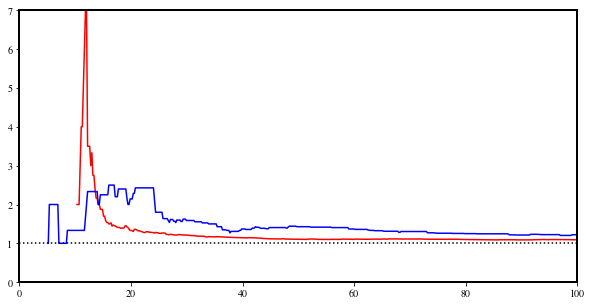

In [142]:
arcsecs = np.linspace(5, 100, 500)
COSMOS_dbl_enh = np.zeros(len(arcsecs))
GDN_dbl_enh = np.zeros(len(arcsecs))
for i, arc in enumerate(arcsecs):
    close_df = rdf.loc[ rdf['kpc_sep'] < arc ]
    COSMOS_IDs = np.concatenate( (close_df.loc[ close_df['field']=='COSMOS', 'prime_ID'].unique(), 
                                  close_df.loc[ close_df['field']=='COSMOS','partner_ID'].unique()) )
    GDN_IDs = np.concatenate( (close_df.loc[ close_df['field']=='GDN', 'prime_ID'].unique(), 
                                  close_df.loc[ close_df['field']=='GDN','partner_ID'].unique()) )
    COSMOS_dff = COSMOS_DBL.loc[COSMOS_DBL['ID'].isin(COSMOS_IDs) == True]
    GDN_dff = GDN_DBL.loc[GDN_DBL['ID'].isin(GDN_IDs) == True]
    COSMOS_dbl_enh[i] = COSMOS_dff['IR_COSMOS'].sum() / COSMOS_dff['IR_JIN'].sum()
    GDN_dbl_enh[i] = GDN_dff['IR_CANDELS'].sum() / GDN_dff['IR_LIU'].sum()
    
fig = plt.figure(figsize=(10,5))
plt.plot(arcsecs, COSMOS_dbl_enh, color='red', label='COSMOS superblended')
plt.plot(arcsecs, GDN_dbl_enh, color='blue', label='GDN superblended')
plt.xlim(0,100)
plt.ylim(0,7)
plt.plot([0,100],[1,1], color='black', linestyle=':')
plt.show()

# I want the ratio of the weights

In [37]:
# load in test pair df for COSMOS:
COSMOS_DBL = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_PAIRS_DBL_TEST.csv')
iCOSMOS_DBL = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_APPLES_DBL_TEST.csv')

GDN_DBL = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/GDN_PAIRS_DBL_TEST.csv')
iGDN_DBL = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/GDN_APPLES_DBL_TEST.csv')


In [44]:
C2 = GDN_DBL.loc[ GDN_DBL['arc_sep'] < 3 ]
a=np.sum(C2['IR_CANDELS_1']*C2['pair_prob'])+np.sum(C2['IR_CANDELS_2']*C2['pair_prob'])
b=np.sum(C2['IR_JIN_1']*C2['pair_prob'])+np.sum(C2['IR_JIN_2']*C2['pair_prob'])
print(a,b)

1.3287079837264755 0.5388959728232994


In [35]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # 0.7 for omega
# determine conservative ang separation correspondong to 150 kpc at z = 0.5
R_kpc = cosmo.arcsec_per_kpc_proper(0.5) # arcsec/kpc at z=0.5
# max_R_kpc = *u.kpc * R_kpc # in arcseconds ### this is the bug right here
1/R_kpc

<Quantity 6.10392633 kpc / arcsec>

## Compute AGN fraction and enhancement (with plots)

In [3]:
# 11.12 is a min_pp cut run of 0.25
# weirdness could also be due to poor masses (i.e. the whole sample seems to level itself out...)
# -----> yeah but then why is there no IR-only enhancement in minor mergers?
# -----> god help me

In [75]:
# let's put the convolution values together (minus COSMOS)
fields = ['GDS','EGS','COS','GDN','UDS','COSMOS']
# fields = ['GDS', 'GDN']
ztype='p'
Mlo = 9.4
N_controls = 3
min_pp = 0.1 # waiting for COSMOS to finish for the p P=0.1 group
date='12.13' # 8.25, 9.1, 9.2, 9.5 (COSMOS i_MAG < 25), # 9.21 for iceland, 11.6 good results for ps, 11.12 for p=0.25
bob_type = 'full' # 'full', 'randbob' #      12.12                    11.29 - bias present              11.20 for p=1
dfs = {}
cdfs = {}
PdA_dfs = {}
# PdA_arr = np.zeros((1783360, 1500)) # need to see how long before loading but let's see...

all_len = 0
for field in tqdm(fields):

    # pair data ### _Pp-'+str(min_pp)+'_
    # file = 'conv_prob/conv_output/PAIRS_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    file = 'conv_prob/conv_output/PAIRS_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    dfs[field] = pd.read_csv(PATH+file)
    
    # PdA arrays
    # with fits.open(PATH+'conv_prob/PdA_output/PdA_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
    with fits.open(PATH+'conv_prob/PdA_output/PdA_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
        PdA_dfs[field] = pd.DataFrame(data[0].data)
        
    # control data:
    # cfile = 'conv_prob/control_output/APPLES_bob-'+bob_type+'_M-'+str(Mlo)+'_N-2_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    cfile = 'conv_prob/control_output/APPLES_Pp-'+str(min_pp)+'_bob-'+bob_type+'_M-'+str(Mlo)+'_N-'+str(N_controls)+'_ztype-'+ztype+'_'+field+'_'+date+'.csv'
    cdfs[field] = pd.read_csv(PATH+cfile)

# dA = np.linspace(0, 200, num=2001)

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
print('concatinating PdA array... please wait.')
PdA_df = pd.concat(PdA_dfs).reset_index(drop=True)
PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
print('Done. Thanks for waiting!')
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] ))

# PdA_arr = np.concatenate(( np.array(PdA_df)[:,2:], np.array(PdA_df)[:,2:] )) # for use_PdA True
### This will take a good chunk of time... ^^^
                            
### ~~~ WILL NEED TO THINK HOW TO INCORPORATE THE ACTUAL REDSHIFT THE PAIR WOULD OVER LAP AT ~~~ ###
                            # SIMPLY IN TERMS OF BINNING #
### ~~~ MIGHT ALSO WANTTO CONIDER PUTTING THE dA ARRAY INTO THE PdA FILE SOMEHOW ~~~ ###


100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


concatinating PdA array... please wait.
Done. Thanks for waiting!


In [38]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# force cdf = rdf
# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True)
cdf = pd.DataFrame(np.repeat(rdf.values, 3, axis=0), columns=rdf.columns)
cdf['P_ID1'] = cdf['prime_ID']
cdf['P_ID2'] = cdf['partner_ID']
cdf['Cp'] = cdf['pair_prob']
cdf['Pp'] = cdf['pair_prob']
cdf = cdf.rename( columns={'prime_ID':'ID1', 'partner_ID':'ID2',
                           'prime_M':'MASS1', 'partner_M':'MASS2',
                           'prime_z':'z1', 'partner_z':'z2',
                           'prime_env':'ENV1', 'partner_env':'ENV2',
                           'prime_LX':'LX1', 'partner_LX':'LX2',
                           'prime_IR_AGN_DON':'IR_AGN_DON1', 'partner_IR_AGN_DON':'IR_AGN_DON2'} )
                           
cdf.loc[ cdf['LX1'] < 0, 'LX1' ] = -99
cdf.loc[ cdf['LX2'] < 0, 'LX2' ] = -99
cdf['LX1'] = cdf['LX1'].astype(float)
cdf['LX2'] = cdf['LX2'].astype(float)
cdf['Cp'] = cdf['Cp'].astype(float)
cdf['Pp'] = cdf['Pp'].astype(float)


In [67]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# comparing total AGN count in rdf and cdf
# for all galaxies (with duplicates)
P_AGN = np.sum(rdf['allLX'])
P_pairs = len(rdf)
P_prob = np.sum(rdf['pair_prob'])
# P_pAGN = np.sum(rdf['allLX'] * rdf['pair_prob'])
P_pAGN = np.sum(rdf['X_2'] * rdf['pair_prob']) # to test if prime or partner biased more... #prime bias ~15% vs ~35% for partners
C_AGN = np.sum(cdf['allLX'])
C_pairs = len(cdf)
C_prob = np.sum(cdf['Cp'])
# C_pAGN = np.sum(cdf['allLX'] * cdf['Cp'])
C_pAGN = np.sum(cdf['X_2'] * cdf['Cp'])

CtP_AGN = C_AGN/P_AGN
CtP_pairs = C_pairs/P_pairs
CtP_prob = C_prob/P_prob
CtP_pAGN = C_pAGN/P_pAGN

# compute total AGN bias
results = bin_analysis(rdf, cdf, PdA_arr, 5, 100, 10, 0.5, 3, ### is low LX not complete out further?
                          0, np.log10(4), ['COSMOS'], 'allLX', print_spexcess=False)
P_frac = results[1]
C_frac = results[4]
bias_CtP = C_frac/P_frac

print('Overall Control Shift = {}'.format(bias_CtP))
print('pure AGN ratio = {}'.format(CtP_AGN/3))
print('pure pair ratio = {}'.format(CtP_pairs/3))
print('pure prob ratio = {}'.format(CtP_prob/3))
print('pure fractional AGN ratio = {}'.format(CtP_pAGN/3))

Overall Control Shift = 1.2200418504274861
pure AGN ratio = 1.048769961156668
pure pair ratio = 1.0
pure prob ratio = 0.9961297753013686
pure fractional AGN ratio = 1.3507983865002469


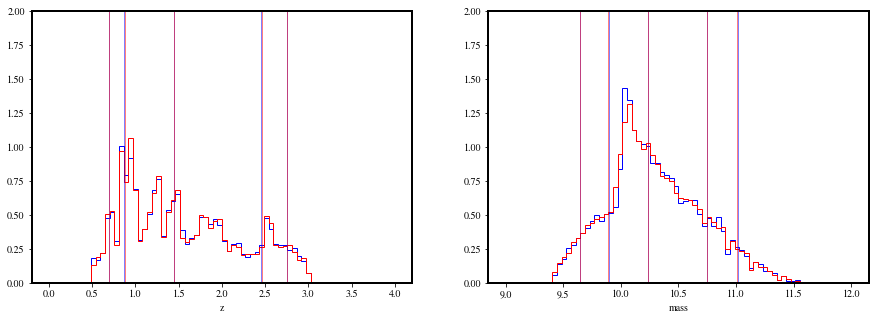

In [51]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# LX AGN are recieving larger weights in the control group...
# test that it isn't a bias in mass or redshift
# plot distributions and return percentiles
# compute total AGN bias
results = bin_analysis(rdf, cdf, PdA_arr, 5, 100, 10, 0.5, 3, ### is low LX not complete out further?
                          0, np.log10(4), ['COSMOS'], 'allLX', print_spexcess=False, plot_param=['z','mass'])


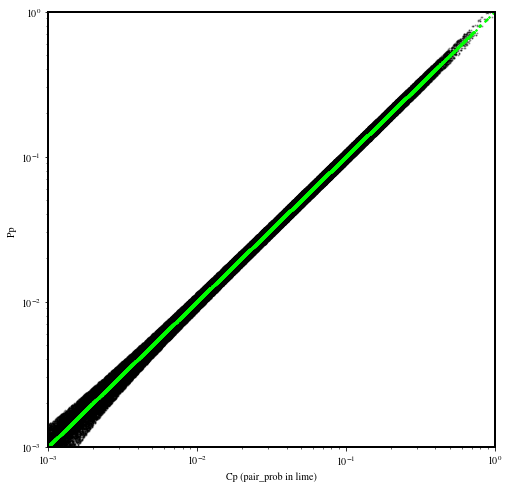

In [63]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# check Cp and Pp match is correct:
rp_pair_prob = np.repeat(rdf['pair_prob'], 3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
# plot in blue, as a test, Pp vs pair prob (should be exactly the same)
ax.scatter(cdf['Cp'], cdf['Pp'], s=1, alpha=0.3, color='black')
ax.scatter(rp_pair_prob, cdf['Pp'], s=1, color='lime')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cp (pair_prob in lime)')
ax.set_ylabel('Pp ')
ax.set_xlim(0.001,1)
ax.set_ylim(0.001,1)
plt.show()

In [65]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# check LX calculated correctly:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # 0.7 for omega
FX = 1.20e-14
z = 1.7215
gamma = 1.4
LX = ( FX * 4 * np.pi * ((cosmo.luminosity_distance(z).to(u.cm))**2).value *  ((1+z)**(gamma-2)) )
print(LX)

1.3155908779334e+44


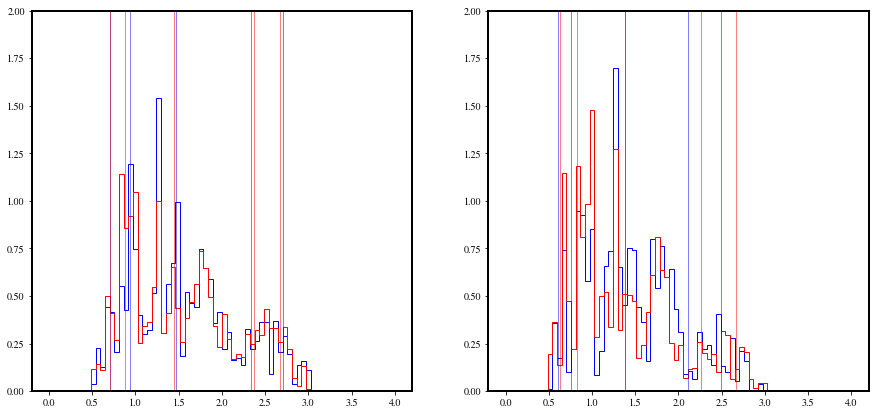

In [74]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# determine where in parameter space the XAGN bias is occuring, try with mass first
Xrdf1 = rdf.loc[ rdf['X_1'] == 1 ]
Xrdf2 = rdf.loc[ rdf['X_2'] == 1 ]
Xcdf1 = cdf.loc[ cdf['X_1'] == 1 ]
Xcdf2 = cdf.loc[ cdf['X_2'] == 1 ]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
bins = np.linspace(0,4,75)
x1 = Xrdf1['prime_z']
x2 =Xcdf1['z1']
ax[0].hist(x1, bins=bins, weights=Xrdf1['pair_prob'], density=True, histtype='step', color='blue')
ax[0].hist(x2, bins=bins, weights=Xcdf1['Cp'], density=True, histtype='step', color='red')
p_wpercs = weighted_quantile(x1, [0.05,0.16,0.5,0.85,0.95], sample_weight=Xrdf1['pair_prob'],)
i_wpercs = weighted_quantile(x2, [0.05,0.16,0.5,0.85,0.95], sample_weight=Xcdf1['Cp'])
for j in range(len(p_wpercs)):
    ax[0].plot([p_wpercs[j],p_wpercs[j]],[0,2], color='blue', lw=0.5)
    ax[0].plot([i_wpercs[j],i_wpercs[j]],[0,2], color='red', lw=0.5)
ax[0].set_ylim(0,2)

xx1 = Xrdf2['partner_z']
xx2 = Xcdf2['z2']
ax[1].hist(xx1, bins=bins, weights=Xrdf2['pair_prob'], density=True, histtype='step', color='blue')
ax[1].hist(xx2, bins=bins, weights=Xcdf2['Cp'], density=True, histtype='step', color='red')
p_wpercs = weighted_quantile(xx1, [0.05,0.16,0.5,0.85,0.95], sample_weight=Xrdf1['pair_prob'],)
i_wpercs = weighted_quantile(xx2, [0.05,0.16,0.5,0.85,0.95], sample_weight=Xcdf1['Cp'])
for j in range(len(p_wpercs)):
    ax[1].plot([p_wpercs[j],p_wpercs[j]],[0,2], color='blue', lw=0.5)
    ax[1].plot([i_wpercs[j],i_wpercs[j]],[0,2], color='red', lw=0.5)
ax[1].set_ylim(0,2)

plt.show()

90.88103037248733 90.42777328504779


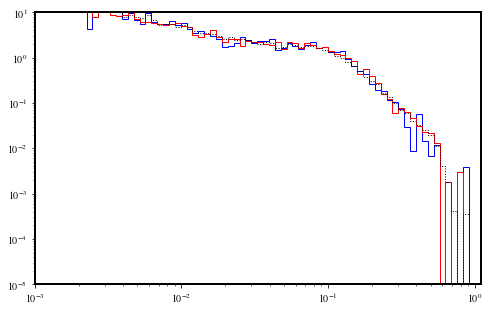

In [117]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# bluntly check that the weight distribution for XAGN is just plainly higher
Xrdf = rdf.loc[ rdf['allLX'] > 0 ]
Xcdf = cdf.loc[ cdf['allLX'] > 0 ]
print(np.sum(Xrdf['pair_prob']), np.sum(Xcdf['Cp'])/3)
bins=np.logspace(-20,0,500)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.hist(Xrdf['pair_prob'], bins=bins, histtype='step', density=True, color='blue')
ax.hist(Xcdf['Cp'], bins=bins, histtype='step', density=True, color='red')
# also plot the whole pair sample
ax.hist(rdf['pair_prob'], bins=bins, density=True, histtype='step', color='black', alpha=1, linestyle=':')
ax.set_xlim(0.001,1.1)
ax.set_ylim(0.00001,10)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [137]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# see that dPA isnt behaving incorrectly
zlo = 0.5
zhi = 2
Xfields = ['GDS','GDN','EGS','COS','UDS']
bin1 = rdf.loc[ (rdf['kpc_sep'] > 5) & (rdf['kpc_sep'] < 20) & (rdf['field'].isin(Xfields) == True) &
              (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) & 
               (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]
ibin1 = cdf.loc[ (cdf['pair_ID'].isin(bin1['pair_ID']) == True) ]
bin2 = rdf.loc[ (rdf['kpc_sep'] > 20) & (rdf['kpc_sep'] < 40) & (rdf['field'].isin(Xfields) == True) &
              (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) & 
               (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]
ibin2 = cdf.loc[ (cdf['pair_ID'].isin(bin2['pair_ID']) == True) ]
bin3 = rdf.loc[ (rdf['kpc_sep'] > 40) & (rdf['kpc_sep'] < 60) & (rdf['field'].isin(Xfields) == True) &
              (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) & 
               (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]
ibin3 = cdf.loc[ (cdf['pair_ID'].isin(bin3['pair_ID']) == True) ]
bin4 = rdf.loc[ (rdf['kpc_sep'] > 60) & (rdf['kpc_sep'] < 80) & (rdf['field'].isin(Xfields) == True) &
              (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) & 
               (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]
ibin4 = cdf.loc[ (cdf['pair_ID'].isin(bin4['pair_ID']) == True) ]
bin5 = rdf.loc[ (rdf['kpc_sep'] > 80) & (rdf['kpc_sep'] < 100) & (rdf['field'].isin(Xfields) == True) &
              (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) & 
               (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]
ibin5 = cdf.loc[ (cdf['pair_ID'].isin(bin5['pair_ID']) == True) ]
bin_all = rdf.loc[ (rdf['kpc_sep'] > 5) & (rdf['kpc_sep'] < 100) & (rdf['field'].isin(Xfields) == True) &
                 (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)) &
                  (rdf['prime_z'] < zhi) & (rdf['prime_z'] > zlo) ]

ibin_all = cdf.loc[ (cdf['pair_ID'].isin(bin_all['pair_ID']) == True) ]

bin1enh = np.sum(bin1['lowLX'] * bin1['pair_prob']) / np.sum(bin1['pair_prob'])
ibin1enh = np.sum(ibin1['lowLX'] * ibin1['Cp']) / np.sum(ibin1['Cp'])
bin2enh = np.sum(bin2['lowLX'] * bin2['pair_prob']) / np.sum(bin2['pair_prob'])
ibin2enh = np.sum(ibin2['lowLX'] * ibin2['Cp']) / np.sum(ibin2['Cp'])
bin3enh = np.sum(bin3['lowLX'] * bin3['pair_prob']) / np.sum(bin3['pair_prob'])
ibin3enh = np.sum(ibin3['lowLX'] * ibin3['Cp']) / np.sum(ibin3['Cp'])
bin4enh = np.sum(bin4['lowLX'] * bin4['pair_prob']) / np.sum(bin4['pair_prob'])
ibin4enh = np.sum(ibin4['lowLX'] * ibin4['Cp']) / np.sum(ibin4['Cp'])
bin5enh = np.sum(bin5['lowLX'] * bin5['pair_prob']) / np.sum(bin5['pair_prob'])
ibin5enh = np.sum(ibin5['lowLX'] * ibin5['Cp']) / np.sum(ibin5['Cp'])

bin_allenh = np.sum(bin_all['lowLX'] * bin_all['pair_prob']) / np.sum(bin_all['pair_prob'])
ibin_allenh = np.sum(ibin_all['lowLX'] * ibin_all['Cp']) / np.sum(ibin_all['Cp'])

results1 = bin_analysis(rdf, cdf, PdA_arr, 5, 20, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)
results2 = bin_analysis(rdf, cdf, PdA_arr, 20, 40, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)
results3 = bin_analysis(rdf, cdf, PdA_arr, 40, 60, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)
results4 = bin_analysis(rdf, cdf, PdA_arr, 60, 80, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)
results5 = bin_analysis(rdf, cdf, PdA_arr, 80, 100, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)
results_all = bin_analysis(rdf, cdf, PdA_arr, 5, 100, 10, zlo, zhi, ### is low LX not complete out further?
                          0, np.log10(4), Xfields, 'lowLX', print_spexcess=False, plot_param=False)

print(bin1enh, ibin1enh) #bin2enh, bin3enh, bin4enh, bin5enh)
print(bin2enh, ibin2enh)
print(bin3enh, ibin3enh)
print(bin4enh, ibin4enh)
print(bin5enh, ibin5enh)

print('~~~~~~~~~~~~~~~~~~~~')
print(results1[1], results1[4])
print(results2[1], results2[4])
print(results3[1], results3[4])
print(results4[1], results4[4])
print(results5[1], results5[4])


# bin_allenh, ibin_allenh

0.08389646071792631 0.034429905296778425
0.038870998966127744 0.041566312361783556
0.05328611549096418 0.02643491193272537
0.057942156840143616 0.03991504512921937
0.06687384412335881 0.027456507467758275
~~~~~~~~~~~~~~~~~~~~
0.0807330303152318 0.03486651263502157
0.0413581473393363 0.04194802782317689
0.054245995757627605 0.026642998458462786
0.057599508650736916 0.0395975660930155
0.06566409636817025 0.02723775850696149


In [139]:
results_all[0], results_all[3]

25.133333333333333

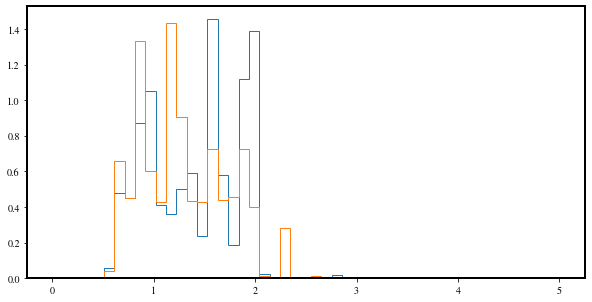

In [64]:
# see whats going on in the histogram space:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
bins = np.linspace(0, 5, 50)
ax.hist(bin_all['partner_z'], bins=bins, weights=bin_all['pair_prob']*bin_all['lowLX'], density=True, histtype='step')
ax.hist(ibin_all['z2'], bins=bins, weights=ibin_all['Cp']*ibin_all['lowLX'], density=True, histtype='step')
plt.show()

# potentially some weird feature at z = 1.6 or so that is just bulking everything?

In [100]:
ch = bin_all.loc[ (bin_all['pair_prob'] > 0.1) & (bin_all['lowLX'] > 0) ]
ich = cdf.loc[ (cdf['pair_ID'].isin(ch['pair_ID']) == True) ]
all_IDs = np.concatenate((ch['prime_ID'], ch['partner_ID']))
iall_IDs = np.concatenate((ich['ID1'], ich['ID2']))
print(len(all_IDs)/ len(np.unique(all_IDs)))
print(len(iall_IDs)/ len(np.unique(iall_IDs)))

# perhaps the bias is due to duplicates...?
# I honestly really doubt it, and I'm not trying to redo the logic for this test when I know it works in COSMOS


1.105263157894737
1.2233009708737863


In [3]:
def make_bins_PDF(max_dist=100, n_bins=10):
    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

0.8333333333333334

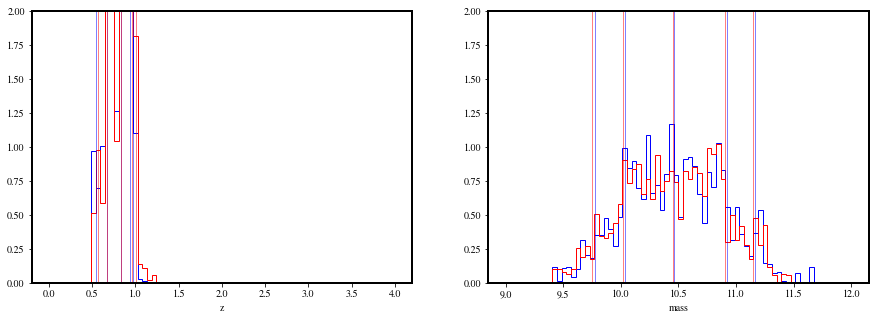

0.14260905045741143 1.2497638072045845
0.0013079381724240792 0.003830657869500502
0.34143956912409607


In [9]:
results = bin_analysis(rdf, cdf, PdA_arr, 5, 25, 10, 0.5, 1, ### is low LX not complete out further?
                          0, np.log10(4), fields, 'hiLX', print_spexcess=False, plot_param=['z','mass'])
print(results[0], results[3])
print(results[1], results[4]) # what's unique about the lowLX AGN... some weird event at z=1.6 or so...
print(results[1] / results[4])

In [ ]:
### ~~~ DIAGNOSTIC TEST ~~~ ###
# why is hiLX at z<1 so low...
idf = results[-1]
df = results[-2]
ids = np.concatenate((df['prime_ID'], df['partner_ID']))
iids = np.concatenate((idf['ID1'], idf['ID2']))

len(ids), len(np.unique(ids)), len(iids), len(np.unique(iids))

(68036, 35886, 204108, 53879)

In [20]:
results = bin_analysis(rdf, cdf, PdA_arr, 5, 75, 10, 0.5, 3,
                          0, np.log10(4), fields, 'IR', print_spexcess=False, f_obsc=False, plot_param=False)

# 10.26737
# 10.229

In [25]:
# test_df = results[-1]
# test_df.loc[ (test_df['Final_P']>0.01) & (test_df['IRallLX']>0) & 
#             (test_df['prime_zt'] == 's') & (test_df['partner_zt'] == 's') ]
x1 = results[3] 
x1e = results[4]
x2 = results[8] # 1.40 pm 
x2e = results[9]
print(x1/x2)
er = (x1/x2) * np.sqrt( (x1e/x1)**2 + (x2e/x2)**2 )
print(er)

1.3985731979381042
0.1823509571287383


In [44]:
IR1 = results[3]
IR1_se = results[4]
IR2 = results[8]
IR2_se = results[9]
IR12 = IR1/IR2
IR12_se = IR12 * np.sqrt( (IR1_se/IR1)**2 + (IR2_se/IR2)**2 )
print(IR12, IR12_se)

1.3985731979381042 0.17656090794947155


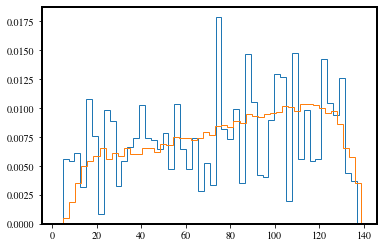

In [63]:
### ~~~ PARAMETER TEST ~~~ ###
IRdf = rdf.loc[ (rdf['IRallLX'] > 0) & (rdf['pair_prob'] > 0.01) ]
plt.hist(IRdf['kpc_sep'], bins=50, weights=IRdf['pair_prob'], density=True, histtype='step')
plt.hist(rdf['kpc_sep'], bins=50, weights=rdf['pair_prob'], density=True, histtype='step')
plt.show()

In [4]:
# define a function to find the median (any percentiles) of a weighted histogram
def perc_wei_hist(arr, arr_wei, percs):
    # sort the array accordingly:
    sort_idx = np.argsort(arr)
    sort_arr = arr[sort_idx]
    sort_probs = arr_wei[sort_idx]
    arr_tot = np.sum(sort_probs)
    arr_perc = []
    for perc in percs:
        # want to sum up the probs until they reach the perc:
        perc_count = (perc/100) * arr_tot
        pcount = 0
        i = 0
        while pcount < perc_count:
            pcount = np.sum(sort_probs[:i])
            i+=1
        arr_perc.append(sort_arr[i])
        
    return arr_perc

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


def wmean_se(df, AGN):
    # df['ptype'] = 'pp', 'ps', or 'ss'
    probs = df['Final_P']
    probs_N = probs / np.sum(probs)
    
    df['var2'] = [0]*len(df)
    pp_obs = np.array(df.loc[ df['ptype'] == 'pp', AGN])
    pp_probs = np.array(df.loc[ df['ptype'] == 'pp', 'Final_P'])
    pp_probs_N = pp_probs / np.sum(pp_probs)
    pp_mean = np.sum(pp_obs*pp_probs) / np.sum(pp_probs)
    df.loc[ df['ptype'] == 'pp', 'var2' ] = np.sum(pp_probs_N*(pp_obs - pp_mean)**2) / np.sum(pp_probs_N)           
    
    if len( df.loc[ df['ptype'] != 'pp' ] ) > 0:
        ps_obs = np.array(df.loc[ df['ptype'] == 'ps', AGN])
        ps_probs = np.array(df.loc[ df['ptype'] == 'ps', 'Final_P'])
        ps_probs_N = ps_probs / np.sum(ps_probs)
        ps_mean = np.sum(ps_obs*ps_probs) / np.sum(ps_probs)
        df.loc[ df['ptype'] == 'ps', 'var2' ] = np.sum(ps_probs_N*(ps_obs - ps_mean)**2) / np.sum(ps_probs_N)      

        ss_obs = np.array(df.loc[ df['ptype'] == 'ss', AGN])
        ss_probs = np.array(df.loc[ df['ptype'] == 'ss', 'Final_P'])
        ss_probs_N = ss_probs / np.sum(ss_probs)
        ss_mean = np.sum(ss_obs*ss_probs) / np.sum(ss_probs)
        df.loc[ df['ptype'] == 'ss', 'var2' ] = np.sum(ss_probs_N*(ss_obs - ss_mean)**2) / np.sum(ss_probs_N)      
    
    # return np.sqrt( np.sum( df['Final_P']**2 * df['var2'] ) ) # pp_probs_N
    return np.sqrt( np.sum( probs_N**2 * df['var2'] ) )


def bootstrap(obs, weights, n_boots=1000):
    weights_norm = weights / np.sum(weights)    # maybe I'm drawing too many sources
    boot_mean = np.zeros(n_boots)
    for i in range(n_boots):
        boot_d = np.random.choice(obs, size=len(np.where(weights > 0.01)[0]), replace=True, p=weights_norm)
        # boot_d = np.random.choice(obs, size=int(np.sum(weights)), replace=True, p=weights_norm)
        boot_mean[i] = np.mean(boot_d)
    
    # bins = np.linspace(0,1,500)
    # # bins=np.logspace(-20,0,1000)
    # plt.hist(boot_mean, bins=bins)
    # plt.xlim(0,0.25)
    # plt.show()
    return np.sqrt(np.var(boot_mean))

def bootstrap2(obs, weights, n_boots=250):
    # weights_norm = weights / np.sum(weights) 
    boot_frac = np.zeros(n_boots)
    obs_idx = np.arange(0, len(weights), 1)
    for i in range(n_boots):
        boot_d = np.random.choice(obs_idx, size=len(obs), replace=True) #, p=weights_norm)
        # calculate the weighted AGN fraction:
        obs_it = obs[boot_d]
        weights_it = weights[boot_d]
        boot_frac[i]= np.sum(obs_it * weights_it) / np.sum(weights_it)
    # finally, estimate the standard error
    return np.sqrt( np.sum( (boot_frac-np.mean(boot_frac))**2 ) / (n_boots-1) )



def bootstrap_obsc(obsc_obs, X_obs, weights, n_boots=250):
    # weights_norm = weights / np.sum(weights)
    boot_frac = np.zeros(n_boots)
    obs_idx = np.arange(0, len(obsc_obs), 1)
    for i in range(n_boots):
        # want to draw from the indices of them all, so we can select obsc and X obs:
        boot_d = np.random.choice(obs_idx, size=len(X_obs), replace=True)#, p=weights_norm)
        obsc_it = obsc_obs[boot_d]
        Xray_it = X_obs[boot_d]
        weights_it = weights[boot_d]
        boot_frac[i] = np.sum(obsc_it*weights_it) / np.sum(Xray_it*weights_it)
        
    # finally, estimate the standard error
    return np.sqrt( np.sum( (boot_frac-np.mean(boot_frac))**2 ) / (n_boots-1) )

def bin_analysis(bin_df, ibin_df, PdA_arr, low, high, prime_mass_lo, prime_z_lo, prime_z_hi, 
                   mr_lo, mr_hi, fields, AGN_type, p_lo=0, N_controls=3, 
                   print_spexcess=False, plot_param=False, f_obsc=False):
    
    dA = np.linspace(0, 200, num=2001)
    
    df = bin_df.loc[ (bin_df['prime_M'] > prime_mass_lo) & (bin_df['pair_prob'] > p_lo) & 
                              (bin_df['prime_z'] > prime_z_lo) & (bin_df['prime_z'] < prime_z_hi) &
                              (bin_df['mass_ratio'] >= mr_lo) & (bin_df['mass_ratio'] < mr_hi) &
                             (bin_df['field'].isin(fields) == True) ]
    PdA = PdA_arr[df.index]
    Pr = np.trapz(PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    PP = np.array(df['pair_prob']) * Pr[:,0]
    obs = np.array(df[AGN_type])
    count =  np.sum(PP * obs)
    high_p = len(obs[np.where(PP > 0.01)])
    sum_p = np.sum(PP)
    PPn = PP / np.sum(PP)
    frac = np.sum(obs * PPn)
    # se = bootstrap(obs, PP)#PPn)
    se = bootstrap2(obs, PP)#PPn)
        
    idf = ibin_df.loc[ (ibin_df['pair_ID'].isin(df['pair_ID']) == True) ]
    iPP = np.array(idf['Cp'])*np.repeat(Pr[:,0], N_controls)
    iobs = np.array(idf[AGN_type])
    icount = np.sum(iPP * iobs)
    ihigh_p = len(iobs[np.where(iPP > 0.01)])
    isum_p = np.sum(iPP)
    iPPn = iPP / np.sum(iPP)
    ifrac = np.sum(iobs * iPPn)  
    # ise = bootstrap(iobs, iPP)#iPPn)
    ise = bootstrap2(iobs, iPP)#iPPn)
    
    # if AGN_type == 'lowLX' and print_spexcess == True:
    #     print('lowLX High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    # elif AGN_type == 'midLX' and print_spexcess == True:
    #     print('midLX High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    # elif AGN_type == 'hiLX' and print_spexcess == True:
    #     print('hiLX High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    # elif AGN_type == 'allLX' and print_spexcess == True:
    #     print('allLX High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    # elif AGN_type == 'IRallLX' and print_spexcess == True:
    #     print('IRallLX High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    # elif AGN_type == 'IR' and print_spexcess == True:
    #     print('IR High Prob Excess = ',(np.sum(high_p)/len(high_p)) / (np.sum(ihigh_p)/len(ihigh_p)))
    #     print('counts (scaled) --->', np.sum(high_p), np.sum(ihigh_p)/3)
    
    # return a test output
    df['Pr'] = Pr
    df['Final_P'] = PP
    idf['Pr'] = np.repeat(Pr[:,0], N_controls)
    idf['Final_P'] = iPP
    
    # ### ~~~ ATTEMPT OTHER ERROR ESTIMATOR ~~~ ###
    # new_se = wmean_se(df, AGN_type)
    # # print('NEW SE:', new_se)
    # se = wmean_se(df, AGN_type)
    # ise = wmean_se(idf, AGN_type)
    # ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    
    # print(len(df.loc[ (df['Final_P'] > 0.25) & (df[AGN_type] > 0) ,'prime_ID']), 
    #       len(df.loc[ (df['Final_P'] > 0.25) & (df[AGN_type] > 0) ,'prime_ID'].unique()))
    # print(len(idf.loc[ (idf['Final_P'] > 0.25) & (idf[AGN_type] > 0), 'ID1']), 
    #       len(idf.loc[ (idf['Final_P'] > 0.25) & (idf[AGN_type] > 0), 'ID1'].unique()))
    # ah okay, but what about for those with an AGN...
    
    # return distribution plots:
    if plot_param != False:
        fig, ax = plt.subplots(nrows=1, ncols=len(plot_param), figsize=(15,5))
        for i, plot_par in enumerate(plot_param):
            if plot_par == 'z':
                zbins = np.linspace(0,4,75)
                pz = np.concatenate( (df['prime_z'], df['partner_z']) )
                p_w = np.concatenate( (df['Final_P'], df['Final_P']) )
                iz = np.concatenate( (idf['z1'], idf['z2']) )
                i_w = np.concatenate( (idf['Final_P'], idf['Final_P']) )
                ax[i].hist( pz, bins=zbins, weights=p_w, histtype='step', density=True, color='blue')
                ax[i].hist( iz, bins=zbins, weights=i_w, histtype='step', density=True, color='red')
                # determine weighted percentiles
                p_wpercs = weighted_quantile(pz, [0.05,0.16,0.5,0.85,0.95], sample_weight=p_w)
                i_wpercs = weighted_quantile(iz, [0.05,0.16,0.5,0.85,0.95], sample_weight=i_w)
                for j in range(len(p_wpercs)):
                    ax[i].plot([p_wpercs[j],p_wpercs[j]],[0,2], color='blue', lw=0.5)
                    ax[i].plot([i_wpercs[j],i_wpercs[j]],[0,2], color='red', lw=0.5)
                ax[i].set_ylim(0,2)
                ax[i].set_xlabel('z')
            if plot_par == 'mass':
                mbins = np.linspace(9,12,75)
                pm = np.concatenate( (df['prime_M'], df['partner_M']) )
                p_w = np.concatenate( (df['Final_P'], df['Final_P']) )
                im = np.concatenate( (idf['MASS1'], idf['MASS2']) )
                i_w = np.concatenate( (idf['Final_P'], idf['Final_P']) )
                ax[i].hist( pm, bins=mbins, weights=p_w, histtype='step', density=True, color='blue')
                ax[i].hist( im, bins=mbins, weights=i_w, histtype='step', density=True, color='red')
                # determine weighted percentiles
                p_wpercs = weighted_quantile(pm, [0.05,0.16,0.5,0.85,0.95], sample_weight=p_w)
                i_wpercs = weighted_quantile(im, [0.05,0.16,0.5,0.85,0.95], sample_weight=i_w)
                for j in range(len(p_wpercs)):
                    ax[i].plot([p_wpercs[j],p_wpercs[j]],[0,2], color='blue', lw=0.5)
                    ax[i].plot([i_wpercs[j],i_wpercs[j]],[0,2], color='red', lw=0.5)
                ax[i].set_ylim(0,2)
                ax[i].set_xlabel('mass')
        plt.show()
    
    if f_obsc == False:
        return high_p, sum_p, count, frac, se, ihigh_p, isum_p, icount, ifrac, ise#, df#, idf
    else:
        return high_p, sum_p, count, frac, se, ihigh_p, isum_p, icount, ifrac, ise, obs, PP, iobs, iPP


def plot_bin_props(df, idf):
    fig = plt.figure(figsize=(10,10))
    x = np.array(idf['MASS1'])
    # x = np.array(idf['z1'])
    x = x.reshape((len(x),1))
    y = np.repeat(np.array(df['prime_M']), 3)
    # y = np.repeat(np.array(df['prime_z']), 3)
    y = y.reshape((len(y),1))
    x2 = np.array(idf['MASS2'])
    # x2 = np.array(idf['z2'])
    x2 = x2.reshape((len(x2),1))
    y2 = np.repeat(np.array(df['partner_M']), 3)
    # y2 = np.repeat(np.array(df['partner_z']), 3)
    y2 = y2.reshape((len(y2),1))

    # y = np.array(idf['ENV1'])
    # y = y.reshape((len(y),1))
    # x = np.repeat(np.array(df['prime_env']), 3)
    # x = x.reshape((len(x),1))
    # y2 = np.array(idf['ENV2'])
    # y2 = y2.reshape((len(y2),1))
    # x2 = np.repeat(np.array(df['partner_env']), 3)
    # x2 = x2.reshape((len(x2),1))
    w = np.array(idf['Final_P'])

    # plt.scatter( x[np.where(w>0)], y[np.where(w>0)], c=w[np.where(w>0)], s=5, alpha=1 )
    # plt.scatter( x2[np.where(w>0)], y2[np.where(w>0)], c=w[np.where(w>0)], s=5, alpha=1 )
    plt.scatter( x[np.where(w>0)], y[np.where(w>0)], s=w[np.where(w>0)], alpha=1, color='red' )
    plt.scatter( x2[np.where(w>0)], y2[np.where(w>0)], s=w[np.where(w>0)], alpha=1, color='blue' )
    plt.plot([0,12],[0,12], color='black', linestyle=':')
    # plt.plot([10,11.5],[10,11.5], color='black', linestyle='-', lw=3)

    # The weighted model
    regr = LinearRegression()
    regr.fit(x, y, w)
    plt.plot(x, regr.predict(x), color='red', linewidth=1, label='prime match', linestyle=':')

    regr = LinearRegression()
    regr.fit(x2, y2, w)
    plt.plot(x2, regr.predict(x2), color='blue', linewidth=1, label='partner fit', linestyle=':')


    plt.legend(fontsize=20)

    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(9.4,11.5)
    plt.ylim(9.4,11.5)
    # plt.xlim(0,3)
    # plt.ylim(0,3)
    plt.xlabel('TRUE PAIR', fontsize=20)
    plt.ylabel('CONTROL PAIR', fontsize=20)
    plt.title('Last bin', fontsize=25)
    plt.show()


In [5]:
# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True)
cdf = pd.concat(cdfs).reset_index(drop=True)

# no just match based on pair ID strings as so
rdf['pair_ID'] = rdf['field'] +'_'+ (rdf['prime_ID'].astype(int)).astype(str) +'+'+ (rdf['partner_ID'].astype(int)).astype(str)
cdf['pair_ID'] = cdf['field'] +'_'+ (cdf['P_ID1'].astype(int)).astype(str) +'+'+ (cdf['P_ID2'].astype(int)).astype(str)
cdf['apple_ID'] = cdf['field'] +'_'+ (cdf['ID1'].astype(int)).astype(str) +'+'+ (cdf['ID2'].astype(int)).astype(str)

# and save each:
rdf.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/test_output/rdf.csv', index=False)
cdf.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/test_output/cdf.csv', index=False)

In [84]:
# rdf.loc[ rdf['prime_PDFsig'] < 0.01 ]
# np.sum(PdA_arr[19470])
# len(dA)

In [76]:
# create bins:
max_dist=100
n_bins=4
resolve = False
use_PdA = True # resolving in this case is pointless, so don't worry about that switch when this one is on
maj_mr = np.log10(4) # major mergers
min_mr = 1
bottom = 0
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)
# PdA_arr = np.array(PdA_df)[:,2:] # hopefully this doesn't take ages...
dA = np.linspace(0, 200, num=2001)
lowLX = 42# - 0.4 
midLX = 43.2# - 0.4   
hiLX = 43.7# - 0.4
z_bottom = 0.5
z_mid1 = 1
z_mid2 = 2
z_top = 3

# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True)
cdf = pd.concat(cdfs).reset_index(drop=True)

# if pp, ps, and ss have different variances, then we need to know which pairs fall into each catagory:
# designate ptypes (pair types - phot-phot, spec-phot, spec-spec)
rdf['ptype'] = ['pp']*len(rdf)
cdf['ptype'] = ['pp']*len(cdf)
if ztype != 'p':
    rdf.loc[ (rdf['prime_zt'] == 's') & (rdf['partner_zt'] == 's'), 'ptype' ] = 'ss'
    rdf.loc[ ((rdf['prime_zt'] == 's') & (rdf['partner_zt'] == 'p')) | ((rdf['prime_zt'] == 'p') & (rdf['partner_zt'] == 's')), 'ptype' ] = 'ps'
    cdf.loc[ (cdf['SIG1'] == 0.01) & (cdf['SIG2'] == 0.01), 'ptype' ] = 'ss'
    cdf.loc[ ((cdf['SIG1'] == 0.01) & (cdf['SIG2'] != 0.01)) | ((cdf['SIG1'] != 0.01) & (cdf['SIG2'] == 0.01)), 'ptype' ] = 'ps'

# no just match based on pair ID strings as so
rdf['pair_ID'] = rdf['field'] +'_'+ (rdf['prime_ID'].astype(int)).astype(str) +'+'+ (rdf['partner_ID'].astype(int)).astype(str)
cdf['pair_ID'] = cdf['field'] +'_'+ (cdf['P_ID1'].astype(int)).astype(str) +'+'+ (cdf['P_ID2'].astype(int)).astype(str)
cdf['apple_ID'] = cdf['field'] +'_'+ (cdf['ID1'].astype(int)).astype(str) +'+'+ (cdf['ID2'].astype(int)).astype(str)

# get the N_controls selected from bobbing method:
# N_controls = 3 #int(cfile.split('/')[-1].split('_')[1][2]) # should work, also don't need to do things this way

# add an AGN count per pair column:
rdf['lowX_1'] = [0]*len(rdf)
rdf['IRlowX_1'] = [0]*len(rdf) # IR exclusive
rdf['lowX_2'] = [0]*len(rdf)
rdf['IRlowX_2'] = [0]*len(rdf)
rdf['midX_1'] = [0]*len(rdf)
rdf['IRmidX_1'] = [0]*len(rdf)
rdf['midX_2'] = [0]*len(rdf)
rdf['IRmidX_2'] = [0]*len(rdf)
rdf['hiX_1'] = [0]*len(rdf)
rdf['IRhiX_1'] = [0]*len(rdf)
rdf['hiX_2'] = [0]*len(rdf)
rdf['IRhiX_2'] = [0]*len(rdf)
rdf['X_1'] = [0]*len(rdf)
rdf['IRX_1'] = [0]*len(rdf)
rdf['X_2'] = [0]*len(rdf)
rdf['IRX_2'] = [0]*len(rdf)
rdf['IR_1'] = [0]*len(rdf)
rdf['IR_2'] = [0]*len(rdf)
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX) & (np.log10(rdf['prime_LX']) < midLX), 'lowX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX) & (np.log10(rdf['partner_LX']) < midLX), 'lowX_2' ] = 1
rdf['lowLX'] = rdf['lowX_1'] + rdf['lowX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > midLX) & (np.log10(rdf['prime_LX']) < hiLX), 'midX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > midLX) & (np.log10(rdf['partner_LX']) < hiLX), 'midX_2' ] = 1
rdf['midLX'] = rdf['midX_1'] + rdf['midX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > hiLX), 'hiX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > hiLX), 'hiX_2' ] = 1
rdf['hiLX'] = rdf['hiX_1'] + rdf['hiX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX), 'X_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX), 'X_2' ] = 1
rdf['allLX'] = rdf['X_1'] + rdf['X_2']
rdf.loc[ (rdf['prime_IR_AGN_DON'] == 1), 'IR_1' ] = 1     ##### CHANGED #####
rdf.loc[ (rdf['partner_IR_AGN_DON'] == 1), 'IR_2' ] = 1
# rdf.loc[ (rdf['IR_JIN_1'] == 1), 'IR_1' ] = 1
# rdf.loc[ (rdf['IR_JIN_2'] == 1), 'IR_2' ] = 1
rdf['IR'] = rdf['IR_1'] + rdf['IR_2']
rdf.loc[ (rdf['IR_1'] == 1) & (rdf['lowX_1'] != 1), 'IRlowX_1' ] = 1 # may need to think how these are defined...
rdf.loc[ (rdf['IR_2'] == 1) & (rdf['lowX_2'] != 1), 'IRlowX_2' ] = 1
rdf['IRlowLX'] = rdf['IRlowX_1'] + rdf['IRlowX_2']
rdf.loc[ (rdf['IR_1'] == 1) & (rdf['midX_1'] != 1), 'IRmidX_1' ] = 1
rdf.loc[ (rdf['IR_2'] == 1) & (rdf['midX_2'] != 1), 'IRmidX_2' ] = 1
rdf['IRmidLX'] = rdf['IRmidX_1'] + rdf['IRmidX_2']
rdf.loc[ (rdf['IR_1'] == 1) & (rdf['hiX_1'] != 1), 'IRhiX_1' ] = 1
rdf.loc[ (rdf['IR_2'] == 1) & (rdf['hiX_2'] != 1), 'IRhiX_2' ] = 1
rdf['IRhiLX'] = rdf['IRhiX_1'] + rdf['IRhiX_2']
rdf.loc[ (rdf['IR_1'] == 1) & (rdf['X_1'] != 1), 'IRX_1' ] = 1
rdf.loc[ (rdf['IR_2'] == 1) & (rdf['X_2'] != 1), 'IRX_2' ] = 1
rdf['IRallLX'] = rdf['IRX_1'] + rdf['IRX_2']

cdf['lowX_1'] = [0]*len(cdf)
cdf['IRlowX_1'] = [0]*len(cdf)
cdf['lowX_2'] = [0]*len(cdf)
cdf['IRlowX_2'] = [0]*len(cdf)
cdf['midX_1'] = [0]*len(cdf)
cdf['IRmidX_1'] = [0]*len(cdf)
cdf['midX_2'] = [0]*len(cdf)
cdf['IRmidX_2'] = [0]*len(cdf)
cdf['hiX_1'] = [0]*len(cdf)
cdf['IRhiX_1'] = [0]*len(cdf)
cdf['hiX_2'] = [0]*len(cdf)
cdf['IRhiX_2'] = [0]*len(cdf)
cdf['X_1'] = [0]*len(cdf)
cdf['IRX_1'] = [0]*len(cdf)
cdf['X_2'] = [0]*len(cdf)
cdf['IRX_2'] = [0]*len(cdf)
cdf['IR_1'] = [0]*len(cdf)
cdf['IR_2'] = [0]*len(cdf)
cdf.loc[ (np.log10(cdf['LX1']) > lowLX) & (np.log10(cdf['LX1']) < midLX), 'lowX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX) & (np.log10(cdf['LX2']) < midLX), 'lowX_2' ] = 1
cdf['lowLX'] = cdf['lowX_1'] + cdf['lowX_2']
cdf.loc[ (np.log10(cdf['LX1']) > midLX) & (np.log10(cdf['LX1']) < hiLX), 'midX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > midLX) & (np.log10(cdf['LX2']) < hiLX), 'midX_2' ] = 1
cdf['midLX'] = cdf['midX_1'] + cdf['midX_2']
cdf.loc[ (np.log10(cdf['LX1']) > hiLX), 'hiX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > hiLX), 'hiX_2' ] = 1
cdf['hiLX'] = cdf['hiX_1'] + cdf['hiX_2']
cdf.loc[ (np.log10(cdf['LX1']) > lowLX), 'X_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX), 'X_2' ] = 1
cdf['allLX'] = cdf['X_1'] + cdf['X_2']
cdf.loc[ (cdf['IR_AGN_DON1'] == 1), 'IR_1' ] = 1    ##### CHANGED #####
cdf.loc[ (cdf['IR_AGN_DON2'] == 1), 'IR_2' ] = 1
# cdf.loc[ (cdf['IR_JIN_1'] == 1), 'IR_1' ] = 1
# cdf.loc[ (cdf['IR_JIN_2'] == 1), 'IR_2' ] = 1
cdf['IR'] = cdf['IR_1'] + cdf['IR_2']
cdf.loc[ (cdf['IR_1'] == 1) & (cdf['lowX_1'] != 1), 'IRlowX_1' ] = 1
cdf.loc[ (cdf['IR_2'] == 1) & (cdf['lowX_2'] != 1), 'IRlowX_2' ] = 1
cdf['IRlowLX'] =  cdf['IRlowX_1'] + cdf['IRlowX_2']
cdf.loc[ (cdf['IR_1'] == 1) & (cdf['midX_1'] != 1), 'IRmidX_1' ] = 1
cdf.loc[ (cdf['IR_2'] == 1) & (cdf['midX_2'] != 1), 'IRmidX_2' ] = 1
cdf['IRmidLX'] =  cdf['IRmidX_1'] + cdf['IRmidX_2']
cdf.loc[ (cdf['IR_1'] == 1) & (cdf['hiX_1'] != 1), 'IRhiX_1' ] = 1
cdf.loc[ (cdf['IR_2'] == 1) & (cdf['hiX_2'] != 1), 'IRhiX_2' ] = 1
cdf['IRhiLX'] =  cdf['IRhiX_1'] + cdf['IRhiX_2']
cdf.loc[ (cdf['IR_1'] == 1) & (cdf['X_1'] != 1), 'IRX_1' ] = 1
cdf.loc[ (cdf['IR_2'] == 1) & (cdf['X_2'] != 1), 'IRX_2' ] = 1
cdf['IRallLX'] =  cdf['IRX_1'] + cdf['IRX_2']

##########################################################################
### --- get all cuts here --- ############################################
### --- perhaps a dictionary of dictionaries for the results --- #########
### --- lowLX                                                    #########
### --- midLX                                                    #########
### --- hiLX { maj, majmin, min } # maj results for each bin.... ######### 
### --- IR                                                       #########
### --- I need to save count, frac, and se for each of these     #########
##########################################################################

major, minor, major_minor = {},{},{}
data = ['NhiP', 'sumP','count','frac','se']
AGN_type = ['lowLX','midLX','hiLX','allLX','IR', 'ilowLX','imidLX','ihiLX','iallLX','iIR',
           'IRlowLX','IRmidLX','IRhiLX','IRallLX', 'iIRlowLX','iIRmidLX','iIRhiLX','iIRallLX']
for AGN in AGN_type:
    for dat in data:
        major[AGN+'_'+dat] = {}
        minor[AGN+'_'+dat] = {}
        major_minor[AGN+'_'+dat] = {}
major_z = {}
AGN_type_z = ['midLX_zlo', 'midLX_zmid', 'hiLX_zlo', 'hiLX_zmid', 'hiLX_zhi', 'allLX_zlo', 'allLX_zmid', 'allLX_zhi',
             'imidLX_zlo', 'imidLX_zmid', 'ihiLX_zlo', 'ihiLX_zmid', 'ihiLX_zhi', 'iallLX_zlo', 'iallLX_zmid', 'iallLX_zhi']
for AGN in AGN_type_z:
    for dat in data:
        major_z[AGN+'_'+dat] = {}
        
# make a dictionary to store f_obs values
obsc_dict = {}
entries = ['IRallLX_obs', 'IRallLX_PP', 'allLX_obs', 'allLX_PP', 'iIRallLX_obs', 'iIRallLX_PP', 'iallLX_obs', 'iallLX_PP']
for ent in entries:
    obsc_dict[ent] = {}

# store total counts
tot_pair, tot_iso, bin_dfs = {},{},{} # to look at dfs in post

# IRAX flux errors
pCH1_ABmag_bin, pCH2_ABmag_bin, pCH3_ABmag_bin, pCH4_ABmag_bin = {},{},{},{}
iCH1_ABmag_bin, iCH2_ABmag_bin, iCH3_ABmag_bin, iCH4_ABmag_bin = {},{},{},{}

pboot_Xse, iboot_Xse = {}, {}
pboot_IRse, iboot_IRse = {}, {}

p_probs, i_probs, p_wprobs, i_wprobs, P_W, I_W = {},{},{},{},{},{}
ID_bin, field_bin, iID_bin, ifield_bin = {},{},{},{}
c_dfd = {} # dictionary of dataframes for each bin for the control galaxy selection
pz_bin, pmass_bin, psig_bin, penv_bin = {},{},{},{}
iz_bin, imass_bin, isig_bin, ienv_bin = {},{},{},{}

pX_bin, pDo_bin, poDo_bin, pSt_bin = {},{},{},{}
iX_bin, iDo_bin, ioDo_bin, iSt_bin = {},{},{},{}

pXAGN_count, pXAGN_frac, iXAGN_count, iXAGN_frac = {},{},{},{}

# collect distribution of entire data
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) ) # no longer care about this
penv = np.concatenate( (rdf['prime_env'], rdf['partner_env']) )

iz = np.concatenate( (cdf['z1'], cdf['z2']) )
imass = np.concatenate( (cdf['MASS1'], cdf['MASS2']) )
isig = np.concatenate( (cdf['SIG1'], cdf['SIG2']) )
ienv = np.concatenate( (cdf['ENV1'], cdf['ENV2']) )
# isig = ...

# ### perhaps I should define these always ... ###
# rdf = rdf.loc[ (rdf['prime_M'] > 10) & (rdf['prime_z'] < 3) & (rdf['field'] != 'COSMOS') & #| (rdf['field'] == 'COS')) &
#           (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] < mass_ratio) ]
# # no just match based on pair ID strings as so
# cdf = cdf.loc[ (cdf['pair_ID'].isin(rdf['pair_ID']) == True) ]

rdf2 = rdf.loc[ rdf['pair_prob'] > 0.01 ]

# split data frame up into each bin
for i, rnge in tqdm(enumerate(bins)):
    print(bins[rnge])
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])
    
    bin_df = rdf #[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) & (rdf['kpc_sep'] > 4) ]
    # bin_df = rdf[ (rdf['kpc_sep'] > 3) ]
    ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]
#     bin_dfs[bins[rnge]] = bin_df           ### ~~~ WILL NEED TO UPDATE THE PROBABILITIES FOR CONTROL SELECTION ~~~ ###

    # bin_PdA = PdA_arr[rdf.index] # may need to be bin_df.index, but no difference obv
    if i == 0: # should be the closest bin
        low = 5

#     # test:
#     bbb = rdf.loc[ (rdf['prime_M'] > 10) & #(rdf['pair_prob'] > 0.1) & 
#                               (rdf['prime_z'] > 0.5) & (rdf['prime_z'] < 2) &
#                               (rdf['mass_ratio'] > 0) & (rdf['mass_ratio'] < np.log10(4)) & 
#                               (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] < high) &
#                              (rdf['field'].isin(['GDS','GDN']) == True) ]
#     ibbb = cdf.loc[ (cdf['pair_ID'].isin(bbb['pair_ID']) == True) ]
#     ##### test it here #####
#     fr = np.sum(np.array(bbb['lowLX']) * np.array(bbb['pair_prob'])) / np.sum(bbb['pair_prob'])
#     ifr = np.sum(np.array(ibbb['lowLX']) * np.array(ibbb['Cp'])) / np.sum(ibbb['Cp'])
    
#     fIR = np.sum(np.array(bbb['IR']) * np.array(bbb['pair_prob'])) / np.sum(bbb['pair_prob'])
#     ifIR = np.sum(np.array(ibbb['IR']) * np.array(ibbb['Cp'])) / np.sum(ibbb['Cp'])
#     print(bins[rnge], fr/ifr, fIR/ifIR)
                                                    
                                                    
    

    ###############################################################################
    ############ -- GET WEIGHTS WITHOUT SPLITTING EVERYTHING UP TOO -- ############
    ###############################################################################
    
    ### ----------------------------------- ###
    ### ----------------------------------- ### MAJOR
    ### ----------------------------------- ###
    
    # try if my function works for maj low_LX:
    ######################
    ### %%% MAJOR %%% ####
    ######################
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 2, ### is low LX not complete out further?
                          0, np.log10(4), ['GDS','GDN'], 'lowLX', print_spexcess=True)
    major['lowLX_NhiP'][bins[rnge]] = results[0]
    major['lowLX_sumP'][bins[rnge]] = results[1]
    major['lowLX_count'][bins[rnge]] = results[2]
    major['lowLX_frac'][bins[rnge]] = results[3]
    major['lowLX_se'][bins[rnge]] = results[4]
    major['ilowLX_NhiP'][bins[rnge]] = results[5]
    major['ilowLX_sumP'][bins[rnge]] = results[6]
    major['ilowLX_count'][bins[rnge]] = results[7]
    major['ilowLX_frac'][bins[rnge]] = results[8]
    major['ilowLX_se'][bins[rnge]] = results[9]
    # if i == 1:
    #     TEST_BIN = bin_df
    #     ITEST_BIN = ibin_df
    #     TEST_ARR = PdA_arr
    #     TEST_LOW = low
    #     TEST_HIGH = high
    #     break
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 2,
    #                       0, np.log10(4), ['GDS','GDN'], 'IRlowLX', print_spexcess=False)
    # major['IRlowLX_count'][bins[rnge]] = results[0]
    # major['IRlowLX_frac'][bins[rnge]] = results[1]
    # major['IRlowLX_se'][bins[rnge]] = results[2]
    # major['iIRlowLX_count'][bins[rnge]] = results[3]
    # major['iIRlowLX_frac'][bins[rnge]] = results[4]
    # major['iIRlowLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 2,
                          0, np.log10(4), fields, 'midLX', print_spexcess=True)
    major['midLX_NhiP'][bins[rnge]] = results[0]
    major['midLX_sumP'][bins[rnge]] = results[1]
    major['midLX_count'][bins[rnge]] = results[2]
    major['midLX_frac'][bins[rnge]] = results[3]
    major['midLX_se'][bins[rnge]] = results[4]
    major['imidLX_NhiP'][bins[rnge]] = results[5]
    major['imidLX_sumP'][bins[rnge]] = results[6]
    major['imidLX_count'][bins[rnge]] = results[7]
    major['imidLX_frac'][bins[rnge]] = results[8]
    major['imidLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 2,
    #                       0, np.log10(4), fields, 'IRmidLX', print_spexcess=False)
    # major['IRmidLX_count'][bins[rnge]] = results[0]
    # major['IRmidLX_frac'][bins[rnge]] = results[1]
    # major['IRmidLX_se'][bins[rnge]] = results[2]
    # major['iIRmidLX_count'][bins[rnge]] = results[3]
    # major['iIRmidLX_frac'][bins[rnge]] = results[4]
    # major['iIRmidLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'hiLX', print_spexcess=True)
    major['hiLX_NhiP'][bins[rnge]] = results[0]
    major['hiLX_sumP'][bins[rnge]] = results[1]
    major['hiLX_count'][bins[rnge]] = results[2]
    major['hiLX_frac'][bins[rnge]] = results[3]
    major['hiLX_se'][bins[rnge]] = results[4]
    major['ihiLX_NhiP'][bins[rnge]] = results[5]
    major['ihiLX_sumP'][bins[rnge]] = results[6]
    major['ihiLX_count'][bins[rnge]] = results[7]
    major['ihiLX_frac'][bins[rnge]] = results[8]
    major['ihiLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 3,
    #                       0, np.log10(4), fields, 'IRhiLX', print_spexcess=False)
    # major['IRhiLX_count'][bins[rnge]] = results[0]
    # major['IRhiLX_frac'][bins[rnge]] = results[1]
    # major['IRhiLX_se'][bins[rnge]] = results[2]
    # major['iIRhiLX_count'][bins[rnge]] = results[3]
    # major['iIRhiLX_frac'][bins[rnge]] = results[4]
    # major['iIRhiLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'allLX', print_spexcess=True, f_obsc=True)
    major['allLX_NhiP'][bins[rnge]] = results[0]
    major['allLX_sumP'][bins[rnge]] = results[1]
    major['allLX_count'][bins[rnge]] = results[2]
    major['allLX_frac'][bins[rnge]] = results[3]
    major['allLX_se'][bins[rnge]] = results[4]
    major['iallLX_NhiP'][bins[rnge]] = results[5]
    major['iallLX_sumP'][bins[rnge]] = results[6]
    major['iallLX_count'][bins[rnge]] = results[7]
    major['iallLX_frac'][bins[rnge]] = results[8]
    major['iallLX_se'][bins[rnge]] = results[9]
    obsc_dict['allLX_obs'][bins[rnge]] = results[10]
    obsc_dict['allLX_PP'][bins[rnge]] = results[11]
    obsc_dict['iallLX_obs'][bins[rnge]] = results[12]
    obsc_dict['iallLX_PP'][bins[rnge]] = results[13]

    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'IRallLX', print_spexcess=True, f_obsc=True)
    major['IRallLX_NhiP'][bins[rnge]] = results[0]
    major['IRallLX_sumP'][bins[rnge]] = results[1]
    major['IRallLX_count'][bins[rnge]] = results[2]
    major['IRallLX_frac'][bins[rnge]] = results[3]
    major['IRallLX_se'][bins[rnge]] = results[4]
    major['iIRallLX_NhiP'][bins[rnge]] = results[5]
    major['iIRallLX_sumP'][bins[rnge]] = results[6]
    major['iIRallLX_count'][bins[rnge]] = results[7]
    major['iIRallLX_frac'][bins[rnge]] = results[8]
    major['iIRallLX_se'][bins[rnge]] = results[9]
    obsc_dict['IRallLX_obs'][bins[rnge]] = results[10]
    obsc_dict['IRallLX_PP'][bins[rnge]] = results[11]
    obsc_dict['iIRallLX_obs'][bins[rnge]] = results[12]
    obsc_dict['iIRallLX_PP'][bins[rnge]] = results[13]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'IR', print_spexcess=True)
    major['IR_NhiP'][bins[rnge]] = results[0]
    major['IR_sumP'][bins[rnge]] = results[1]
    major['IR_count'][bins[rnge]] = results[2]
    major['IR_frac'][bins[rnge]] = results[3]
    major['IR_se'][bins[rnge]] = results[4]
    major['iIR_NhiP'][bins[rnge]] = results[5]
    major['iIR_sumP'][bins[rnge]] = results[6]
    major['iIR_count'][bins[rnge]] = results[7]
    major['iIR_frac'][bins[rnge]] = results[8]
    major['iIR_se'][bins[rnge]] = results[9]
    
    
    ######################
    ### %%% MINOR %%% ####
    #####################
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
                          np.log10(4), np.log10(10), ['GDS','GDN'], 'lowLX', print_spexcess=False)
    minor['lowLX_NhiP'][bins[rnge]] = results[0]
    minor['lowLX_sumP'][bins[rnge]] = results[1]
    minor['lowLX_count'][bins[rnge]] = results[2]
    minor['lowLX_frac'][bins[rnge]] = results[3]
    minor['lowLX_se'][bins[rnge]] = results[4]
    minor['ilowLX_NhiP'][bins[rnge]] = results[5]
    minor['ilowLX_sumP'][bins[rnge]] = results[6]
    minor['ilowLX_count'][bins[rnge]] = results[7]
    minor['ilowLX_frac'][bins[rnge]] = results[8]
    minor['ilowLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
    #                       np.log10(4), np.log10(10), ['GDS','GDN'], 'IRlowLX', print_spexcess=False)
    # minor['IRlowLX_count'][bins[rnge]] = results[0]
    # minor['IRlowLX_frac'][bins[rnge]] = results[1]
    # minor['IRlowLX_se'][bins[rnge]] = results[2]
    # minor['iIRlowLX_count'][bins[rnge]] = results[3]
    # minor['iIRlowLX_frac'][bins[rnge]] = results[4]
    # minor['iIRlowLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
                          np.log10(4), np.log10(10), fields, 'midLX', print_spexcess=False)
    minor['midLX_NhiP'][bins[rnge]] = results[0]
    minor['midLX_sumP'][bins[rnge]] = results[1]
    minor['midLX_count'][bins[rnge]] = results[2]
    minor['midLX_frac'][bins[rnge]] = results[3]
    minor['midLX_se'][bins[rnge]] = results[4]
    minor['imidLX_NhiP'][bins[rnge]] = results[5]
    minor['imidLX_sumP'][bins[rnge]] = results[6]
    minor['imidLX_count'][bins[rnge]] = results[7]
    minor['imidLX_frac'][bins[rnge]] = results[8]
    minor['imidLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
    #                       np.log10(4), np.log10(10), fields, 'IRmidLX', print_spexcess=False)
    # minor['IRmidLX_count'][bins[rnge]] = results[0]
    # minor['IRmidLX_frac'][bins[rnge]] = results[1]
    # minor['IRmidLX_se'][bins[rnge]] = results[2]
    # minor['iIRmidLX_count'][bins[rnge]] = results[3]
    # minor['iIRmidLX_frac'][bins[rnge]] = results[4]
    # minor['iIRmidLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'hiLX', print_spexcess=False)
    minor['hiLX_NhiP'][bins[rnge]] = results[0]
    minor['hiLX_sumP'][bins[rnge]] = results[1]
    minor['hiLX_count'][bins[rnge]] = results[2]
    minor['hiLX_frac'][bins[rnge]] = results[3]
    minor['hiLX_se'][bins[rnge]] = results[4]
    minor['ihiLX_NhiP'][bins[rnge]] = results[5]
    minor['ihiLX_sumP'][bins[rnge]] = results[6]
    minor['ihiLX_count'][bins[rnge]] = results[7]
    minor['ihiLX_frac'][bins[rnge]] = results[8]
    minor['ihiLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
    #                       np.log10(4), np.log10(10), fields, 'IRhiLX', print_spexcess=False)
    # minor['IRhiLX_count'][bins[rnge]] = results[0]
    # minor['IRhiLX_frac'][bins[rnge]] = results[1]
    # minor['IRhiLX_se'][bins[rnge]] = results[2]
    # minor['iIRhiLX_count'][bins[rnge]] = results[3]
    # minor['iIRhiLX_frac'][bins[rnge]] = results[4]
    # minor['iIRhiLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'allLX', print_spexcess=False)
    minor['allLX_NhiP'][bins[rnge]] = results[0]
    minor['allLX_sumP'][bins[rnge]] = results[1]
    minor['allLX_count'][bins[rnge]] = results[2]
    minor['allLX_frac'][bins[rnge]] = results[3]
    minor['allLX_se'][bins[rnge]] = results[4]
    minor['iallLX_NhiP'][bins[rnge]] = results[5]
    minor['iallLX_sumP'][bins[rnge]] = results[6]
    minor['iallLX_count'][bins[rnge]] = results[7]
    minor['iallLX_frac'][bins[rnge]] = results[8]
    minor['iallLX_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'IRallLX', print_spexcess=False)
    minor['IRallLX_NhiP'][bins[rnge]] = results[0]
    minor['IRallLX_sumP'][bins[rnge]] = results[1]
    minor['IRallLX_count'][bins[rnge]] = results[2]
    minor['IRallLX_frac'][bins[rnge]] = results[3]
    minor['IRallLX_se'][bins[rnge]] = results[4]
    minor['iIRallLX_NhiP'][bins[rnge]] = results[5]
    minor['iIRallLX_sumP'][bins[rnge]] = results[6]
    minor['iIRallLX_count'][bins[rnge]] = results[7]
    minor['iIRallLX_frac'][bins[rnge]] = results[8]
    minor['iIRallLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'IR', print_spexcess=False)
    minor['IR_NhiP'][bins[rnge]] = results[0]
    minor['IR_sumP'][bins[rnge]] = results[1]
    minor['IR_count'][bins[rnge]] = results[2]
    minor['IR_frac'][bins[rnge]] = results[3]
    minor['IR_se'][bins[rnge]] = results[4]
    minor['iIR_NhiP'][bins[rnge]] = results[5]
    minor['iIR_sumP'][bins[rnge]] = results[6]
    minor['iIR_count'][bins[rnge]] = results[7]
    minor['iIR_frac'][bins[rnge]] = results[8]
    minor['iIR_se'][bins[rnge]] = results[9]
    
    
    ############################
    ### %%% MAJOR MINOR %%% ####
    ############################
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
                          0, np.log10(10), ['GDS','GDN'], 'lowLX', print_spexcess=False)
    major_minor['lowLX_NhiP'][bins[rnge]] = results[0]
    major_minor['lowLX_sumP'][bins[rnge]] = results[1]
    major_minor['lowLX_count'][bins[rnge]] = results[2]
    major_minor['lowLX_frac'][bins[rnge]] = results[3]
    major_minor['lowLX_se'][bins[rnge]] = results[4]
    major_minor['ilowLX_NhiP'][bins[rnge]] = results[5]
    major_minor['ilowLX_sumP'][bins[rnge]] = results[6]
    major_minor['ilowLX_count'][bins[rnge]] = results[7]
    major_minor['ilowLX_frac'][bins[rnge]] = results[8]
    major_minor['ilowLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
    #                       0, np.log10(10), ['GDS','GDN'], 'IRlowLX', print_spexcess=False)
    # major_minor['IRlowLX_count'][bins[rnge]] = results[0]
    # major_minor['IRlowLX_frac'][bins[rnge]] = results[1]
    # major_minor['IRlowLX_se'][bins[rnge]] = results[2]
    # major_minor['iIRlowLX_count'][bins[rnge]] = results[3]
    # major_minor['iIRlowLX_frac'][bins[rnge]] = results[4]
    # major_minor['iIRlowLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
                          0, np.log10(10), fields, 'midLX', print_spexcess=False)
    major_minor['midLX_NhiP'][bins[rnge]] = results[0]
    major_minor['midLX_sumP'][bins[rnge]] = results[1]
    major_minor['midLX_count'][bins[rnge]] = results[2]
    major_minor['midLX_frac'][bins[rnge]] = results[3]
    major_minor['midLX_se'][bins[rnge]] = results[4]
    major_minor['imidLX_NhiP'][bins[rnge]] = results[5]
    major_minor['imidLX_sumP'][bins[rnge]] = results[6]
    major_minor['imidLX_count'][bins[rnge]] = results[7]
    major_minor['imidLX_frac'][bins[rnge]] = results[8]
    major_minor['imidLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 2,
    #                       0, np.log10(10), fields, 'IRmidLX', print_spexcess=False)
    # major_minor['IRmidLX_count'][bins[rnge]] = results[0]
    # major_minor['IRmidLX_frac'][bins[rnge]] = results[1]
    # major_minor['IRmidLX_se'][bins[rnge]] = results[2]
    # major_minor['iIRmidLX_count'][bins[rnge]] = results[3]
    # major_minor['iIRmidLX_frac'][bins[rnge]] = results[4]
    # major_minor['iIRmidLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'hiLX', print_spexcess=False)
    major_minor['hiLX_NhiP'][bins[rnge]] = results[0]
    major_minor['hiLX_sumP'][bins[rnge]] = results[1]
    major_minor['hiLX_count'][bins[rnge]] = results[2]
    major_minor['hiLX_frac'][bins[rnge]] = results[3]
    major_minor['hiLX_se'][bins[rnge]] = results[4]
    major_minor['ihiLX_NhiP'][bins[rnge]] = results[5]
    major_minor['ihiLX_sumP'][bins[rnge]] = results[6]
    major_minor['ihiLX_count'][bins[rnge]] = results[7]
    major_minor['ihiLX_frac'][bins[rnge]] = results[8]
    major_minor['ihiLX_se'][bins[rnge]] = results[9]
    # results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
    #                       0, np.log10(10), fields, 'IRhiLX', print_spexcess=False)
    # major_minor['IRhiLX_count'][bins[rnge]] = results[0]
    # major_minor['IRhiLX_frac'][bins[rnge]] = results[1]
    # major_minor['IRhiLX_se'][bins[rnge]] = results[2]
    # major_minor['iIRhiLX_count'][bins[rnge]] = results[3]
    # major_minor['iIRhiLX_frac'][bins[rnge]] = results[4]
    # major_minor['iIRhiLX_se'][bins[rnge]] = results[5]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'allLX', print_spexcess=False)
    major_minor['allLX_NhiP'][bins[rnge]] = results[0]
    major_minor['allLX_sumP'][bins[rnge]] = results[1]
    major_minor['allLX_count'][bins[rnge]] = results[2]
    major_minor['allLX_frac'][bins[rnge]] = results[3]
    major_minor['allLX_se'][bins[rnge]] = results[4]
    major_minor['iallLX_NhiP'][bins[rnge]] = results[5]
    major_minor['iallLX_sumP'][bins[rnge]] = results[6]
    major_minor['iallLX_count'][bins[rnge]] = results[7]
    major_minor['iallLX_frac'][bins[rnge]] = results[8]
    major_minor['iallLX_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'IRallLX', print_spexcess=False)
    major_minor['IRallLX_NhiP'][bins[rnge]] = results[0]
    major_minor['IRallLX_sumP'][bins[rnge]] = results[1]
    major_minor['IRallLX_count'][bins[rnge]] = results[2]
    major_minor['IRallLX_frac'][bins[rnge]] = results[3]
    major_minor['IRallLX_se'][bins[rnge]] = results[4]
    major_minor['iIRallLX_NhiP'][bins[rnge]] = results[5]
    major_minor['iIRallLX_sumP'][bins[rnge]] = results[6]
    major_minor['iIRallLX_count'][bins[rnge]] = results[7]
    major_minor['iIRallLX_frac'][bins[rnge]] = results[8]
    major_minor['iIRallLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'IR', print_spexcess=False)
    major_minor['IR_NhiP'][bins[rnge]] = results[0]
    major_minor['IR_sumP'][bins[rnge]] = results[1]
    major_minor['IR_count'][bins[rnge]] = results[2]
    major_minor['IR_frac'][bins[rnge]] = results[3]
    major_minor['IR_se'][bins[rnge]] = results[4]
    major_minor['iIR_NhiP'][bins[rnge]] = results[5]
    major_minor['iIR_sumP'][bins[rnge]] = results[6]
    major_minor['iIR_count'][bins[rnge]] = results[7]
    major_minor['iIR_frac'][bins[rnge]] = results[8]
    major_minor['iIR_se'][bins[rnge]] = results[9]
    
    
    ############################
    ### %%% Z CUTS      %%% ####
    ############################
    # # get the redshift cuts in LX - only for major mergers
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'midLX', print_spexcess=True)
    major_z['midLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['midLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['midLX_zlo_count'][bins[rnge]] = results[2]
    major_z['midLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['midLX_zlo_se'][bins[rnge]] = results[4]
    major_z['imidLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['imidLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['imidLX_zlo_count'][bins[rnge]] = results[7]
    major_z['imidLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['imidLX_zlo_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'hiLX', print_spexcess=True)
    major_z['hiLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zlo_count'][bins[rnge]] = results[2]
    major_z['hiLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zlo_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zlo_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zlo_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'allLX', print_spexcess=True)
    major_z['allLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zlo_count'][bins[rnge]] = results[2]
    major_z['allLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['allLX_zlo_se'][bins[rnge]] = results[4]
    major_z['iallLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zlo_count'][bins[rnge]] = results[7]
    major_z['iallLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zlo_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'midLX', print_spexcess=True)
    major_z['midLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['midLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['midLX_zmid_count'][bins[rnge]] = results[2]
    major_z['midLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['midLX_zmid_se'][bins[rnge]] = results[4]
    major_z['imidLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['imidLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['imidLX_zmid_count'][bins[rnge]] = results[7]
    major_z['imidLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['imidLX_zmid_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'hiLX', print_spexcess=True)
    major_z['hiLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zmid_count'][bins[rnge]] = results[2]
    major_z['hiLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zmid_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zmid_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zmid_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'allLX', print_spexcess=True)
    major_z['allLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zmid_count'][bins[rnge]] = results[2]
    major_z['allLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['allLX_zmid_se'][bins[rnge]] = results[4]
    major_z['iallLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zmid_count'][bins[rnge]] = results[7]
    major_z['iallLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zmid_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_mid2, z_top,
                          0, np.log10(4), fields, 'hiLX', print_spexcess=True)
    major_z['hiLX_zhi_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zhi_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zhi_count'][bins[rnge]] = results[2]
    major_z['hiLX_zhi_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zhi_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zhi_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zhi_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zhi_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zhi_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zhi_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, PdA_arr, low, high, 10, z_mid2, z_top,
                          0, np.log10(4), fields, 'allLX', print_spexcess=True)
    major_z['allLX_zhi_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zhi_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zhi_count'][bins[rnge]] = results[2]
    major_z['allLX_zhi_frac'][bins[rnge]] = results[3]
    major_z['allLX_zhi_se'][bins[rnge]] = results[4]
    major_z['iallLX_zhi_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zhi_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zhi_count'][bins[rnge]] = results[7]
    major_z['iallLX_zhi_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zhi_se'][bins[rnge]] = results[9]
    
    
    # def bin_analysis(bin_df, ibin_df, PdA_arr, low, high, prime_mass_lo, prime_z_lo, prime_z_hi, 
    #                mr_lo, mr_hi, fields, AGN_type, p_lo=0, N_controls=N_controls):
        
     
    
    
#     min_df = bin_df.loc[ (rdf['prime_M'] > 10.4) & (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] > maj_mr) & 
#                            (rdf['mass_ratio'] > min_mr) ]
#     imin_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(min_df['pair_ID']) == True) ]
#     majmin_df = bin_df.loc[ (rdf['prime_M'] > 10.4) & (rdf['pair_prob'] > bottom) & (rdf['mass_ratio'] < min_mr) ]
#     imajmin_df = ibin_df.loc[ (ibin_df['pair_ID'].isin(majmin_df['pair_ID']) == True) ]

#     # let's try for one:
#     lowLX_count['major'][bins[rnge]] = maj_df.loc[ (maj_df['prime_z'] < 2), 'lowLX' ] * maj_df.loc[ (maj_df['prime_z'] < 2), 'pair_prob' ]
    
    ###############################################################################
    ############ -- GET WEIGHTS WITHOUT SPLITTING EVERYTHING UP TOO -- ############
    ###############################################################################
    
    
#     bin_w = np.array(bin_df['pair_prob'])*bin_weights[:,0]
#     P_W[bins[rnge]] = bin_w
#     N_X = np.array(bin_df['N_XAGN'])
#     N_IR = np.array(bin_df['N_IRAGN'])
#     bin_w_norm = bin_w / np.sum(bin_w)

#     ibin_w = np.array(ibin_df['Cp'])*np.repeat(bin_weights[:,0], N_controls)
#     I_W[bins[rnge]] = ibin_w
#     iN_X = np.array(ibin_df['iN_XAGN'])
#     iN_IR = np.array(ibin_df['iN_IRAGN'])
#     ibin_w_norm = ibin_w / np.sum(ibin_w)

#     pXAGN_count[bins[rnge]] = np.sum(N_X * bin_w)
#     pXAGN_frac[bins[rnge]] = np.sum(N_X * bin_w_norm)
#     pXAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( bin_w_norm*(N_X - np.mean(N_X))**2 ) / 
#                                         (len(bin_w_norm)-1) ) * np.sqrt( np.sum(bin_w_norm) )
#     pIRAGN_count[bins[rnge]] =  np.sum(N_IR * bin_w)
#     pIRAGN_frac[bins[rnge]] = np.sum(N_IR * bin_w_norm)
#     pIRAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( bin_w_norm*(N_IR - np.mean(N_IR))**2 ) / 
#                                         (len(bin_w_norm)-1) ) * np.sqrt( np.sum(bin_w_norm) )
#     iXAGN_count[bins[rnge]] = np.sum(iN_X * ibin_w)
#     iXAGN_frac[bins[rnge]] = np.sum(iN_X * ibin_w_norm)
#     iXAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( ibin_w_norm*(iN_X - np.mean(iN_X))**2 ) / 
#                                         (len(ibin_w_norm)-1) ) * np.sqrt( np.sum(ibin_w_norm) )
#     iIRAGN_count[bins[rnge]] = np.sum(iN_IR * ibin_w)
#     iIRAGN_frac[bins[rnge]] = np.sum(iN_IR * ibin_w_norm)
#     iIRAGN_frac_se[bins[rnge]] = np.sqrt( np.sum( ibin_w_norm*(iN_IR - np.mean(iN_IR))**2 ) / 
#                                         (len(ibin_w_norm)-1) ) * np.sqrt( np.sum(ibin_w_norm) )


    ### ----------------------------------------------------- ###
    bin_df = rdf.loc[ (rdf['prime_M'] > 10) & (rdf['pair_prob'] > 0) & 
                              (rdf['prime_z'] > 0.5) & (rdf['prime_z'] < 3) &
                              (rdf['mass_ratio'] > 0) & (rdf['mass_ratio'] < np.log10(4)) ]
                             # (rdf['field'].isin(fields) == True) ]
    ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]
    
    #     bin_ID = np.concatenate((bin_df['prime_ID'], bin_df['partner_ID']))
#     bin_field = np.concatenate((bin_df['field'], bin_df['field']))
    bin_probs = np.concatenate((bin_df['pair_prob'], bin_df['pair_prob']))
#     bin_pz = np.concatenate((bin_df['prime_z'], bin_df['partner_z']))
#     bin_pm = np.concatenate((bin_df['prime_M'], bin_df['partner_M']))
#     bin_env = np.concatenate((bin_df['prime_env'], bin_df['partner_env']))
#     bin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
    bin_XAGN = np.concatenate((bin_df['X_1'], bin_df['X_2']))
#     bin_DoAGN = np.concatenate((bin_df['pDoAGN_1'], bin_df['pDoAGN_2']))
#     bin_oDoAGN = np.concatenate((bin_df['poDoAGN_1'], bin_df['poDoAGN_2']))
#     bin_StAGN = np.concatenate((bin_df['pStAGN_1'], bin_df['pStAGN_2']))
#     bin_CH1_ABmag = np.concatenate((bin_df['prime_CH1_ABMAG'], bin_df['partner_CH1_ABMAG']))
#     bin_CH2_ABmag = np.concatenate((bin_df['prime_CH2_ABMAG'], bin_df['partner_CH2_ABMAG']))
#     bin_CH3_ABmag = np.concatenate((bin_df['prime_CH3_ABMAG'], bin_df['partner_CH3_ABMAG']))
#     bin_CH4_ABmag = np.concatenate((bin_df['prime_CH4_ABMAG'], bin_df['partner_CH4_ABMAG']))
#     ibin_ID = np.concatenate((ibin_df['ID1'], ibin_df['ID2']))
#     ibin_field = np.concatenate((ibin_df['field'], ibin_df['field']))
    ibin_probs = np.concatenate((ibin_df['Cp'], ibin_df['Cp']))
#     ibin_z = np.concatenate((ibin_df['z1'], ibin_df['z2']))
#     ibin_m = np.concatenate((ibin_df['MASS1'], ibin_df['MASS2']))
#     ibin_env = np.concatenate((ibin_df['ENV1'], ibin_df['ENV2']))
#     ibin_psig = np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig']))
    ibin_XAGN = np.concatenate((ibin_df['X_1'], ibin_df['X_2']))
#     ibin_DoAGN = np.concatenate((ibin_df['iDoAGN_1'], ibin_df['iDoAGN_2']))
#     ibin_oDoAGN = np.concatenate((ibin_df['ioDoAGN_1'], ibin_df['ioDoAGN_2']))
#     ibin_StAGN = np.concatenate((ibin_df['iStAGN_1'], ibin_df['iStAGN_2']))
#     ibin_CH1_ABmag = np.concatenate((ibin_df['IRAC_CH1_ABMAG1'], ibin_df['IRAC_CH1_ABMAG2']))
#     ibin_CH2_ABmag = np.concatenate((ibin_df['IRAC_CH2_ABMAG1'], ibin_df['IRAC_CH2_ABMAG2']))
#     ibin_CH3_ABmag = np.concatenate((ibin_df['IRAC_CH3_ABMAG1'], ibin_df['IRAC_CH3_ABMAG2']))
#     ibin_CH4_ABmag = np.concatenate((ibin_df['IRAC_CH4_ABMAG1'], ibin_df['IRAC_CH4_ABMAG2']))

    bin_PdA = PdA_arr[bin_df.index] # may need to be bin_df.index, but no difference obv

    bin_weights = np.trapz(bin_PdA[:, np.where((dA > low) & (dA <= high))], x=dA[np.where((dA > low) & (dA <= high))])
    bin_weights2 = np.concatenate((bin_weights[:,0], bin_weights[:,0])) # may need to concatenate bin_weights[:,0]
    # gonna need this for iso probs too
    bin_wei_probs = bin_probs*bin_weights2
    ibin_wei_probs = ibin_probs*np.repeat(bin_weights2, N_controls)

#      # store distribution information (including weights)
#     ID_bin[bins[rnge]] = bin_ID
#     field_bin[bins[rnge]] = bin_field
#     p_probs[bins[rnge]] = bin_probs
#     p_wprobs[bins[rnge]] = bin_wei_probs
#     pz_bin[bins[rnge]] = bin_pz
#     pmass_bin[bins[rnge]] = bin_pm
#     penv_bin[bins[rnge]] = bin_env
    pX_bin[bins[rnge]] = bin_XAGN
#     pDo_bin[bins[rnge]] = bin_DoAGN
#     poDo_bin[bins[rnge]] = bin_oDoAGN
#     pSt_bin[bins[rnge]] = bin_StAGN
#     pCH1_ABmag_bin[bins[rnge]] = bin_CH1_ABmag
#     pCH2_ABmag_bin[bins[rnge]] = bin_CH2_ABmag
#     pCH3_ABmag_bin[bins[rnge]] = bin_CH3_ABmag
#     pCH4_ABmag_bin[bins[rnge]] = bin_CH4_ABmag
#     psig_bin[bins[rnge]] = bin_psig
#     c_dfd[bins[rnge]] = pd.DataFrame( {'ID':bin_ID, 'field':bin_field, 'pair_prob':bin_probs, 'PdA_prob':bin_wei_probs,
#                                        'z':bin_pz, 'mass':bin_pm, '2sig':bin_psig} )
#     iID_bin[bins[rnge]] = ibin_ID
#     ifield_bin[bins[rnge]] = ibin_field
#     i_probs[bins[rnge]] = ibin_probs
#     i_wprobs[bins[rnge]] = ibin_wei_probs
#     iz_bin[bins[rnge]] = ibin_z
#     imass_bin[bins[rnge]] = ibin_m
#     ienv_bin[bins[rnge]] = ibin_env
    iX_bin[bins[rnge]] = ibin_XAGN
#     iDo_bin[bins[rnge]] = ibin_DoAGN
#     ioDo_bin[bins[rnge]] = ibin_oDoAGN
#     iSt_bin[bins[rnge]] = ibin_StAGN
#     iCH1_ABmag_bin[bins[rnge]] = ibin_CH1_ABmag
#     iCH2_ABmag_bin[bins[rnge]] = ibin_CH2_ABmag
#     iCH3_ABmag_bin[bins[rnge]] = ibin_CH3_ABmag
#     iCH4_ABmag_bin[bins[rnge]] = ibin_CH4_ABmag

# #         # store counts for table
    pXAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_XAGN)
# #         pDoAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN)
# #         poDoAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_oDoAGN) ###
# #         pStAGN_count[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN)
    iXAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_XAGN)
# #         iDoAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN)
# #         ioDoAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_oDoAGN) ###
# #         iStAGN_count[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN)
# # ###
# #         pXAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_XAGN)**2))
# #         pDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_DoAGN)**2))
# #         poDoAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_oDoAGN)**2)) ###
# #         pStAGN_err[bins[rnge]] = np.sqrt(np.sum((bin_wei_probs*bin_StAGN)**2))
# #         p_err[bins[rnge]] = np.sqrt(np.sum(bin_wei_probs**2))
# #         iXAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_XAGN)**2))
# #         iDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_DoAGN)**2))
# #         ioDoAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_oDoAGN)**2)) ###
# #         iStAGN_err[bins[rnge]] = np.sqrt(np.sum((ibin_wei_probs*ibin_StAGN)**2))
# #         i_err[bins[rnge]] = np.sqrt(np.sum(ibin_wei_probs**2))
# # ###
# #         # calculate AGN fractions
    pXAGN_frac[bins[rnge]] = 2*np.sum(bin_wei_probs*bin_XAGN) / np.sum(bin_wei_probs) 
# #         pDoAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_DoAGN) / sum(bin_wei_probs) 
# #         pStAGN_frac[bins[rnge]] = np.sum(bin_wei_probs*bin_StAGN) / sum(bin_wei_probs) 
    iXAGN_frac[bins[rnge]] = 2*np.sum(ibin_wei_probs*ibin_XAGN) / np.sum(ibin_wei_probs) 
# #         iDoAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_DoAGN) / sum(ibin_wei_probs) 
# #         iStAGN_frac[bins[rnge]] = np.sum(ibin_wei_probs*ibin_StAGN) / sum(ibin_wei_probs)

# #         # total counts are
# #         tot_pair[bins[rnge]] = np.sum(bin_wei_probs)
# #         tot_iso[bins[rnge]] = np.sum(ibin_wei_probs)
        
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###


kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])
# AGN_enh = (pAGN_fracs) /(iAGN_fracs)

p_probss = [p_probs[col] for col in p_probs]
pz_bins = [pz_bin[col] for col in pz_bin]
pmass_bins = [pmass_bin[col] for col in pmass_bin]
# psig_bins = [psig_bin[col] for col in psig_bin]
i_probss = [i_probs[col] for col in i_probs]
iz_bins = [iz_bin[col] for col in iz_bin]
imass_bins = [imass_bin[col] for col in imass_bin]
# isig_bins = [isig_bin[col] for col in isig_bin]

tot_pairs = np.array([tot_pair[col] for col in tot_pair])
tot_isos = np.array([tot_iso[col] for col in tot_iso])

print('Done!')


/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/pand

0.0-25.0


1it [01:07, 67.68s/it]

25.0-50.0


2it [02:17, 69.15s/it]

50.0-75.0


3it [03:27, 69.15s/it]

75.0-100.0


4it [04:35, 68.96s/it]

Done!


In [77]:
if ztype == 'ps':
    ps_major = major.copy()
    ps_minor = minor.copy()
    ps_major_minor = major_minor.copy()
    ps_major_z = major_z.copy()
    ps_obsc_dict = obsc_dict.copy()
    # I should save these to not reshuffle the bootstrap...
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major.pkl', 'wb') as f:
        pickle.dump(ps_major, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_minor.pkl', 'wb') as f:
        pickle.dump(ps_minor, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major_z.pkl', 'wb') as f:
        pickle.dump(ps_major_z, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_obsc_dict.pkl', 'wb') as f:
        pickle.dump(ps_obsc_dict, f)
else:
    p_major = major.copy()
    p_minor = minor.copy()
    p_major_minor = major_minor.copy()
    p_major_z = major_z.copy()
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major.pkl', 'wb') as f:
        pickle.dump(p_major, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_minor.pkl', 'wb') as f:
        pickle.dump(p_minor, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major_z.pkl', 'wb') as f:
        pickle.dump(p_major_z, f)
    # with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_obsc_dict.pkl', 'wb') as f:
    #     pickle.dump(p_obsc_dict, f)
    

NameError: name 'p_obsc_dict' is not defined

In [5]:
# load in the pickled file
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major.pkl', 'rb') as f:
    ps_major = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_minor.pkl', 'rb') as f:
    ps_minor = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major_z.pkl', 'rb') as f:
    ps_major_z = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_obsc_dict.pkl', 'rb') as f:
    ps_obsc_dict = pickle.load(f)
# major = ps_major

# and for the p runs
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major.pkl', 'rb') as f:
    p_major = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_minor.pkl', 'rb') as f:
    p_minor = pickle.load(f)

# major=p_minor

# create bins:
max_dist=100
n_bins=4
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

In [ ]:
pXAGN_frac2 = np.array([pXAGN_frac[col] for col in pXAGN_frac])
iXAGN_frac2 = np.array([iXAGN_frac[col] for col in iXAGN_frac])
enh = pXAGN_frac2 / iXAGN_frac2
print(enh)

nm_XAGN_frac = major['allLX_frac']
nm_XAGN_frac = np.array([nm_XAGN_frac[col] for col in nm_XAGN_frac])
inm_XAGN_frac = major['iallLX_frac']
inm_XAGN_frac = np.array([inm_XAGN_frac[col] for col in inm_XAGN_frac])

print(nm_XAGN_frac / inm_XAGN_frac)

In [ ]:
# cdf.loc[ (cdf['P_ID1'] == 23700) ] #'EGS_23700+24351' ]              ### just pray it works for COSMOS...
# rdf.loc[ (rdf['prime_ID'] == 23700) & (rdf['partner_ID'] == 24351) ] ### ones with no isos are high SIG_DIFFS!!!
cdf.loc[ (cdf['pair_ID'].isin(rdf['pair_ID']) == False) ]

In [52]:
# create DataFrames to make into tables for paper:
hiP_count = pd.DataFrame([major['allLX_NhiP']])
sumP = pd.DataFrame([major['allLX_sumP']])
P_XAGN = pd.DataFrame([major['allLX_count']])
P_IRAGN = pd.DataFrame([major['IR_count']])
XAGN_frac = pd.DataFrame([major['allLX_frac']])
XAGN_se = pd.DataFrame([major['allLX_se']])
IRAGN_frac = pd.DataFrame([major['IR_frac']])
IRAGN_se = pd.DataFrame([major['IR_se']])

ihiP_count = pd.DataFrame([major['iallLX_NhiP']])
isumP = pd.DataFrame([major['iallLX_sumP']])
iP_XAGN = pd.DataFrame([major['iallLX_count']])
iP_IRAGN = pd.DataFrame([major['iIR_count']])
iXAGN_frac = pd.DataFrame([major['iallLX_frac']])
iXAGN_se = pd.DataFrame([major['iallLX_se']])
iIRAGN_frac = pd.DataFrame([major['iIR_frac']])
iIRAGN_se = pd.DataFrame([major['iIR_se']])

# get the error information, see if I can tack them into the same entry as strings too... no bc we want to move decimals
# just do X-ray first:                                                # unless you want to round in here...
XAGN_fr = XAGN_frac.to_numpy()[0]
XAGN_e = XAGN_se.to_numpy()[0]
iXAGN_fr = iXAGN_frac.to_numpy()[0]
iXAGN_e = iXAGN_se.to_numpy()[0]
XAGN_enh = XAGN_fr / iXAGN_fr
XAGN_enh_se = XAGN_enh * np.sqrt( (XAGN_e/XAGN_fr)**2 + (iXAGN_e/iXAGN_fr)**2 )
# make a separate errors table and just combine in post:
XAGN_e = pd.DataFrame([XAGN_e])
iXAGN_e = pd.DataFrame([iXAGN_e])
XAGN_enh_se = pd.DataFrame([XAGN_enh_se])

IRAGN_fr = IRAGN_frac.to_numpy()[0]
IRAGN_e = IRAGN_se.to_numpy()[0]
iIRAGN_fr = iIRAGN_frac.to_numpy()[0]
iIRAGN_e = iIRAGN_se.to_numpy()[0]
IRAGN_enh = IRAGN_fr / iIRAGN_fr
IRAGN_enh_se = IRAGN_enh * np.sqrt( (IRAGN_e/IRAGN_fr)**2 + (iIRAGN_e/iIRAGN_fr)**2 )
# make a separate errors table and just combine in post:
IRAGN_e = pd.DataFrame([IRAGN_e])
iIRAGN_e = pd.DataFrame([iIRAGN_e])
IRAGN_enh_se = pd.DataFrame([IRAGN_enh_se])
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

midLX_hiP_count = pd.DataFrame([major['midLX_NhiP']])
midLX_sumP = pd.DataFrame([major['midLX_sumP']])
midLX_XAGN = pd.DataFrame([major['midLX_count']])
midLX_XAGN_frac = pd.DataFrame([major['midLX_frac']])
midLX_XAGN_se = pd.DataFrame([major['midLX_se']])

imidLX_hiP_count = pd.DataFrame([major['imidLX_NhiP']])
imidLX_sumP = pd.DataFrame([major['imidLX_sumP']])
imidLX_XAGN = pd.DataFrame([major['imidLX_count']])
imidLX_XAGN_frac = pd.DataFrame([major['imidLX_frac']])
imidLX_XAGN_se = pd.DataFrame([major['imidLX_se']])

midLX_XAGN_fr = midLX_XAGN_frac.to_numpy()[0]
midLX_XAGN_e = midLX_XAGN_se.to_numpy()[0]
imidLX_XAGN_fr = imidLX_XAGN_frac.to_numpy()[0]
imidLX_XAGN_e = imidLX_XAGN_se.to_numpy()[0]
midLX_XAGN_enh = midLX_XAGN_fr / imidLX_XAGN_fr
midLX_XAGN_enh_se = midLX_XAGN_enh * np.sqrt( (midLX_XAGN_e/midLX_XAGN_fr)**2 + (imidLX_XAGN_e/imidLX_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
midLX_XAGN_e = pd.DataFrame([midLX_XAGN_e])
imidLX_XAGN_e = pd.DataFrame([imidLX_XAGN_e])
midLX_XAGN_enh_se = pd.DataFrame([midLX_XAGN_enh_se])

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

hiLX_hiP_count = pd.DataFrame([major['hiLX_NhiP']])
hiLX_sumP = pd.DataFrame([major['hiLX_sumP']])
hiLX_XAGN = pd.DataFrame([major['hiLX_count']])
hiLX_XAGN_frac = pd.DataFrame([major['hiLX_frac']])
hiLX_XAGN_se = pd.DataFrame([major['hiLX_se']])

ihiLX_hiP_count = pd.DataFrame([major['ihiLX_NhiP']])
ihiLX_sumP = pd.DataFrame([major['ihiLX_sumP']])
ihiLX_XAGN = pd.DataFrame([major['ihiLX_count']])
ihiLX_XAGN_frac = pd.DataFrame([major['ihiLX_frac']])
ihiLX_XAGN_se = pd.DataFrame([major['ihiLX_se']])

hiLX_XAGN_fr = hiLX_XAGN_frac.to_numpy()[0]
hiLX_XAGN_e = hiLX_XAGN_se.to_numpy()[0]
ihiLX_XAGN_fr = ihiLX_XAGN_frac.to_numpy()[0]
ihiLX_XAGN_e = ihiLX_XAGN_se.to_numpy()[0]
hiLX_XAGN_enh = hiLX_XAGN_fr / ihiLX_XAGN_fr
hiLX_XAGN_enh_se = hiLX_XAGN_enh * np.sqrt( (hiLX_XAGN_e/hiLX_XAGN_fr)**2 + (ihiLX_XAGN_e/ihiLX_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
hiLX_XAGN_e = pd.DataFrame([hiLX_XAGN_e])
ihiLX_XAGN_e = pd.DataFrame([ihiLX_XAGN_e])
hiLX_XAGN_enh_se = pd.DataFrame([hiLX_XAGN_enh_se])

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

IRallLX_hiP_count = pd.DataFrame([major['IRallLX_NhiP']])
IRallLX_sumP = pd.DataFrame([major['IRallLX_sumP']])
IRallLX_IRAGN = pd.DataFrame([major['IRallLX_count']])
IRallLX_IRAGN_frac = pd.DataFrame([major['IRallLX_frac']])
IRallLX_IRAGN_se = pd.DataFrame([major['IRallLX_se']])

iIRallLX_hiP_count = pd.DataFrame([major['iIRallLX_NhiP']])
iIRallLX_sumP = pd.DataFrame([major['iIRallLX_sumP']])
iIRallLX_IRAGN = pd.DataFrame([major['iIRallLX_count']])
iIRallLX_IRAGN_frac = pd.DataFrame([major['iIRallLX_frac']])
iIRallLX_IRAGN_se = pd.DataFrame([major['iIRallLX_se']])

IRallLX_IRAGN_fr = IRallLX_IRAGN_frac.to_numpy()[0]
IRallLX_IRAGN_e = IRallLX_IRAGN_se.to_numpy()[0]
iIRallLX_IRAGN_fr = iIRallLX_IRAGN_frac.to_numpy()[0]
iIRallLX_IRAGN_e = iIRallLX_IRAGN_se.to_numpy()[0]
IRallLX_IRAGN_enh = IRallLX_IRAGN_fr / iIRallLX_IRAGN_fr
IRallLX_IRAGN_enh_se = IRallLX_IRAGN_enh * np.sqrt( (IRallLX_IRAGN_e/IRallLX_IRAGN_fr)**2 + (iIRallLX_IRAGN_e/iIRallLX_IRAGN_fr)**2 )
# make a separate errors table and just combine in post:
IRallLX_IRAGN_e = pd.DataFrame([IRallLX_IRAGN_e])
iIRallLX_IRAGN_e = pd.DataFrame([iIRallLX_IRAGN_e])
IRallLX_IRAGN_enh_se = pd.DataFrame([IRallLX_IRAGN_enh_se])


X_df = pd.concat([hiP_count, sumP, P_XAGN, XAGN_frac,
                 ihiP_count, isumP, iP_XAGN, iXAGN_frac], ignore_index = True, axis=0)
X_e_df = pd.concat([XAGN_e, iXAGN_e, XAGN_enh_se], ignore_index=True, axis=0)
IR_df = pd.concat([hiP_count, sumP, P_IRAGN, IRAGN_frac,
                 ihiP_count, isumP, iP_IRAGN, iIRAGN_frac], ignore_index = True, axis=0)
IR_e_df = pd.concat([IRAGN_e, iIRAGN_e, IRAGN_enh_se], ignore_index=True, axis=0)
midLX_df = pd.concat([midLX_hiP_count, midLX_sumP, midLX_XAGN, midLX_XAGN_frac,
                 imidLX_hiP_count, imidLX_sumP, imidLX_XAGN, imidLX_XAGN_frac], ignore_index = True, axis=0)
midLX_e_df = pd.concat([midLX_XAGN_e, imidLX_XAGN_e, midLX_XAGN_enh_se], ignore_index=True, axis=0)
hiLX_df = pd.concat([hiLX_hiP_count, hiLX_sumP, hiLX_XAGN, hiLX_XAGN_frac,
                 ihiLX_hiP_count, ihiLX_sumP, ihiLX_XAGN, ihiLX_XAGN_frac], ignore_index = True, axis=0)
hiLX_e_df = pd.concat([hiLX_XAGN_e, ihiLX_XAGN_e, hiLX_XAGN_enh_se], ignore_index=True, axis=0)
IRallLX_df = pd.concat([IRallLX_hiP_count, IRallLX_sumP, IRallLX_IRAGN, IRallLX_IRAGN_frac,
                 iIRallLX_hiP_count, iIRallLX_sumP, iIRallLX_IRAGN, iIRallLX_IRAGN_frac], ignore_index = True, axis=0)
IRallLX_e_df = pd.concat([IRallLX_IRAGN_e, iIRallLX_IRAGN_e, IRallLX_IRAGN_enh_se], ignore_index=True, axis=0)

# df = df.rename(index={0:'Paired Gals', 1:'X-ray AGN', 2:'IR AGN',
#                      3:'Apple Gals', 4:'Apple X-ray AGN', 5:'Apple IR AGN'})
IR_df

,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0
0,1142.000000,2314.000000,2923.000000,3646.000000
1,120.922475,230.899739,269.589459,338.420147
2,2.174591,3.266011,5.161960,6.475641
3,0.017983,0.014145,0.019147,0.019135
4,3428.000000,6941.000000,8778.000000,10935.000000
5,361.470587,689.943530,805.833266,1013.206444
6,7.693388,12.584831,15.217646,22.333837
7,0.021284,0.018240,0.018884,0.022043


In [53]:
IR_e_df

,0,1,2,3
0,0.004733,0.002874,0.003118,0.003020
1,0.003074,0.002285,0.001912,0.001927
2,0.253653,0.185096,0.194448,0.156610


In [24]:
# create more DataFrames: mid and hi LX at low and high z --- obc fraction
# zmid - zhi
midLX_zmid_hiP_count = pd.DataFrame([ps_major_z['midLX_zmid_NhiP']])
midLX_zmid_sumP = pd.DataFrame([ps_major_z['midLX_zmid_sumP']])
midLX_zmid_XAGN = pd.DataFrame([ps_major_z['midLX_zmid_count']])
midLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['midLX_zmid_frac']])
midLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['midLX_zmid_se']])

imidLX_zmid_hiP_count = pd.DataFrame([ps_major_z['imidLX_zmid_NhiP']])
imidLX_zmid_sumP = pd.DataFrame([ps_major_z['imidLX_zmid_sumP']])
imidLX_zmid_XAGN = pd.DataFrame([ps_major_z['imidLX_zmid_count']])
imidLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['imidLX_zmid_frac']])
imidLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['imidLX_zmid_se']])

midLX_zmid_XAGN_fr = midLX_zmid_XAGN_frac.to_numpy()[0]
midLX_zmid_XAGN_e = midLX_zmid_XAGN_se.to_numpy()[0]
imidLX_zmid_XAGN_fr = imidLX_zmid_XAGN_frac.to_numpy()[0]
imidLX_zmid_XAGN_e = imidLX_zmid_XAGN_se.to_numpy()[0]
midLX_zmid_XAGN_enh = midLX_zmid_XAGN_fr / imidLX_zmid_XAGN_fr
midLX_zmid_XAGN_enh_se = midLX_zmid_XAGN_enh * np.sqrt( (midLX_zmid_XAGN_e/midLX_zmid_XAGN_fr)**2 + (imidLX_zmid_XAGN_e/imidLX_zmid_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
midLX_zmid_XAGN_e = pd.DataFrame([midLX_zmid_XAGN_e])
imidLX_zmid_XAGN_e = pd.DataFrame([imidLX_zmid_XAGN_e])
midLX_zmid_XAGN_enh_se = pd.DataFrame([midLX_zmid_XAGN_enh_se])

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

hiLX_zmid_hiP_count = pd.DataFrame([ps_major_z['hiLX_zmid_NhiP']])
hiLX_zmid_sumP = pd.DataFrame([ps_major_z['hiLX_zmid_sumP']])
hiLX_zmid_XAGN = pd.DataFrame([ps_major_z['hiLX_zmid_count']])
hiLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['hiLX_zmid_frac']])
hiLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['hiLX_zmid_se']])

ihiLX_zmid_hiP_count = pd.DataFrame([ps_major_z['ihiLX_zmid_NhiP']])
ihiLX_zmid_sumP = pd.DataFrame([ps_major_z['ihiLX_zmid_sumP']])
ihiLX_zmid_XAGN = pd.DataFrame([ps_major_z['ihiLX_zmid_count']])
ihiLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['ihiLX_zmid_frac']])
ihiLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['ihiLX_zmid_se']])

hiLX_zmid_XAGN_fr = hiLX_zmid_XAGN_frac.to_numpy()[0]
hiLX_zmid_XAGN_e = hiLX_zmid_XAGN_se.to_numpy()[0]
ihiLX_zmid_XAGN_fr = ihiLX_zmid_XAGN_frac.to_numpy()[0]
ihiLX_zmid_XAGN_e = ihiLX_zmid_XAGN_se.to_numpy()[0]
hiLX_zmid_XAGN_enh = hiLX_zmid_XAGN_fr / ihiLX_zmid_XAGN_fr
hiLX_zmid_XAGN_enh_se = hiLX_zmid_XAGN_enh * np.sqrt( (hiLX_zmid_XAGN_e/hiLX_zmid_XAGN_fr)**2 + (ihiLX_zmid_XAGN_e/ihiLX_zmid_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
hiLX_zmid_XAGN_e = pd.DataFrame([hiLX_zmid_XAGN_e])
ihiLX_zmid_XAGN_e = pd.DataFrame([ihiLX_zmid_XAGN_e])
hiLX_zmid_XAGN_enh_se = pd.DataFrame([hiLX_zmid_XAGN_enh_se])

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

hiLX_zhi_hiP_count = pd.DataFrame([ps_major_z['hiLX_zhi_NhiP']])
hiLX_zhi_sumP = pd.DataFrame([ps_major_z['hiLX_zhi_sumP']])
hiLX_zhi_XAGN = pd.DataFrame([ps_major_z['hiLX_zhi_count']])
hiLX_zhi_XAGN_frac = pd.DataFrame([ps_major_z['hiLX_zhi_frac']])
hiLX_zhi_XAGN_se = pd.DataFrame([ps_major_z['hiLX_zhi_se']])

ihiLX_zhi_hiP_count = pd.DataFrame([ps_major_z['ihiLX_zhi_NhiP']])
ihiLX_zhi_sumP = pd.DataFrame([ps_major_z['ihiLX_zhi_sumP']])
ihiLX_zhi_XAGN = pd.DataFrame([ps_major_z['ihiLX_zhi_count']])
ihiLX_zhi_XAGN_frac = pd.DataFrame([ps_major_z['ihiLX_zhi_frac']])
ihiLX_zhi_XAGN_se = pd.DataFrame([ps_major_z['ihiLX_zhi_se']])

hiLX_zhi_XAGN_fr = hiLX_zhi_XAGN_frac.to_numpy()[0]
hiLX_zhi_XAGN_e = hiLX_zhi_XAGN_se.to_numpy()[0]
ihiLX_zhi_XAGN_fr = ihiLX_zhi_XAGN_frac.to_numpy()[0]
ihiLX_zhi_XAGN_e = ihiLX_zhi_XAGN_se.to_numpy()[0]
hiLX_zhi_XAGN_enh = hiLX_zhi_XAGN_fr / ihiLX_zhi_XAGN_fr
hiLX_zhi_XAGN_enh_se = hiLX_zhi_XAGN_enh * np.sqrt( (hiLX_zhi_XAGN_e/hiLX_zhi_XAGN_fr)**2 + (ihiLX_zhi_XAGN_e/ihiLX_zhi_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
hiLX_zhi_XAGN_e = pd.DataFrame([hiLX_zhi_XAGN_e])
ihiLX_zhi_XAGN_e = pd.DataFrame([ihiLX_zhi_XAGN_e])
hiLX_zhi_XAGN_enh_se = pd.DataFrame([hiLX_zhi_XAGN_enh_se])

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###


midLX_zmid_df = pd.concat([midLX_zmid_hiP_count, midLX_zmid_sumP, midLX_zmid_XAGN, midLX_zmid_XAGN_frac,
                 imidLX_zmid_hiP_count, imidLX_zmid_sumP, imidLX_zmid_XAGN, imidLX_zmid_XAGN_frac], ignore_index = True, axis=0)
midLX_zmid_e_df = pd.concat([midLX_zmid_XAGN_e, imidLX_zmid_XAGN_e, midLX_zmid_XAGN_enh_se], ignore_index=True, axis=0)

hiLX_zmid_df = pd.concat([hiLX_zmid_hiP_count, hiLX_zmid_sumP, hiLX_zmid_XAGN, hiLX_zmid_XAGN_frac,
                 ihiLX_zmid_hiP_count, ihiLX_zmid_sumP, ihiLX_zmid_XAGN, ihiLX_zmid_XAGN_frac], ignore_index = True, axis=0)
hiLX_zmid_e_df = pd.concat([hiLX_zmid_XAGN_e, ihiLX_zmid_XAGN_e, hiLX_zmid_XAGN_enh_se], ignore_index=True, axis=0)


hiLX_zhi_df = pd.concat([hiLX_zhi_hiP_count, hiLX_zhi_sumP, hiLX_zhi_XAGN, hiLX_zhi_XAGN_frac,
                 ihiLX_zhi_hiP_count, ihiLX_zhi_sumP, ihiLX_zhi_XAGN, ihiLX_zhi_XAGN_frac], ignore_index = True, axis=0)
hiLX_zhi_e_df = pd.concat([hiLX_zhi_XAGN_e, ihiLX_zhi_XAGN_e, hiLX_zhi_XAGN_enh_se], ignore_index=True, axis=0)


In [25]:
hiLX_zhi_df

,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0
0,855.000000,1509.000000,1920.000000,2439.000000
1,100.071682,147.425355,171.107746,205.852463
2,3.121924,3.247275,3.267846,5.376001
3,0.031197,0.022027,0.019098,0.026116
4,2570.000000,4512.000000,5763.000000,7326.000000
5,298.597650,440.803398,512.717362,615.726421
6,7.442906,9.930911,8.454329,11.193464
7,0.024926,0.022529,0.016489,0.018179


In [26]:
hiLX_zhi_e_df

,0,1,2,3
0,0.009819,0.007448,0.003598,0.005575
1,0.003380,0.003334,0.002339,0.002719
2,0.428919,0.360857,0.273155,0.374405


In [13]:
# ps_obsc_dict

In [ ]:
# let's look at the distributions for each key:
fig, ax = plt.subplots(nrows=n_bins, ncols=3, figsize=(16,40))
fig.subplots_adjust(hspace=0.35)
mbins = np.linspace(9.8,12.2,40)
zbins = np.linspace(0.5,3,40)
ebins = np.linspace(0,40,80)
if use_PdA == True:
    pprobs = p_wprobs
    iprobs = i_wprobs
elif use_PdA == False:
    pprobs = p_probs
    iprobs = i_probs
for i, key in enumerate(bin_dfs):
    # plot behind them the background distributions before and after weighting
    ax[i,0].hist(pmass_bin[key], bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
    ax[i,0].hist(pmass_bin[key], bins=mbins, weights=pprobs[key], density=True, color='blue', histtype='step', lw=2, 
                 label='pairs w/ weights')
    ax[i,0].hist(imass_bin[key], bins=mbins, density=True, color='red', alpha=0.3, label='apples w/out weights')
    ax[i,0].hist(imass_bin[key], bins=mbins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2,
                label='apples w/ weights')
    
    ax[i,1].hist(pz_bin[key], bins=zbins, density=True, color='blue', alpha=0.3)
    ax[i,1].hist(pz_bin[key], bins=zbins, weights=pprobs[key], color='blue', density=True, histtype='step', lw=2)
    ax[i,1].hist(iz_bin[key], bins=zbins, density=True, color='red', alpha=0.3)
    ax[i,1].hist(iz_bin[key], bins=zbins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2)
    
    ax[i,2].hist(penv_bin[key], bins=ebins, density=True, color='blue', alpha=0.3)
    ax[i,2].hist(penv_bin[key], bins=ebins, weights=pprobs[key], color='blue', density=True, histtype='step', lw=2)
    ax[i,2].hist(ienv_bin[key], bins=ebins, density=True, color='red', alpha=0.3)
    ax[i,2].hist(ienv_bin[key], bins=ebins, weights=iprobs[key], density=True, histtype='step', color='red', lw=2)
    
    ax[i,0].text(11.35, 1.2, key+' kpc', fontsize=20)
    
    ax[i,0].set_xlabel('M', fontsize=15)
    ax[i,0].set_ylabel('Density', fontsize=15)
    ax[i,0].set_xlim(10,12)
    ax[i,0].set_ylim(0,1.75)
    
    ax[i,1].set_xlabel('z', fontsize=15)
    ax[i,1].set_xlim(0.5,3)
    ax[i,1].set_ylim(0,2.5)
    
    ax[i,2].set_xlabel('environmental densities', fontsize=15)
    ax[i,2].set_xlim(0.5,40)
    ax[i,2].set_ylim(0,0.5)
    
    # add KS informationL
    D_m, p_m = ks_weighted(pmass_bin[key], imass_bin[key], pprobs[key], iprobs[key])
    D_z, p_z = ks_weighted(pz_bin[key], iz_bin[key], pprobs[key], iprobs[key])
    ax[i,0].set_title('D = {0} // p = {1}'.format(round(D_m,3), round(p_m,3)))
    ax[i,1].set_title('D = {0} // p = {1}'.format(round(D_z,3), round(p_z,3)))
                      
    # if i == 0:
    #     ax[i,0].legend(fontsize=10, loc=4)
    
plt.show()

/data/c1029594/venv/3.8.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


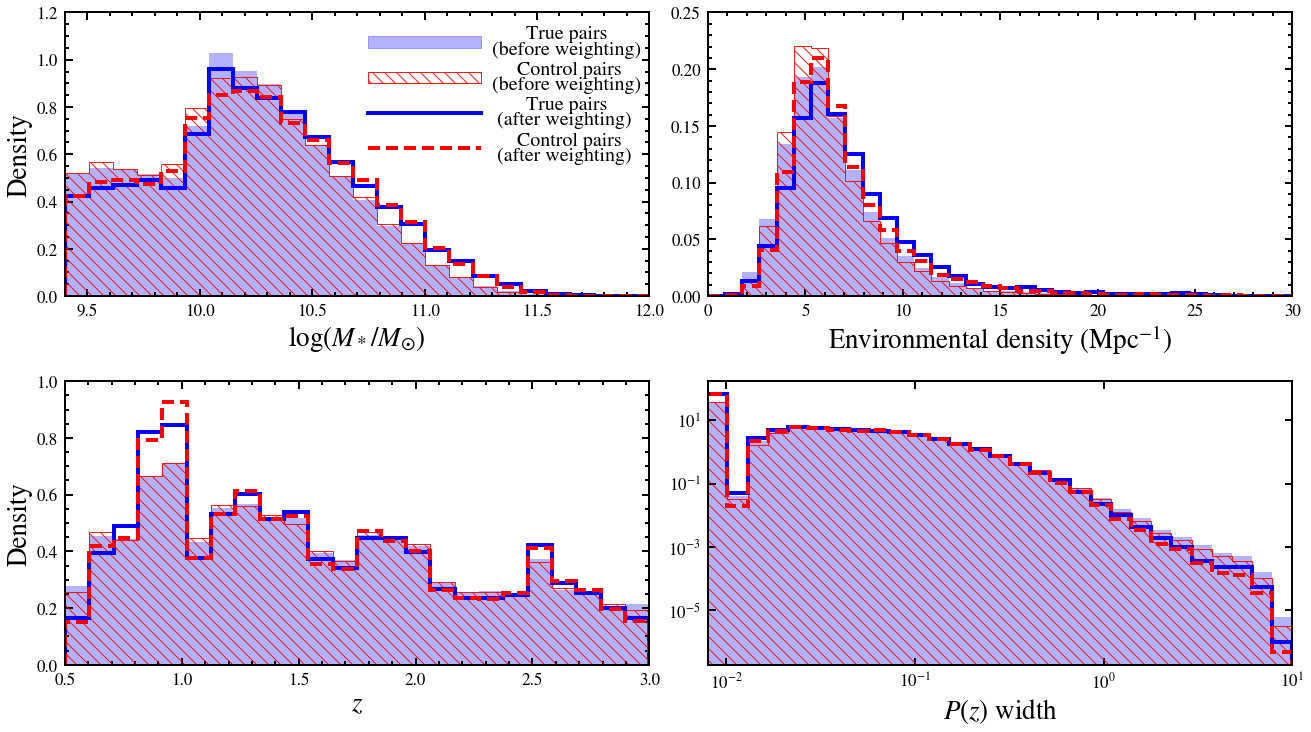

In [12]:
# all together now:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,12), sharey=False)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.1)
zbins = np.linspace(0.5,3,25)
mbins = np.linspace(9.4,12.5,30)  # may actually have the wrong weights here
ebins = np.linspace(0,30,35)
sbins = np.logspace(-2.1,1,30)
wbins = np.logspace(-20,0,200)
pweights = np.concatenate((rdf['pair_prob'],rdf['pair_prob']))
iweights = np.concatenate((cdf['Cp'],cdf['Cp']))
# mass
ax[0,0].hist(pmass, bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
ax[0,0].hist(imass, bins=mbins, density=True, color='red', alpha=0.9, histtype='step',
             hatch=r"\\", label='apples w/out weights')
ax[0,0].hist(pmass, bins=mbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4, label='pairs')
ax[0,0].hist(imass, bins=mbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)), label='controls')
ax[0,0].set_xlim(9.4,12)
# ax[0,0].legend(fontsize=20)

# hand-make legend()
ax[0,0].add_patch(Rectangle((10.75,1.05), 0.5, 0.05, facecolor='blue', edgecolor='blue', alpha=0.3))
ax[0,0].add_patch(Rectangle((10.75,0.9), 0.5, 0.05, facecolor='none', edgecolor='red', alpha=0.9, hatch=r"\\"))
ax[0,0].plot([10.75,11.25],[0.775,0.775], lw=4, color='blue')
ax[0,0].plot([10.75,11.25],[0.775-0.15,0.775-0.15], lw=4, color='red', linestyle=(0,(3,1.5)))

ax[0,0].text(11.45, 1.09, 'True pairs', fontsize=20)
ax[0,0].text(11.3, 1.025, '(before weighting)', fontsize=20)
ax[0,0].text(11.41, 1.09-0.15, 'Control pairs', fontsize=20)
ax[0,0].text(11.3, 1.025-0.15, '(before weighting)', fontsize=20)
ax[0,0].text(11.45, 1.09-0.3, 'True pairs', fontsize=20)
ax[0,0].text(11.32, 1.025-0.3, '(after weighting)', fontsize=20)
ax[0,0].text(11.41, 1.09-0.45, 'Control pairs', fontsize=20)
ax[0,0].text(11.32, 1.025-0.45, '(after weighting)', fontsize=20)

ax[0,0].set_ylabel('Density', fontsize=27)
ax[0,0].set_xlabel('log($M_*/M_☉$)', fontsize=27)

ax[0,0].set_ylim(0,1.2)
ax[0,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

### ---------------------------------------------------------------- ###

# redshift
ax[1,0].hist(pz, bins=zbins, density=True, color='blue', alpha=0.3)
ax[1,0].hist(iz, bins=zbins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[1,0].hist(pz, bins=zbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4)
ax[1,0].hist(iz, bins=zbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)))
ax[1,0].set_xlim(0.5, 3)

ax[1,0].set_ylabel('Density', fontsize=27)
ax[1,0].set_xlabel('$z$', fontsize=27)

ax[1,0].set_ylim(0,1)
ax[1,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

### ---------------------------------------------------------------- ###

# environment density:
ax[0,1].hist(penv, bins=ebins, density=True, color='blue', alpha=0.3)
ax[0,1].hist(ienv, bins=ebins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[0,1].hist(penv, bins=ebins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4)
ax[0,1].hist(ienv, bins=ebins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)))
ax[0,1].set_xlim(0, 30)

# ax[0,1].set_ylabel('Density', fontsize=25)
ax[0,1].set_xlabel('Environmental density (Mpc$^{-1}$)', fontsize=27)
ax[0,1].set_ylim(0,0.25)
ax[0,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

### ---------------------------------------------------------------- ###
# 2SIG
ax[1,1].hist(psig, bins=sbins, density=True, color='blue', alpha=0.3)
ax[1,1].hist(isig, bins=sbins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[1,1].hist(psig, bins=sbins, weights=pweights, density=True, color='blue', histtype='step', lw=4)
ax[1,1].hist(isig, bins=sbins, weights=iweights, density=True, color='red', histtype='step', lw=4, linestyle=(0,(3,1.5)))
ax[1,1].set_xlim(0.008, 10)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('$P(z)$ width', fontsize=27)
ax[1,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)


# # PdV:
# ax[1,1].hist(pweights, bins=wbins, density=True, color='blue',
#           histtype='step', lw=4)
# ax[1,1].hist(iweights, bins=wbins, histtype='step', color='red', 
#            density=True, lw=4, linestyle=(0,(3,1.5)))
# ax[1,1].plot([0.25,0.25],[0,1e12], color='black', linestyle=':')
# ax[1,1].set_xlim(1e-3, 1)
# ax[1,1].set_xscale('log')
# ax[1,1].set_yscale('log')

# # ax[1,1].set_ylabel('Density', fontsize=25)
# ax[1,1].set_xlabel('$P_{\Delta V}$', fontsize=27)

# ax[1,1].set_ylim(1e-3,100)
# ax[1,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
# ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
# ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
# ax[1,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)


# do the KS-test:
# D_m, p_m = ks_weighted(pmass, imass, pweights, iweights)
# D_z, p_z = ks_weighted(pz, iz, pweights, iweights)
# ax[0,0].set_title('D = {0} // p = {1}'.format(round(D_m,3), round(p_m,3)))
# ax[1,0].set_title('D = {0} // p = {1}'.format(round(D_z,3), round(p_z,3)))

# # plot distributions of weights:
# wei_bins = np.logspace(-21,0, 100)
# ax[1,1].hist(pweights, bins=wei_bins, histtype='step', lw=2, color='blue', density=False)
# ax[1,1].hist(iweights, bins=wei_bins, histtype='step', lw=2, color='red', density=False)
# ax[1,1].set_xscale('log')
# ax[1,1].set_xlabel('Pair Prob', fontsize=20)
# ax[1,1].set_ylabel('Counts', fontsize=20)

# plt.savefig('/data/c1029594/Figures/Pair_Paper/control_match.png', bbox_inches='tight')

plt.show()

/tmp/ipykernel_45584/3758125829.py:42: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('/data/c1029594/Figures/Pair_Paper/PdV_match.png', bbox_inches='tight')


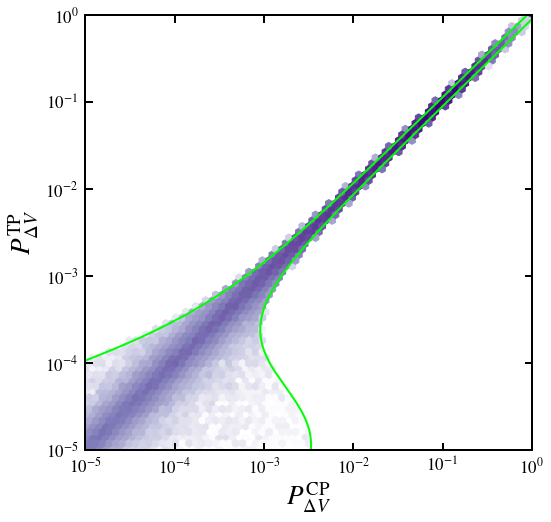

In [101]:
# can I plot a Pv vs Pv plot? <-- yeah just plot the weights against each other

def PP_diff_func(x):
    # input the value of Pp...
    # I have already tuned what this function should be...
    A = 5.24002529e-05
    C = 1.54419221e-04
    
    return C*(1/(x+A)) + 0.05

def Cp_Pp_low(Pp):
    A = 5.24002529e-05
    C = 1.54419221e-04
    return Pp / 10**((C/(Pp+A))+0.05)

def Cp_Pp_high(Pp):
    A = 5.24002529e-05
    C = 1.54419221e-04
    return Pp * 10**((C/(Pp+A))+0.05)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
# ax.scatter(iweights, np.repeat(pweights,3), s=1, color='mediumslateblue', alpha=0.2)
ax.hexbin(iweights, np.repeat(pweights,3), gridsize=300, bins='log', xscale='log', yscale='log', cmap='Purples')
x = np.logspace(-6,0,1000)
y1 = Cp_Pp_low(x)
y2 = Cp_Pp_high(x)
ax.plot(y1, x, color='lime', lw=2)
ax.plot(y2, x, color='lime', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5,1)
ax.set_ylim(1e-5,1)

ax.set_xlabel('$P^{\\rm CP}_{\Delta V}$', fontsize=27)
ax.set_ylabel('$P^{\\rm TP}_{\Delta V}$', fontsize=27)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

plt.savefig('/data/c1029594/Figures/Pair_Paper/PdV_match.png', bbox_inches='tight')

plt.show()

In [ ]:
def binomial_err(c, k, n):
    p_lower = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)
    return p_lower, p_upper

In [ ]:
# calculate errors correctly:
# get errors as numpy arrays
pXAGN_err0 = np.array([pXAGN_err[key] for key in pXAGN_err])
pDoAGN_err0 = np.array([pDoAGN_err[key] for key in pDoAGN_err])
poDoAGN_err0 = np.array([poDoAGN_err[key] for key in poDoAGN_err])
pStAGN_err0 = np.array([pStAGN_err[key] for key in pStAGN_err])
p_err0 = np.array([p_err[key] for key in p_err])
iXAGN_err0 = np.array([iXAGN_err[key] for key in iXAGN_err])
iDoAGN_err0 = np.array([iDoAGN_err[key] for key in iDoAGN_err])
ioDoAGN_err0 = np.array([ioDoAGN_err[key] for key in ioDoAGN_err])
iStAGN_err0 = np.array([iStAGN_err[key] for key in iStAGN_err])
i_err0 = np.array([i_err[key] for key in i_err])

pXAGN_count0 = np.array([pXAGN_count[key] for key in pXAGN_count])
pDoAGN_count0 = np.array([pDoAGN_count[key] for key in pDoAGN_count])
poDoAGN_count0 = np.array([poDoAGN_count[key] for key in poDoAGN_count])
pStAGN_count0 = np.array([pStAGN_count[key] for key in pStAGN_count])
iXAGN_count0 = np.array([iXAGN_count[key] for key in iXAGN_count])
iDoAGN_count0 = np.array([iDoAGN_count[key] for key in iDoAGN_count])
ioDoAGN_count0 = np.array([ioDoAGN_count[key] for key in ioDoAGN_count])
iStAGN_count0 = np.array([iStAGN_count[key] for key in iStAGN_count])

pXfrac_err = pXAGN_fracs * np.sqrt( (pXAGN_err0/pXAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pX_uerr = pXAGN_fracs + pXfrac_err
pX_lerr =  pXAGN_fracs - pXfrac_err
pDofrac_err = pDoAGN_fracs * np.sqrt( (pDoAGN_err0/pDoAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pDo_uerr = pDoAGN_fracs + pDofrac_err
pDo_lerr =  pDoAGN_fracs - pDofrac_err
pStfrac_err = pStAGN_fracs * np.sqrt( (pStAGN_err0/pStAGN_count0)**2 + (p_err0/tot_pairs)**2 )
pSt_uerr = pStAGN_fracs + pStfrac_err
pSt_lerr =  pStAGN_fracs - pStfrac_err

iXfrac_err = iXAGN_fracs * np.sqrt( (iXAGN_err0/iXAGN_count0)**2 + (i_err0/tot_isos)**2 )
iX_uerr = iXAGN_fracs + iXfrac_err
iX_lerr =  iXAGN_fracs - iXfrac_err
iDofrac_err = iDoAGN_fracs * np.sqrt( (iDoAGN_err0/iDoAGN_count0)**2 + (i_err0/tot_isos)**2 )
iDo_uerr = iDoAGN_fracs + iDofrac_err
iDo_lerr =  iDoAGN_fracs - iDofrac_err
iStfrac_err = iStAGN_fracs * np.sqrt( (iStAGN_err0/iStAGN_count0)**2 + (i_err0/tot_isos)**2 )
iSt_uerr = iStAGN_fracs + iStfrac_err
iSt_lerr =  iStAGN_fracs - iStfrac_err

# for obscured/unabscured:
p_obsc_frac = poDoAGN_count0 / pXAGN_count0
p_obsc_frac_err = p_obsc_frac * np.sqrt( (poDoAGN_err0/poDoAGN_count0)**2 + (pXAGN_err0/pXAGN_count0)**2 )
i_obsc_frac = ioDoAGN_count0 / iXAGN_count0
i_obsc_frac_err = i_obsc_frac * np.sqrt( (ioDoAGN_err0/ioDoAGN_count0)**2 + (iXAGN_err0/iXAGN_count0)**2 )

In [ ]:
p_obsc_frac, i_obsc_frac, p_obsc_frac_err, i_obsc_frac_err

In [ ]:
# obscured / unobscured fraction plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.scatter(kpc_meds, p_obsc_frac, s=100, color='cornflowerblue', marker='p', zorder=2, label='Pairs')
ax.errorbar(kpc_meds, p_obsc_frac, yerr=(p_obsc_frac_err), linestyle='None', 
            color='cornflowerblue', capsize=5, zorder=2)

ax.errorbar(kpc_meds, i_obsc_frac, yerr=(i_obsc_frac_err), linestyle='None', 
            color='black', capsize=5, zorder=1)
ax.scatter(kpc_meds, i_obsc_frac, s=100, edgecolor='black', marker='p', facecolor='white', zorder=1, label='Controls')

ax.scatter(70, 0.40, s=200, marker='p', color='cornflowerblue')
ax.scatter(70, 0.35, s=200, marker='p', color='white', edgecolor='black')
ax.text(75, .385, 'Pairs', fontsize=25)
ax.text(75, .335, 'Controls', fontsize=25)

ax.set_ylim(0,0.5)
ax.set_xlim(0,100)
# ax.legend(fontsize=25)

ax.set_xlabel('Projected Separation (kpc)', fontsize=20)
ax.set_ylabel('Obscured/Unobscured AGN', fontsize=20)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/figs/obscfrac.png', bbox_inches='tight')

plt.show()

In [ ]:
# # plot IR full detection fraction
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# ax.scatter(kpc_meds, pdet_fracs, s=200, color='blue', zorder=2)
# ax.errorbar(kpc_meds, pdet_fracs, yerr=(pdet_frac_err), xerr=vwidth/2, linestyle='None', 
#             color='blue', capsize=5, zorder=2)

# ax.scatter(kpc_meds, idet_fracs, s=200, edgecolor='cornflowerblue', facecolor='None', zorder=1)
# ax.errorbar(kpc_meds, idet_fracs, yerr=(idet_frac_err), xerr=vwidth/2, linestyle='None', 
#             color='cornflowerblue', capsize=5, zorder=1)

# ax.set_ylim(0,1)
# ax.set_xlim(0,120)

# ax.set_xlabel('projected separation (kpc)', fontsize=15)
# ax.set_ylabel('IRAC full detection fraction', fontsize=15)

# plt.show() # note that this is with weights

# detaction fractions for COSMOS are much lower, but there seems to be no trend with proj sep (aside from with mass)
# what is the deal with COSMOS? low IR AGN fractions in lowest bin, but no quality difference in the detections...
# --> or at least there's no difference in their IRAC quality...
# what is driving the suppression of IR AGN in close separations that isn't seen in any other bin...
# Could be:
# ---> the PdA for COSMOS behaves differently for whatever reason (fit code for use_PdA == False: CANDELS+COSMOS consistent)
# ---> COSMOS spec-zs behave differently (check the just phot-z COSMOS: RUNNING)
# ---> some COSMOS data loading error (look in topcat: not a spatial issue with the data, mix up fluxes maybe?)
# ---> take a look at the first bin distributions (only noticeable difference is CANDELS has more high-z pairs)
# ---> try making a subset of just Donley AGN that are counted in each bin?
# ---> could it be the SPLASH IR fluxes are poor? (try splitting IRAC ch1 vs SPLASH ch1)
# ---> IRAC and SPLASH mostly consistent in flux, vary different in flux err (at least in first two channels: look at FARMER)
# ---> seems that IRAC flux errors are much less at least in CH1+2...
# ---> should use FARMER + EAZY for consistency, as this (like the CANDELS PDFs) ised all IRAC channels.
# -------> I believe this is the cause of the COSMOS inconsistencies (EAZY was used. by Wyuts)



NameError: name 'minor' is not defined

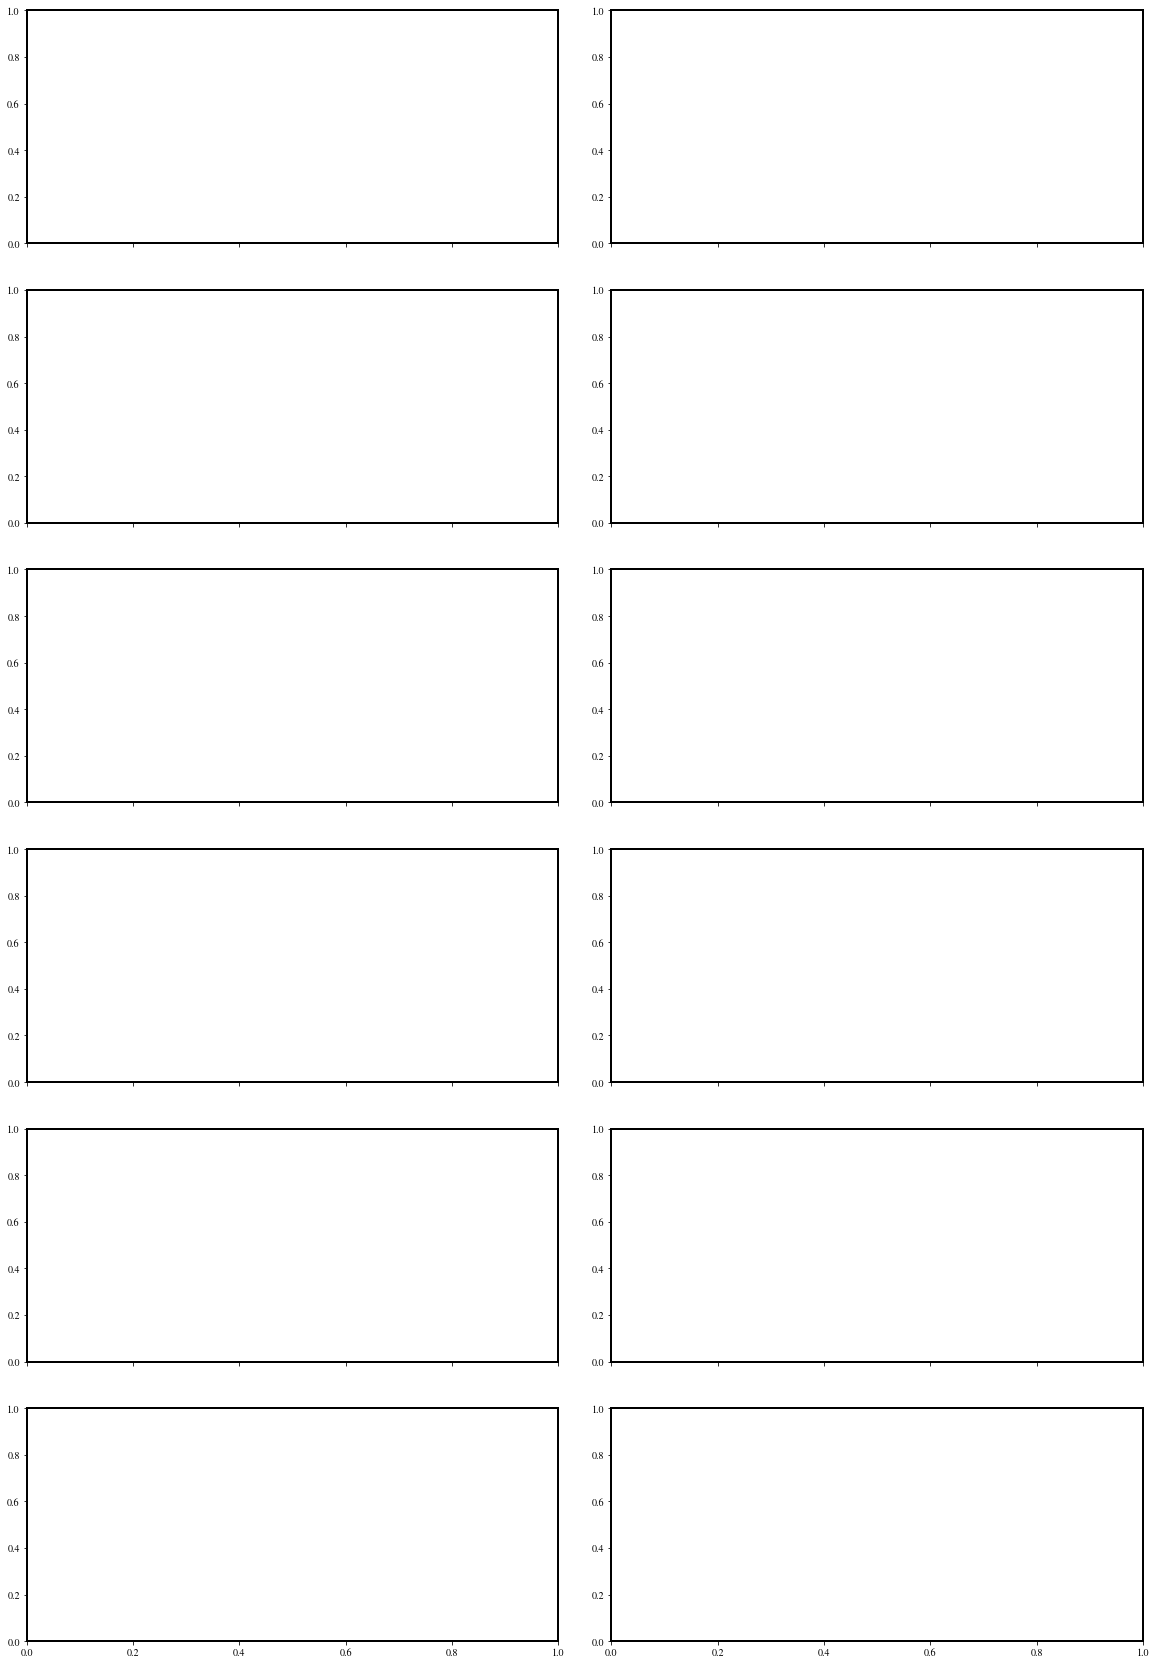

In [10]:

# AGNs = ['lowLX','IRlowLX','midLX','IRmidLX','hiLX','IRhiLX','allLX','IRallLX','IR']
AGNs = ['lowLX','midLX','hiLX','allLX','IRallLX','IR']
# AGNs = ['midLX','hiLX','allLX' ,'IRallLX','IR']

kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]

# plot AGN fractions / enhancement master plot:
fig, ax = plt.subplots(nrows=len(AGNs), ncols=2, figsize=(20,30), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.2)

# for loop for mass samples
for i, AGN in enumerate(AGNs):
    maj_frac = np.array([major[AGN+'_frac'][col] for col in major[AGN+'_frac']])
    maj_se = np.array([major[AGN+'_se'][col] for col in major[AGN+'_se']])
    imaj_frac = np.array([major['i'+AGN+'_frac'][col] for col in major['i'+AGN+'_frac']])
    imaj_se = np.array([major['i'+AGN+'_se'][col] for col in major['i'+AGN+'_se']])
    min_frac = np.array([minor[AGN+'_frac'][col] for col in minor[AGN+'_frac']])
    min_se = np.array([minor[AGN+'_se'][col] for col in minor[AGN+'_se']])
    imin_frac = np.array([minor['i'+AGN+'_frac'][col] for col in minor['i'+AGN+'_frac']])
    imin_se = np.array([minor['i'+AGN+'_se'][col] for col in minor['i'+AGN+'_se']])
    majmin_frac = np.array([major_minor[AGN+'_frac'][col] for col in major_minor[AGN+'_frac']])
    majmin_se = np.array([major_minor[AGN+'_se'][col] for col in major_minor[AGN+'_se']])
    imajmin_frac = np.array([major_minor['i'+AGN+'_frac'][col] for col in major_minor['i'+AGN+'_frac']])
    imajmin_se = np.array([major_minor['i'+AGN+'_se'][col] for col in major_minor['i'+AGN+'_se']])
    
    ax[i,0].scatter(kpc_meds-4, maj_frac, s=100, color='blue')
    ax[i,0].errorbar(kpc_meds-4, maj_frac, yerr=maj_se, color='blue', capsize=5)
    ax[i,0].scatter(kpc_meds-4, imaj_frac, s=100, edgecolor='blue', facecolor='none')
    ax[i,0].errorbar(kpc_meds-4, imaj_frac, yerr=imaj_se, color='blue', capsize=5, linestyle='--')
    ax[i,0].scatter(kpc_meds, min_frac, s=100, color='green', marker='s')
    ax[i,0].errorbar(kpc_meds, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds, imin_frac, s=100, edgecolor='green', facecolor='none', marker='s')
    ax[i,0].errorbar(kpc_meds, imin_frac, yerr=imin_se, color='green', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds+4, majmin_frac, s=100, color='purple', marker='^')
    ax[i,0].errorbar(kpc_meds+4, majmin_frac, yerr=majmin_se, color='purple', capsize=5, linestyle='none')
    ax[i,0].scatter(kpc_meds+4, imajmin_frac, s=100, edgecolor='purple', facecolor='none', marker='^')
    ax[i,0].errorbar(kpc_meds+4, imajmin_frac, yerr=imajmin_se, color='purple', capsize=5, linestyle='none')
    
    majmax = np.max([maj_frac+maj_se, imaj_frac+imaj_se])
    minmax = np.max([min_frac+min_se, imin_frac+imin_se])
    majminmax = np.max([majmin_frac+majmin_se, imajmin_frac+imajmin_se])
    xmax = np.max([majmax, minmax, majminmax])
    
    ax[i,0].set_title(AGN, fontsize=20)
    ax[i,0].set_xlim(0,100)
    ax[i,0].set_ylim(0,xmax*1.25)
    # ax[i,0].set_xlabel('projected separation (kpc)')
    ax[i,0].set_ylabel('Weighted AGN fraction', fontsize=17)
    ax[i,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
    ax[i,0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    min_enh = min_frac / imin_frac
    majmin_enh = majmin_frac / imajmin_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    if AGN == 'hiLX':
        print(maj_enh_se)
    min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
    majmin_enh_se = majmin_enh * np.sqrt( (majmin_se/majmin_frac)**2 + (imajmin_se/imajmin_frac)**2 )
    if AGN == 'allLX':
        IRallLX_se = maj_enh_se
    
    ax[i,1].scatter(kpc_meds-4, maj_enh, s=100, color='blue', label='major')
    ax[i,1].errorbar(kpc_meds-4, maj_enh, yerr=maj_enh_se, color='blue', capsize=5)
    ax[i,1].scatter(kpc_meds, min_enh, s=100, color='green', marker='s', label='minor')
    ax[i,1].errorbar(kpc_meds, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
    ax[i,1].scatter(kpc_meds+4, majmin_enh, s=100, color='purple', marker='^', label='major and minor')
    ax[i,1].errorbar(kpc_meds+4, majmin_enh, yerr=majmin_enh_se, color='purple', capsize=5, linestyle='none')
    ax[i,1].plot([0,100],[1,1], color='black', linestyle='--')
    
    ax[i,1].set_title(AGN, fontsize=20)
    ax[i,1].set_xlim(0,100)
    ax[i,1].set_ylim(0,4)
    # ax[i,1].set_xlabel('projected separation (kpc)')
    ax[i,1].set_ylabel('AGN enhancement', fontsize=17)
    ax[i,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
    ax[i,1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i,1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    for kpc in kpc_meds:
        ax[i,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
        ax[i,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
        
        
ax[len(AGNs)-1,0].set_xlabel('projected separation (kpc)', fontsize=20)
ax[len(AGNs)-1,1].set_xlabel('projected separation (kpc)', fontsize=20)

ax[0,1].legend(loc=1, fontsize=20)
        
ax[0,0].set_xlim(0,100)


# X-ray -> three tiers
# ax[0].scatter(kpc_meds, pXAGN_fracs, color='blue')
# ax[0].errorbar(kpc_meds, pXAGN_fracs, yerr=(pXfrac_err,pXfrac_err), linestyle="None", capsize=10, color='blue')
# ax[0].scatter(kpc_meds, iXAGN_fracs, s=50, facecolor='none', edgecolor='red')
# ax[0].errorbar(kpc_meds, iXAGN_fracs, yerr=(iXfrac_err,iXfrac_err), linestyle="None", capsize=10, color='red')
# ax[0].set_ylim(0, 0.199)
# ax[0].set_ylabel('AGN fraction', fontsize=15)
# # ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
# ax[0].text(2,0.17,'X-ray AGN', fontsize=25)

# IR
# ax[1].scatter(kpc_meds, pDoAGN_fracs, color='blue')
# ax[1].errorbar(kpc_meds, pDoAGN_fracs, yerr=(pDofrac_err,pDofrac_err), linestyle="None", capsize=10, color='blue')
# ax[1].scatter(kpc_meds, iDoAGN_fracs, s=50, facecolor='none', edgecolor='red')
# ax[1].errorbar(kpc_meds, iDoAGN_fracs, yerr=(iDofrac_err,iDofrac_err), linestyle="None", capsize=10, color='red')
# ax[1].set_ylim(0, 0.199)
# # ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
# ax[1].set_ylabel('AGN fraction', fontsize=15)
# ax[1].text(2,0.17,'Donley AGN', fontsize=25)


# ax[0].set_xticks(np.arange(0,150,20))
# ax[0].set_xticklabels(np.arange(0,150,20),fontsize=15)
# ax[0].set_yticks(np.arange(0,0.12,0.02))
# ax[0].set_yticklabels(np.arange(0,0.12,0.02),fontsize=15)


# ax[1].set_xticks(np.arange(0,150,20))
# ax[1].set_xticklabels(np.arange(0,150,20),fontsize=15)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ALL_12.10_p.png',
#            bbox_inches='tight')

# plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/Sean_Thesis_Code/output_figures/CANDELS_PP0.1.png',
#            bbox_inches='tight')

plt.show()

In [91]:
# major['iIRallLX_frac']
0.012482491416366691 / 0.006853367478263544

1.8213661321907422

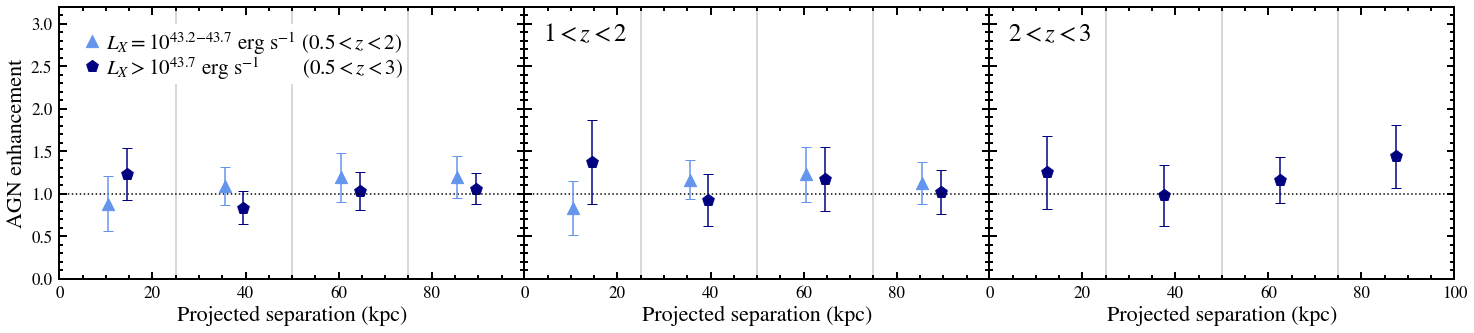

In [9]:
# make redshift cut plots for different LX groups:
# AGNs = ['allLX_zlo', 'allLX_zmid', 'allLX_zhi',  'hiLX_zlo', 'hiLX_zmid', 'hiLX_zhi', 'midLX_zlo', 'midLX_zmid']
AGNs = ['midLX', 'midLX_zmid', 'hiLX', 'hiLX_zmid', 'hiLX_zhi']

# add in the full sample dictionary entries into the z_major dict:
ps_major_z['midLX_frac'] = ps_major['midLX_frac']
ps_major_z['midLX_se'] = ps_major['midLX_se']
ps_major_z['imidLX_frac'] = ps_major['imidLX_frac']
ps_major_z['imidLX_se'] = ps_major['imidLX_se']
ps_major_z['hiLX_frac'] = ps_major['hiLX_frac']
ps_major_z['hiLX_se'] = ps_major['hiLX_se']
ps_major_z['ihiLX_frac'] = ps_major['ihiLX_frac']
ps_major_z['ihiLX_se'] = ps_major['ihiLX_se']

kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]

colors = ['cornflowerblue', 'navy']
markers = ['^', 'p']

# plot AGN fractions / enhancement master plot:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0)
# fig.subplots_adjust(hspace=0.2)
call, cmid, chi = 0, 0, 0

# add some additional plots
ax[0].plot([-5,105],[1,1], color='black', linestyle=':')
ax[1].plot([-5,105],[1,1], color='black', linestyle=':')
ax[2].plot([-5,105],[1,1], color='black', linestyle=':')

# maybe just plot enhancement:
for i, AGN in enumerate(AGNs):
    maj_frac = np.array([ps_major_z[AGN+'_frac'][col] for col in ps_major_z[AGN+'_frac']])
    maj_se = np.array([ps_major_z[AGN+'_se'][col] for col in ps_major_z[AGN+'_se']])
    imaj_frac = np.array([ps_major_z['i'+AGN+'_frac'][col] for col in ps_major_z['i'+AGN+'_frac']])
    imaj_se = np.array([ps_major_z['i'+AGN+'_se'][col] for col in ps_major_z['i'+AGN+'_se']])
    
    # propogate errors linearly
    maj_enh = maj_frac / imaj_frac
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    # if AGN == 'hiLX':
    #     print(maj_enh, maj_enh_se)
    
    # read some strings:
    read = AGN.split('z')
    # if read[-1] == 'lo':
    #     clo += 1
    #     ax[0].scatter(kpc_meds+(2*(2*(clo-1)-1)), maj_enh, s=150, color=colors[clo-1], marker=markers[clo-1])
    #     # ax[0].scatter(kpc_meds+(4*(clo-2)), maj_enh, s=150, color=colors[clo-1], marker=markers[clo-1])
    #     ax[0].errorbar(kpc_meds+(2*(2*(clo-1)-1)), maj_enh, yerr=maj_enh_se, color=colors[clo-1], capsize=5, linestyle='none')
    if read[-1] == 'mid':
        cmid += 1
        ax[1].scatter(kpc_meds+(2*(2*(cmid-1)-1)), maj_enh, s=150, color=colors[cmid-1], marker=markers[cmid-1])
        ax[1].errorbar(kpc_meds+(2*(2*(cmid-1)-1)), maj_enh, yerr=maj_enh_se, color=colors[cmid-1], capsize=5, linestyle='none')
    elif read[-1] == 'hi':
        chi += 1
        ax[2].scatter(kpc_meds, maj_enh, s=150, color=colors[chi], marker=markers[chi])
        ax[2].errorbar(kpc_meds, maj_enh, yerr=maj_enh_se, color=colors[chi], capsize=5, linestyle='none')
    else:
        # plot full sample on axis 0
        call+=1
        ax[0].scatter(kpc_meds+(2*(2*(call-1)-1)), maj_enh, s=150, color=colors[call-1], marker=markers[call-1])
        ax[0].errorbar(kpc_meds+(2*(2*(call-1)-1)), maj_enh, yerr=maj_enh_se, color=colors[call-1], capsize=5, linestyle='none')
        

for kpc in kpc_meds:
    ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    ax[2].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)

ax[0].set_xlim(0,99.9)
ax[0].set_ylim(0,3.2)
ax[0].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[0].set_ylabel('AGN enhancement', fontsize=22)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

ax[1].set_xlim(0,99.9)
# ax[1].set_ylim(0,3.2)
ax[1].set_xlabel('Projected separation (kpc)', fontsize=22)
# ax[1].set_ylabel('AGN enhancement', fontsize=20)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

ax[2].set_xlim(0,100)
# ax[1].set_ylim(0,3.2)
ax[2].set_xlabel('Projected separation (kpc)', fontsize=22)
# ax[1].set_ylabel('AGN enhancement', fontsize=20)
ax[2].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# add some white rectangles for readability
ax[0].add_patch(Rectangle((4,2.3), 50, 0.7, facecolor='white', edgecolor='white', alpha=1, zorder=2))
# ax[0].add_patch(Rectangle((55,2.3), 30, 0.7, facecolor='white', edgecolor='white', alpha=1, zorder=2))

# ax[1].add_patch(Rectangle((4,2.65), 30, 0.45, facecolor='white', edgecolor='white', alpha=1, zorder=2))
# ax[2].add_patch(Rectangle((4,2.65), 30, 0.45, facecolor='white', edgecolor='white', alpha=1, zorder=2))


# add some text:
# ax[0].text(5, 2.8, '', fontsize=25)
ax[1].text(4, 2.8, '$1 < z < 2$', fontsize=25)
ax[2].text(4, 2.8, '$2 < z < 3$', fontsize=25)

# and legend:
# ax[0].scatter(55, 2.9, s=150, color='blue', marker='o', zorder=3)
# ax[0].text(60, 2.8, '$L_X > 10^{42}$', fontsize=22)
ax[0].scatter(7, 2.3+0.2, s=150, color='navy', marker='p', zorder=3)
ax[0].text(10, 2.2+0.2, '$L_X > 10^{43.7}$ erg s$^{-1}$        ($0.5 < z < 3$)', fontsize=21) # '$L_X = 10^{43.2{-}43.7}$'
ax[0].scatter(7, 2.6+0.2, s=150, color='cornflowerblue', marker='^', zorder=3)
ax[0].text(10, 2.5+0.2, '$L_X = 10^{43.2{-}43.7}$ erg s$^{-1}$ ($0.5 < z < 2$)', fontsize=21)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_MIDLX-HILX3.png',
#            bbox_inches='tight')
    
plt.show()

In [10]:
# estimate obsc fracs from bootstrap:
pobsc_se = np.zeros(len(ps_major['IRallLX_count']))
iobsc_se = np.zeros(len(ps_major['iIRallLX_count'])) # are both the same
for i, key in enumerate(ps_major['IRallLX_count'].keys()):
    pobsc_se[i] = bootstrap_obsc(ps_obsc_dict['IRallLX_obs'][key], ps_obsc_dict['allLX_obs'][key], ps_obsc_dict['IRallLX_PP'][key])
    iobsc_se[i] = bootstrap_obsc(ps_obsc_dict['iIRallLX_obs'][key], ps_obsc_dict['iallLX_obs'][key], ps_obsc_dict['iIRallLX_PP'][key])

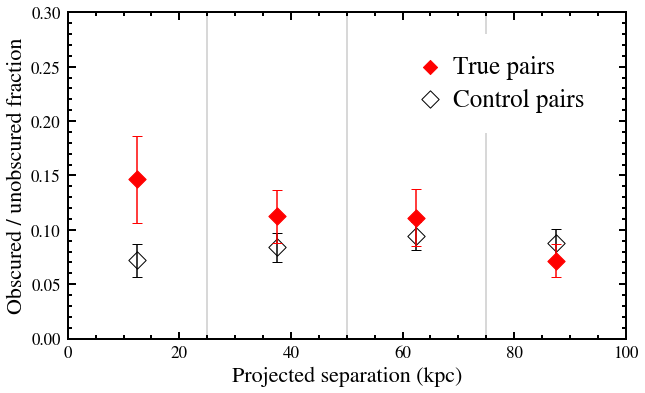

In [12]:
# focus on getting the obscured / unobscured fraction
# for each bin, it's purely weighted ratio of obscured counts / X-ray count
# need to get pair probs
### ~~~ check PP consistency ~~~ ###
# # estimate obsc fracs from bootstrap:
# pobsc_se = np.zeros(len(major['IRallLX_count']))
# iobsc_se = np.zeros(len(major['iIRallLX_count'])) # are both the same
# for i, key in enumerate(major['IRallLX_count'].keys()):
#     pobsc_se[i] = bootstrap_obsc(obsc_dict['IRallLX_obs'][key], obsc_dict['allLX_obs'][key], obsc_dict['IRallLX_PP'][key])
#     iobsc_se[i] = bootstrap_obsc(obsc_dict['iIRallLX_obs'][key], obsc_dict['iallLX_obs'][key], obsc_dict['iIRallLX_PP'][key]) # check PP consistency

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True, sharex=True)

maj_frac_obsc = np.array([ps_major['IRallLX_count'][col] for col in ps_major['IRallLX_count']])
maj_frac_LX = np.array([ps_major['allLX_count'][col] for col in ps_major['allLX_count']])
obsc_frac = maj_frac_obsc / maj_frac_LX

imaj_frac_obsc = np.array([ps_major['iIRallLX_count'][col] for col in ps_major['iIRallLX_count']])
imaj_frac_LX = np.array([ps_major['iallLX_count'][col] for col in ps_major['iallLX_count']])
iobsc_frac = imaj_frac_obsc / imaj_frac_LX

ax.scatter(kpc_meds, obsc_frac, s=150, marker='D', color='red', zorder=1)
ax.errorbar(kpc_meds, obsc_frac, yerr=pobsc_se, capsize=5, linestyle='none', color='red', zorder=1)
ax.scatter(kpc_meds, iobsc_frac, s=150, marker='D', edgecolor='black', facecolor='white', zorder=0.5)
ax.errorbar(kpc_meds, iobsc_frac, yerr=iobsc_se, capsize=5, linestyle='none', color='black', zorder=0.5)

# what do I do for the errors here --> just bootstrap the obscured fraction just as before
# need to pass obs and PP for both?

for kpc in kpc_meds:
    ax.plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    
# build legend
ax.add_patch(Rectangle((69,0.19), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=2))
ax.scatter(65, 0.25, s=100, marker='D', color='red')
ax.scatter(65, 0.22, s=150, marker='D', edgecolor='black', facecolor='white')
ax.text(69, 0.244, 'True pairs', fontsize=25)
ax.text(69, 0.214, 'Control pairs', fontsize=25)

ax.set_xlim(0,100)
ax.set_ylim(0,0.3)
ax.set_xlabel('Projected separation (kpc)', fontsize=22)
ax.set_ylabel('Obscured / unobscured fraction', fontsize=22)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_OBSC-FRAC3.png',
#            bbox_inches='tight')

plt.show()

In [37]:
# extract the info for plotting:
obsc_PP = np.array([ps_obsc_dict['IRallLX_PP'][key] for key in ps_obsc_dict['IRallLX_PP'].keys()])
obscLX_obs = np.array([ps_obsc_dict['allLX_obs'][key] for key in ps_obsc_dict['allLX_obs'].keys()])
obscIR_obs = np.array([ps_obsc_dict['IRallLX_obs'][key] for key in ps_obsc_dict['IRallLX_obs'].keys()])
obscLX_sumP = obsc_PP * obscLX_obs
obscIR_sumP = obsc_PP * obscIR_obs

# and for control pairs
iobsc_PP = np.array([ps_obsc_dict['iIRallLX_PP'][key] for key in ps_obsc_dict['iIRallLX_PP'].keys()])
iobscLX_obs = np.array([ps_obsc_dict['iallLX_obs'][key] for key in ps_obsc_dict['iallLX_obs'].keys()])
iobscIR_obs = np.array([ps_obsc_dict['iIRallLX_obs'][key] for key in ps_obsc_dict['iIRallLX_obs'].keys()])
iobscLX_sumP = iobsc_PP * iobscLX_obs
iobscIR_sumP = iobsc_PP * iobscIR_obs
# np.sum(iobscIR_sumP, axis=1)

print(iobsc_se)

[0.01394859 0.01293568 0.01212765 0.01404045]


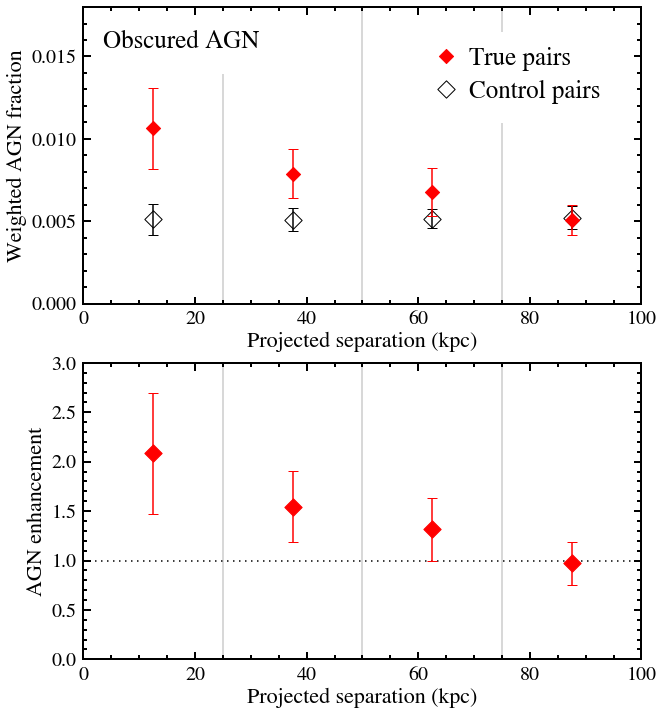

In [15]:
# plot obscured AGN enhancement
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12), sharey=False)
fig.subplots_adjust(wspace=0)

AGNs = ['IRallLX'] # should look at these bootstrapping distributions
kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]

for i, AGN in enumerate(AGNs):
    maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
    maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
    imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
    imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
    
    ax[0].scatter(kpc_meds, maj_frac, s=100, marker='D', color='red', zorder=1)
    ax[0].errorbar(kpc_meds, maj_frac, yerr=maj_se, color='red', capsize=5, linestyle='none', zorder=1)
    ax[0].scatter(kpc_meds, imaj_frac, s=150, marker='D', edgecolor='black', facecolor='white', zorder=0.5)
    ax[0].errorbar(kpc_meds, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
    
    ax[0].set_xlim(0,100)
    ax[0].set_ylim(0,0.018)
    ax[0].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[0].set_ylabel('Weighted AGN fraction', fontsize=22)
    ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    ax[1].scatter(kpc_meds, maj_enh, marker='D', s=150, color='red')
    ax[1].errorbar(kpc_meds, maj_enh, yerr=maj_enh_se, color='red', capsize=5, linestyle='none')
    ax[1].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
    
    ax[1].set_xlim(0,100)
    ax[1].set_ylim(0,3)
    ax[1].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[1].set_ylabel('AGN enhancement', fontsize=22)
    ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
# add vertical lines
for kpc in kpc_meds:
    ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    
ax[0].add_patch(Rectangle((2,0.014), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[0].text(3.5, 0.0155, 'Obscured AGN', fontsize=25)

# build legend
ax[0].add_patch(Rectangle((69,0.011), 25, 0.0055, facecolor='white', edgecolor='white', alpha=1, zorder=2))
ax[0].scatter(65, 0.015, s=100, marker='D', color='red')
ax[0].scatter(65, 0.013, s=150, marker='D', edgecolor='black', facecolor='white')
ax[0].text(69, 0.0145, 'True pairs', fontsize=25)
ax[0].text(69, 0.0125, 'Control pairs', fontsize=25)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_OBSC-ENH3.png',
#            bbox_inches='tight')
    
plt.show()

In [14]:
maj_enh, maj_enh_se

(array([2.08450088, 1.54663768, 1.31510305, 0.97262352]),
 array([0.60934435, 0.36223314, 0.31835798, 0.21820231]))

In [10]:
# the plot below is gonna have minor and major fracs and enh for ps and p methods
# first need to get the points from Shah to plot alongside:
Shah_X = np.array([0.94, 1.06, 1.19, 0.86])
Shah_Xuer = np.array([0.21, 0.23, 0.30, 0.18])
Shah_Xler = np.array([0.16, 0.18, 0.22, 0.14])
Shah_IR = np.array([1.00, 1.90, 1.25, 0.75])
Shah_IRuer = np.array([0.58, 1.25, 0.94, 0.53])
Shah_IRler = np.array([0.31, 0.65, 0.44, 0.25])

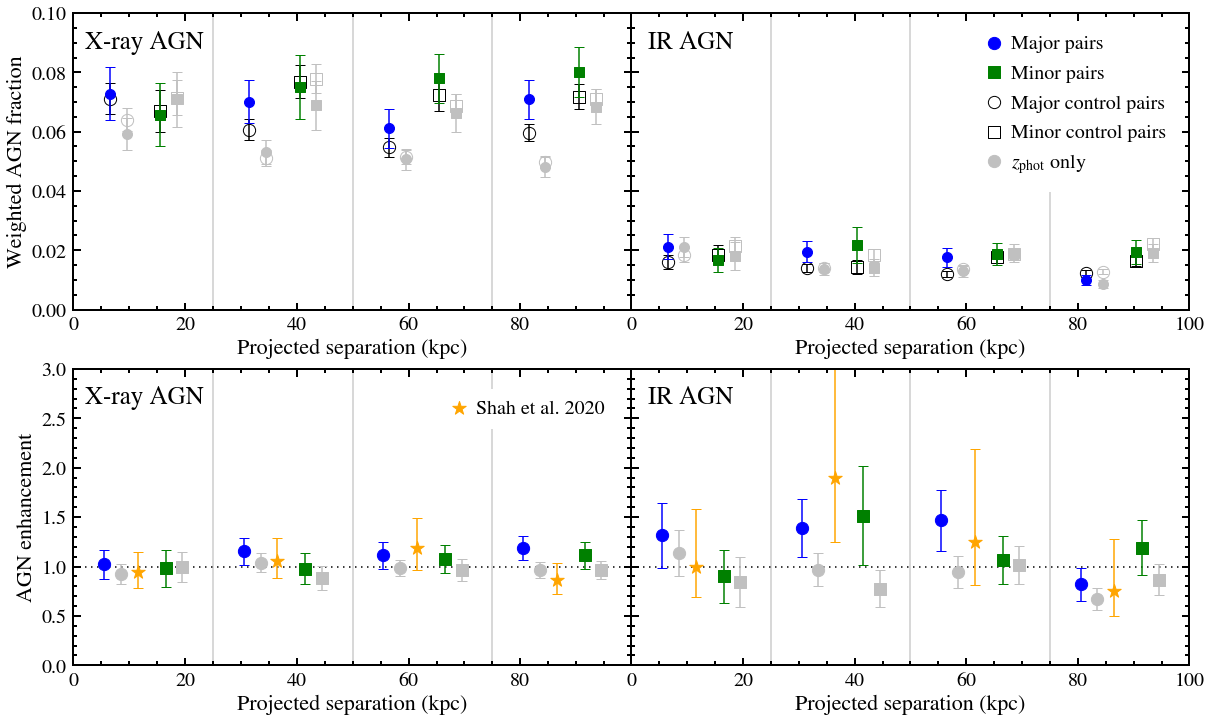

In [15]:
#  ---> All LX, split major and minor
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12), sharey=False)
fig.subplots_adjust(wspace=0)

AGNs = ['allLX'] # should look at these bootstrapping distributions
kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]

for i, AGN in enumerate(AGNs):
    maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
    maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
    imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
    imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
    min_frac = np.array([ps_minor[AGN+'_frac'][col] for col in ps_minor[AGN+'_frac']])
    min_se = np.array([ps_minor[AGN+'_se'][col] for col in ps_minor[AGN+'_se']])
    imin_frac = np.array([ps_minor['i'+AGN+'_frac'][col] for col in ps_minor['i'+AGN+'_frac']])
    imin_se = np.array([ps_minor['i'+AGN+'_se'][col] for col in ps_minor['i'+AGN+'_se']])
    
    p_maj_frac = np.array([p_major[AGN+'_frac'][col] for col in p_major[AGN+'_frac']])
    p_maj_se = np.array([p_major[AGN+'_se'][col] for col in p_major[AGN+'_se']])
    p_imaj_frac = np.array([p_major['i'+AGN+'_frac'][col] for col in p_major['i'+AGN+'_frac']])
    p_imaj_se = np.array([p_major['i'+AGN+'_se'][col] for col in p_major['i'+AGN+'_se']])
    p_min_frac = np.array([p_minor[AGN+'_frac'][col] for col in p_minor[AGN+'_frac']])
    p_min_se = np.array([p_minor[AGN+'_se'][col] for col in p_minor[AGN+'_se']])
    p_imin_frac = np.array([p_minor['i'+AGN+'_frac'][col] for col in p_minor['i'+AGN+'_frac']])
    p_imin_se = np.array([p_minor['i'+AGN+'_se'][col] for col in p_minor['i'+AGN+'_se']])

    ax[0,0].scatter(kpc_meds-6, maj_frac, s=100, color='blue', zorder=1)
    ax[0,0].errorbar(kpc_meds-6, maj_frac, yerr=maj_se, color='blue', capsize=5, linestyle='none', zorder=1)
    ax[0,0].scatter(kpc_meds-6, imaj_frac, s=150, edgecolor='black', facecolor='white', zorder=0.5)
    ax[0,0].errorbar(kpc_meds-6, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
    ax[0,0].scatter(kpc_meds+3, min_frac, s=100, color='green', marker='s', zorder=1)
    ax[0,0].errorbar(kpc_meds+3, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none', zorder=1)
    ax[0,0].scatter(kpc_meds+3, imin_frac, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.5)
    ax[0,0].errorbar(kpc_meds+3, imin_frac, yerr=imin_se, color='black', capsize=5, linestyle='none', zorder=0.5)
    
    ax[0,0].scatter(kpc_meds-3, p_maj_frac, s=100, color='silver', zorder=1)
    ax[0,0].errorbar(kpc_meds-3, p_maj_frac, yerr=p_maj_se, color='silver', capsize=5, linestyle='none', zorder=1)
    ax[0,0].scatter(kpc_meds-3, p_imaj_frac, s=150, edgecolor='silver', facecolor='white', zorder=0.5)
    ax[0,0].errorbar(kpc_meds-3, p_imaj_frac, yerr=p_imaj_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
    ax[0,0].scatter(kpc_meds+6, p_min_frac, s=100, color='silver', marker='s', zorder=1)
    ax[0,0].errorbar(kpc_meds+6, p_min_frac, yerr=p_min_se, color='silver', capsize=5, linestyle='none', zorder=1)
    ax[0,0].scatter(kpc_meds+6, p_imin_frac, s=150, edgecolor='silver', facecolor='white', marker='s', zorder=0.5)
    ax[0,0].errorbar(kpc_meds+6, p_imin_frac, yerr=p_imin_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
    
    
    # ax[0].set_title(AGN, fontsize=20)
    ax[0,0].set_xlim(0,99.9)
    ax[0,0].set_ylim(0,0.1)
    ax[0,0].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[0,0].set_ylabel('Weighted AGN fraction', fontsize=22)
    ax[0,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    min_enh = min_frac / imin_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
    
    p_maj_enh = p_maj_frac / p_imaj_frac
    p_min_enh = p_min_frac / p_imin_frac
    # propogate errors linearly
    p_maj_enh_se = p_maj_enh * np.sqrt( (p_maj_se/p_maj_frac)**2 + (p_imaj_se/p_imaj_frac)**2 )
    p_min_enh_se = p_min_enh * np.sqrt( (p_min_se/p_min_frac)**2 + (p_imin_se/p_imin_frac)**2 )
    
    ax[1,0].scatter(kpc_meds-7, maj_enh, s=150, color='blue', label='major')
    ax[1,0].errorbar(kpc_meds-7, maj_enh, yerr=maj_enh_se, color='blue', capsize=5, linestyle='none')
    ax[1,0].scatter(kpc_meds+4, min_enh, s=150, color='green', marker='s', label='minor')
    ax[1,0].errorbar(kpc_meds+4, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
    # ax[1].plot([0,100],[1,1], color='black', linestyle=':', zorder=0)
    
    ax[1,0].scatter(kpc_meds-4, p_maj_enh, s=150, color='silver', label='major')
    ax[1,0].errorbar(kpc_meds-4, p_maj_enh, yerr=p_maj_enh_se, color='silver', capsize=5, linestyle='none')
    ax[1,0].scatter(kpc_meds+7, p_min_enh, s=150, color='silver', marker='s', label='minor')
    ax[1,0].errorbar(kpc_meds+7, p_min_enh, yerr=p_min_enh_se, color='silver', capsize=5, linestyle='none')
    ax[1,0].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
    
    # ax[1].set_title(AGN, fontsize=20)
    ax[1,0].set_xlim(0,99.9)
    ax[1,0].set_ylim(0,3)
    ax[1,0].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[1,0].set_ylabel('AGN enhancement', fontsize=22)
    ax[1,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ IR AGN ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
    # for loop kinda pointless here but whatever
    AGN = 'IR'
    maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
    maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
    imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
    imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
    min_frac = np.array([ps_minor[AGN+'_frac'][col] for col in ps_minor[AGN+'_frac']])
    min_se = np.array([ps_minor[AGN+'_se'][col] for col in ps_minor[AGN+'_se']])
    imin_frac = np.array([ps_minor['i'+AGN+'_frac'][col] for col in ps_minor['i'+AGN+'_frac']])
    imin_se = np.array([ps_minor['i'+AGN+'_se'][col] for col in ps_minor['i'+AGN+'_se']])
    
    p_maj_frac = np.array([p_major[AGN+'_frac'][col] for col in p_major[AGN+'_frac']])
    p_maj_se = np.array([p_major[AGN+'_se'][col] for col in p_major[AGN+'_se']])
    p_imaj_frac = np.array([p_major['i'+AGN+'_frac'][col] for col in p_major['i'+AGN+'_frac']])
    p_imaj_se = np.array([p_major['i'+AGN+'_se'][col] for col in p_major['i'+AGN+'_se']])
    p_min_frac = np.array([p_minor[AGN+'_frac'][col] for col in p_minor[AGN+'_frac']])
    p_min_se = np.array([p_minor[AGN+'_se'][col] for col in p_minor[AGN+'_se']])
    p_imin_frac = np.array([p_minor['i'+AGN+'_frac'][col] for col in p_minor['i'+AGN+'_frac']])
    p_imin_se = np.array([p_minor['i'+AGN+'_se'][col] for col in p_minor['i'+AGN+'_se']])
    
    ax[0,1].scatter(kpc_meds-6, maj_frac, s=100, color='blue', zorder=1)
    ax[0,1].errorbar(kpc_meds-6, maj_frac, yerr=maj_se, color='blue', capsize=5, linestyle='none', zorder=1)
    ax[0,1].scatter(kpc_meds-6, imaj_frac, s=150, edgecolor='black', facecolor='white', zorder=0.5)
    ax[0,1].errorbar(kpc_meds-6, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
    ax[0,1].scatter(kpc_meds+3, min_frac, s=100, color='green', marker='s', zorder=1)
    ax[0,1].errorbar(kpc_meds+3, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none', zorder=1)
    ax[0,1].scatter(kpc_meds+3, imin_frac, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.5)
    ax[0,1].errorbar(kpc_meds+3, imin_frac, yerr=imin_se, color='black', capsize=5, linestyle='none', zorder=0.5)
    
    ax[0,1].scatter(kpc_meds-3, p_maj_frac, s=100, color='silver', zorder=1)
    ax[0,1].errorbar(kpc_meds-3, p_maj_frac, yerr=p_maj_se, color='silver', capsize=5, linestyle='none', zorder=1)
    ax[0,1].scatter(kpc_meds-3, p_imaj_frac, s=150, edgecolor='silver', facecolor='white', zorder=0.5)
    ax[0,1].errorbar(kpc_meds-3, p_imaj_frac, yerr=p_imaj_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
    ax[0,1].scatter(kpc_meds+6, p_min_frac, s=100, color='silver', marker='s', zorder=1)
    ax[0,1].errorbar(kpc_meds+6, p_min_frac, yerr=p_min_se, color='silver', capsize=5, linestyle='none', zorder=1)
    ax[0,1].scatter(kpc_meds+6, p_imin_frac, s=150, edgecolor='silver', facecolor='white', marker='s', zorder=0.5)
    ax[0,1].errorbar(kpc_meds+6, p_imin_frac, yerr=p_imin_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
    
    ax[0,1].set_xlim(0,100)
    ax[0,1].set_ylim(0,0.1)
    ax[0,1].set_xlabel('Projected separation (kpc)', fontsize=22)
    # ax[0,1].set_ylabel('Weighted AGN fraction', fontsize=22)
    ax[0,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[0,1].yaxis.set_ticklabels([])
    ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    min_enh = min_frac / imin_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
        
    p_maj_enh = p_maj_frac / p_imaj_frac
    p_min_enh = p_min_frac / p_imin_frac
    # propogate errors linearly
    p_maj_enh_se = p_maj_enh * np.sqrt( (p_maj_se/p_maj_frac)**2 + (p_imaj_se/p_imaj_frac)**2 )
    p_min_enh_se = p_min_enh * np.sqrt( (p_min_se/p_min_frac)**2 + (p_imin_se/p_imin_frac)**2 )
    
    # print(p_min_enh)
    # print(p_min_enh_se)
    
    ax[1,1].scatter(kpc_meds-7, maj_enh, s=150, color='blue', label='major')
    ax[1,1].errorbar(kpc_meds-7, maj_enh, yerr=maj_enh_se, color='blue', capsize=5, linestyle='none')
    ax[1,1].scatter(kpc_meds+4, min_enh, s=150, color='green', marker='s', label='minor')
    ax[1,1].errorbar(kpc_meds+4, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
    # ax[1].plot([0,100],[1,1], color='black', linestyle=':', zorder=0)
    
    ax[1,1].scatter(kpc_meds-4, p_maj_enh, s=150, color='silver', label='major')
    ax[1,1].errorbar(kpc_meds-4, p_maj_enh, yerr=p_maj_enh_se, color='silver', capsize=5, linestyle='none')
    ax[1,1].scatter(kpc_meds+7, p_min_enh, s=150, color='silver', marker='s', label='minor')
    ax[1,1].errorbar(kpc_meds+7, p_min_enh, yerr=p_min_enh_se, color='silver', capsize=5, linestyle='none')
    ax[1,1].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
    
    # ax[1].set_title(AGN, fontsize=20)
    ax[1,1].set_xlim(0,100)
    ax[1,1].set_ylim(0,3)
    ax[1,1].set_xlabel('Projected separation (kpc)', fontsize=22)
    # ax[1,1].set_ylabel('AGN enhancement', fontsize=22)
    ax[1,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[1,1].yaxis.set_ticklabels([])
    ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
# add Shah points to enhancement:
ax[1,0].scatter(kpc_meds-1, Shah_X, s=200, marker='*', color='orange')
ax[1,0].errorbar(kpc_meds-1, Shah_X, yerr=(Shah_Xler, Shah_Xuer), capsize=5, color='orange', linestyle='none')
ax[1,1].scatter(kpc_meds-1, Shah_IR, s=200, marker='*', color='orange')
ax[1,1].errorbar(kpc_meds-1, Shah_IR, yerr=(Shah_IRler, Shah_IRuer), capsize=5, color='orange', linestyle='none')

        
# add legend information
ax[0,1].scatter(65, 0.09, s=150, color='blue', marker='o', zorder=0.4)
ax[0,1].scatter(65, 0.08, s=150, color='green', marker='s', zorder=0.4)
ax[0,1].scatter(65, 0.07, s=150, edgecolor='black', facecolor='white', marker='o', zorder=0.4)
ax[0,1].scatter(65, 0.06, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.4)
ax[0,1].scatter(65, 0.05, s=150, color='silver', marker='o', zorder=0.4)
ax[1,0].scatter(69, 2.6, s=200, color='orange', marker='*', zorder=0.4)


ax[0,0].text(2, 0.088, 'X-ray AGN', fontsize=25)
ax[0,1].text(3, 0.088, 'IR AGN', fontsize=25)
ax[1,0].text(2, 2.65, 'X-ray AGN', fontsize=25)
ax[1,1].text(3, 2.65, 'IR AGN', fontsize=25)

# add a rectangle:
ax[0,1].add_patch(Rectangle((52,0.04), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[1,0].add_patch(Rectangle((52,2.4), 25, 0.4, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[1,0].text(72, 2.55, 'Shah et al. 2020', fontsize=20)
ax[0,1].text(68, 0.088, 'Major pairs', fontsize=20)
ax[0,1].text(68, 0.078, 'Minor pairs', fontsize=20)
ax[0,1].text(68, 0.068, 'Major control pairs', fontsize=20)
ax[0,1].text(68, 0.058, 'Minor control pairs', fontsize=20)
ax[0,1].text(68, 0.048, '$z_{\\rm phot}$ only', fontsize=20)

# ax[0].text(55+8, 0.225, 'Major mergers', fontsize=18) # (log($M_{1}/M_\odot) > 10$)
# ax[0].text(55+8, 0.225-0.02, 'Major merger controls', fontsize=18)
# ax[0].text(55+8, 0.225-0.04, 'Minor mergers', fontsize=18)
# ax[0].text(55+8, 0.225-0.06, 'Minor merger controls', fontsize=18)

# add vertical lines
for kpc in kpc_meds:
    ax[0,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[0,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    
plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_XAGN-IRAGN3.png',
           bbox_inches='tight')
    
plt.show()

In [135]:
all_IDs = np.concatenate( (rdf['prime_ID'], rdf['partner_ID']) )
x = np.unique(all_IDs, return_counts=True)
len(x[1])

113893

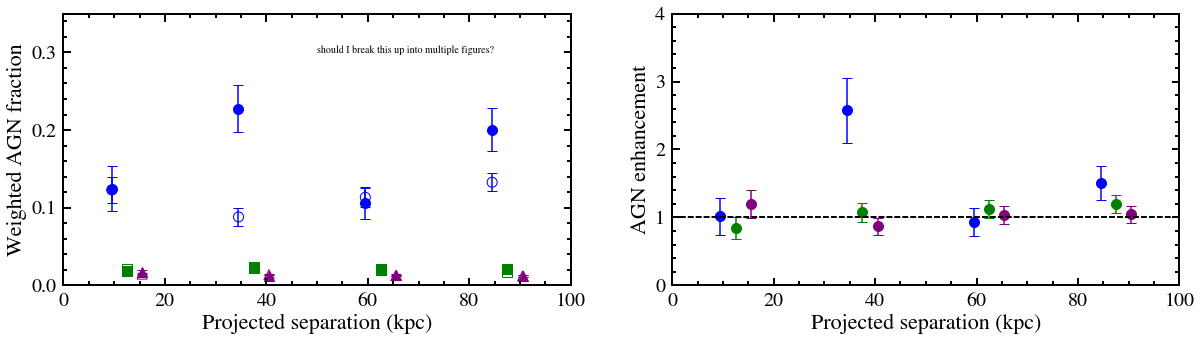

In [32]:
#  ---> LX bins, just for major
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
fig.subplots_adjust(hspace=0)

AGNs = ['midLX', 'hiLX'] # should look at these bootstrapping distributions
kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]
colors = ['blue','green']
markers = ['o','s']

for i, AGN in enumerate(AGNs):
    maj_frac = np.array([major[AGN+'_frac'][col] for col in major[AGN+'_frac']])
    maj_se = np.array([major[AGN+'_se'][col] for col in major[AGN+'_se']])
    imaj_frac = np.array([major['i'+AGN+'_frac'][col] for col in major['i'+AGN+'_frac']])
    imaj_se = np.array([major['i'+AGN+'_se'][col] for col in major['i'+AGN+'_se']])
    
    ax[i].scatter(kpc_meds+3*(-1+i), maj_frac, s=100, color=colors[i], marker=markers[i])
    ax[i].errorbar(kpc_meds+3*(-1+i), maj_frac, yerr=maj_se, color=colors[i], capsize=5, linestyle='none')
    ax[i].scatter(kpc_meds+3*(-1+i), imaj_frac, s=100, edgecolor=colors[i], marker=markers[i], facecolor='none')
    ax[i].errorbar(kpc_meds+3*(-1+i), imaj_frac, yerr=imaj_se, color=colors[i], capsize=5, linestyle='none')
    
    # ax[0].set_title(AGN, fontsize=20)
    ax[i].set_xlim(0,100)
    ax[i].set_ylim(0,0.35)
    ax[i].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[i].set_ylabel('Weighted AGN fraction', fontsize=22)
    ax[i].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    maj_enh = maj_frac / imaj_frac
    # propogate errors linearly
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    
    ax[1].scatter(kpc_meds+3*(-1+i), maj_enh, s=100, color=colors[i], label='major')
    ax[1].errorbar(kpc_meds+3*(-1+i), maj_enh, yerr=maj_enh_se, color=colors[i], capsize=5, linestyle='none')
    ax[1].plot([0,100],[1,1], color='black', linestyle='--')
    
    # ax[1].set_title(AGN, fontsize=20)
    ax[1].set_xlim(0,100)
    ax[1].set_ylim(0,4)
    ax[1].set_xlabel('Projected separation (kpc)', fontsize=22)
    ax[1].set_ylabel('AGN enhancement', fontsize=22)
    ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
    # for kpc in kpc_meds:
    #     ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
    #     ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)

# add some legends and texts:
ax[0].text(50, 0.3, 'should I break this up into multiple figures?')

plt.show()

In [246]:
# ---> All LX, major, redshift bins, perhaps follow the logic of Shah's figure on pg 14

In [247]:
# ---> obscuration fraction (split our sampke into obscured / unobscured with IR AGN definition
#  ---> LX bins, just for major
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
fig.subplots_adjust(wspace=0.2)

AGNs = ['lowLX', 'midLX', 'hiLX'] # should look at these bootstrapping distributions
kpc_meds = np.array(kpc_meds)
kpc_centers = [((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)]
colors = ['blue','green','purple']
markers = ['o','s','^']

maj_frac = np.array([major[AGN+'_frac'][col] for col in major[AGN+'_frac']])
maj_se = np.array([major[AGN+'_se'][col] for col in major[AGN+'_se']])
imaj_frac = np.array([major['i'+AGN+'_frac'][col] for col in major['i'+AGN+'_frac']])
imaj_se = np.array([major['i'+AGN+'_se'][col] for col in major['i'+AGN+'_se']])

ax.scatter(kpc_meds+3*(-1+i), maj_frac, s=100, color=colors[i], marker=markers[i])
ax.errorbar(kpc_meds+3*(-1+i), maj_frac, yerr=maj_se, color=colors[i], capsize=5, linestyle='none')
ax.scatter(kpc_meds+3*(-1+i), imaj_frac, s=100, edgecolor=colors[i], marker=markers[i], facecolor='none')
ax.errorbar(kpc_meds+3*(-1+i), imaj_frac, yerr=imaj_se, color=colors[i], capsize=5, linestyle='none')

# ax.set_title(AGN, fontsize=20)
ax.set_xlim(0,100)
ax.set_ylim(0,0.35)
ax.set_xlabel('Projected separation (kpc)', fontsize=22)
ax.set_ylabel('Weighted AGN fraction', fontsize=22)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
# for kpc in kpc_meds:
#     ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)
#     ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05)

# add some legends and texts:
ax[0].text(50, 0.3, 'should I break this up into multiple figures?')

plt.show()

In [143]:
adds = []
for field in fields:
    df = rdf.loc[ (rdf['pair_prob'] > 0.01) & (rdf['field'] == field) ]
    df_ID = np.concatenate( (df['prime_ID'], df['partner_ID']) )
    adds.append(len(np.unique(df_ID)))
print(np.sum(adds))
# 63352 - unique galaxies in a pair with Pp > 0.01
# 134454 - for entire sample size

63352


In [16]:
# need to quanitify matching
# Shah reported that >90% of paired galaxies, controls match stellar masss within 0.15 dex, z within 0.15, 
#      and environmental density within 1
# how to quantify these... maybe even a KS test...
# rdf.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/test_output/rdf.csv', index=False)
# cdf.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/test_output/cdf.csv', index=False)

# load them back in and compute the Shah statistics
mdf = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/test_output/cdf-rdf.csv')

In [20]:
dM = 0.2
dz = 0.2
dE = 4
ds = 0.2
mdf['meet'] = [0]*len(mdf)
mdf2 = mdf.loc[ (np.abs(mdf['MASS1'] - mdf['prime_M']) < dM) & (np.abs(mdf['MASS2'] - mdf['partner_M']) < dM) &
        (np.abs(mdf['z1'] - mdf['prime_z']) < dz) & (np.abs(mdf['z2'] - mdf['partner_z']) < dz) & 
        (np.abs(mdf['ENV1'] - mdf['prime_env']) < dE) & (np.abs(mdf['ENV2'] - mdf['partner_env']) < dE) &
        (np.abs(np.log10(mdf['SIG1']) - np.log10(mdf['prime_PDFsig'])) < ds) & 
        (np.abs(np.log10(mdf['SIG2']) - np.log10(mdf['partner_PDFsig'])) < ds) &
        (mdf['pair_prob'] > 0.01) ]
mdf3 = mdf.loc[ mdf['pair_prob'] > 0.01 ]
print(len(mdf2)/len(mdf3))

# # yes but how many primary galaxies got all 3? Maybe it'd be higher?
# # do it with a for loop:
# ll = np.zeros(int(len(mdf3)/3))
# for i, ID in tqdm(enumerate(mdf3['pair_ID_1'].unique()), miniters=100):
#     m = mdf3.loc[ mdf3['pair_ID_1'] == ID, 'meet' ]
#     ll[i] = np.sum(m)

0.9072222598793466


In [38]:
len(np.where(ll == 3)[0]) / len(ll)

0.5659187961770488

## Old

In [ ]:
### I ADDED A MIN PCUT OF 0.01 IN CONV_AGN_MERGER.PY
adf = rdf.loc[ (rdf['kpc_sep'] > 75) & (rdf['kpc_sep'] < 90) & (rdf['prime_M'] > 10) & (rdf['mass_ratio'] < np.log10(4)), 
                            ['pair_ID','kpc_sep','pair_prob','prime_LX','partner_LX', 'lowLX','midLX','hiLX','allLX','IR'] ]
iadf = cdf.loc[ (cdf['pair_ID'].isin(adf['pair_ID']) == True) ]


count = (np.sum(adf['pair_prob'] * adf['allLX']))
frac = (np.sum(adf['pair_prob'] * adf['allLX'])) / np.sum(adf['pair_prob'])
print(count, frac)

icount = (np.sum(iadf['Cp'] * iadf['allLX']))
ifrac = (np.sum(iadf['Cp'] * iadf['allLX'])) / np.sum(iadf['Cp'])
print(icount, ifrac)


#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ###
#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ###

# PAIRS
#           count                    frac
# 5-15:  5.147336690556756,   0.10436632347488538
# 15-30: 9.69991162970431,    0.11364569319736793
# 30-45: 8.898926122699887 ,  0.12038374011649512
# 45-60: 11.641110866579927,  0.14867545305673077
# 60-75: 8.497398371275843,   0.09840836402691118
# 75-90: 19.150189370998493,  0.18323484102715332

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ###

# CONTROLS
# 5-15:  17.111332076836607,  0.11598288870732278
# 15-30: 29.00718745668778,   0.11356195099398105
# 30-45: 25.17703034678629 ,  0.11414129229445158
# 45-60: 21.347677729517148,  0.09139533856426076
# 60-75: 20.73852759959499,   0.0805173752604437
# 75-90: 29.802095619581,     0.09542174927542496

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ###
#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ###

In [ ]:
aa = rdf.loc[ np.abs(rdf['prime_z'] - rdf['partner_z']) < 0.02, 
        ['prime_ID','prime_z','prime_PDFsig','partner_ID','partner_z','partner_PDFsig','pair_prob']]
aa[100:200]

In [ ]:
# rdf.loc[ (rdf['field'] == 'COS') & (rdf['pair_prob'] > 0.0001) & (rdf['prime_zt'] == 's'), 
#         ['prime_ID','prime_zt','prime_z','partner_ID','partner_zt','partner_z','pair_prob'] ]
np.log10(4)

In [ ]:
cdf

In [ ]:
# calculate AGN enhancement and propogate error once more:
Enh_X = pXAGN_fracs / iXAGN_fracs
Enh_X_err = Enh_X * np.sqrt( (pXfrac_err/pXAGN_fracs)**2 + (iXfrac_err/iXAGN_fracs)**2 )
Enh_DoIR = pDoAGN_fracs /al iDoAGN_fracs
Enh_DoIR_err = Enh_DoIR * np.sqrt( (pDofrac_err/pDoAGN_fracs)**2 + (iDofrac_err/iDoAGN_fracs)**2 )
Enh_StIR = pStAGN_fracs / iStAGN_fracs
Enh_StIR_err = Enh_StIR * np.sqrt( (pStfrac_err/pStAGN_fracs)**2 + (iStfrac_err/iStAGN_fracs)**2 )

# p_obsc_frac, i_obsc_frac, p_obsc_frac_err, i_obsc_frac_err
Enh_oDoIR = p_obsc_frac / i_obsc_frac
Enh_oDoIR_err = Enh_oDoIR * np.sqrt( (p_obsc_frac_err/p_obsc_frac)**2 + (i_obsc_frac_err/i_obsc_frac)**2 )

In [ ]:
# AGN enhancement plot:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True) #sharey=True)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0)
# X-ray
ax[0].scatter(kpc_meds, Enh_X, s=100, color='blue')
ax[0].errorbar(kpc_meds, Enh_X, yerr=(Enh_X_err,Enh_X_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[0].plot([-5,200], [1,1], linestyle='--', color='black')
ax[0].set_ylim(0, 3.99)
ax[0].set_xlim(-1,121)
ax[0].set_ylabel('AGN Excess', fontsize=20)
# ax[0].set_xlabel('projected separation (kpc)', fontsize=15)
ax[0].text(2,2.55,'X-ray AGN', fontsize=25)

# Donley
ax[1].scatter(kpc_meds, Enh_DoIR, s=100, color='blue')
ax[1].errorbar(kpc_meds, Enh_DoIR, yerr=(Enh_DoIR_err,Enh_DoIR_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[1].plot([-5,200], [1,1], linestyle='--', color='black')
ax[1].set_ylim(0, 3.99)
# ax[1].set_xlabel('projected separation (kpc)', fontsize=15)
ax[1].set_ylabel('AGN Excess', fontsize=20)
ax[1].text(60,2.55,'Donley AGN', fontsize=25)

# Stern
ax[2].scatter(kpc_meds, Enh_StIR, s=100, color='blue')
ax[2].errorbar(kpc_meds, Enh_StIR, yerr=(Enh_StIR_err,Enh_StIR_err), xerr=vwidth/2, linestyle="None", capsize=5, color='blue')
ax[2].plot([-5,200], [1,1], linestyle='--', color='black')
ax[2].set_ylim(0, 3.99)
ax[2].set_xlabel('projected separation (kpc)', fontsize=15)
ax[2].set_ylabel('AGN Excess', fontsize=20)
ax[2].text(60,2.55, 'Stern AGN', fontsize=25)

plt.show()

# loss of IR Don AGN likely due to contamination in control sample, work in a modest cut of 0.5 to weed out spectroscopic pairs

In [ ]:
# Enh_X1000 = Enh_X
# Enh_X_err1000 = Enh_X_err
# Enh_DoIR1000 = Enh_DoIR
# Enh_DoIR_err1000 = Enh_DoIR_err
# Enh_DoIR1000 = Enh_oDoIR
# Enh_DoIR_err1000 = Enh_oDoIR_err

Enh_X500 = Enh_X
Enh_X_err500 = Enh_X_err
Enh_DoIR500 = Enh_DoIR
Enh_DoIR_err500 = Enh_DoIR_err

# data points for Ellison+13:
Ell13 = np.array([
    5.0666666666666735, 2.556420233463035,
    15.09333333333334, 1.9571984435797662,
    25.119999999999997, 1.6536964980544746,
    35.04, 1.459143968871595,
    44.959999999999994, 1.3112840466926068,
    54.986666666666665, 1.2879377431906613,
    65.01333333333332, 1.155642023346303,
    75.03999999999999, 1.2490272373540856])
Ell13err = np.array([
    5.0666666666666735, 2.8210116731517507,
    15.09333333333334, 2.11284046692607,
    25.119999999999997, 1.7937743190661477,
    35.04, 1.591439688715953,
    44.959999999999994, 1.4357976653696496,
    54.986666666666665, 1.4124513618677041,
    65.01333333333332, 1.2568093385214008,
    75.03999999999999, 1.3657587548638133])
Ell13_enh = Ell13[1::2]
Ell13_x = Ell13[::2]
Ell13_enherr = Ell13err[1::2] - Ell13_enh

# Satyapal+14
Sat14 = np.array([
    5.0381679389312986, 3.7539936102236453,
    15.012722646310436, 3.3706070287539944,
    24.98727735368957, 2.6517571884984044,
    34.961832061068705, 1.789137380191697,
    45.038167938931295, 1.6932907348242843,
    55.012722646310436, 1.4057507987220461,
    64.98727735368958, 1.0223642172523988,
    74.9618320610687, 1.0223642172523988])
Sat14err = np.array([
    5.0381679389312986, 4.616613418530353,
    15.012722646310436, 3.945686900958467,
    25.089058524173026, 2.1725239616613443,
    35.06361323155216, 2.220447284345049,
    45.038167938931295, 1.3099041533546334,
    55.012722646310436, 1.7412140575079889,
    64.98727735368958, 1.2619808306709288,
    74.9618320610687, 1.3099041533546334])
Sat14_enh = Sat14[1::2]
Sat14_x = Sat14[::2]
Sat14_enherr = np.abs(Sat14err[1::2] - Sat14_enh)

# Shah data:
Sha20 = np.array([14.101382488479267, 0.9266055045871555,
    37.88018433179723, 1.0642201834862384,
    63.133640552995395, 1.1834862385321099,
    88.38709677419354, 0.8623853211009171,
    112.53456221198155, 0.9357798165137607,
    136.68202764976957, 1.0275229357798166])
Sha20errU = np.array([14.101382488479267, 1.1467889908256872,
    37.88018433179723, 1.2935779816513757,
    63.133640552995395, 1.4862385321100917,
    88.38709677419354, 1.045871559633027,
    112.53456221198155, 1.1559633027522933,
    136.68202764976957, 1.2752293577981648])
Sha20errL = np.array([13.888888888888893, 0.7798165137614674,
    37.592592592592595, 0.8807339449541276,
    63.14814814814815, 0.9633027522935782,
    88.5185185185185, 0.7247706422018352,
    112.77777777777779, 0.7706422018348622,
    137.037037037037, 0.853211009174311])
Sha20_enh = Sha20[1::2]
Sha20_x = Sha20[::2]
Sha20_enherrU = np.abs(Sha20errU[1::2] - Sha20_enh)
Sha20_enherrL = np.abs(Sha20errL[1::2] - Sha20_enh)

ShaIR20 = np.array([13.980582524271842, 0.9767441860465098,
    37.66990291262136, 1.87596899224806,
    63.10679611650485, 1.2248062015503862,
    88.54368932038835, 0.6976744186046488,
    112.81553398058254, 0.4586046511627879,
    136.89320388349518, 0.759689922480618])
ShaIR20errU = np.array([13.980582524271842, 1.5348837209302317,
    37.66990291262136, 3.147286821705425,
    63.10679611650485, 2.155038759689921,
    88.54368932038835, 1.2558139534883708,
    112.62135922330098, 0.8837209302325562,
    137.0873786407767, 1.441860465116278])
ShaIR20errL = np.array([13.980582524271842, 0.6356589147286797,
    37.66990291262136, 1.2248062015503862,
    63.10679611650485, 0.7906976744186025,
    88.54368932038835, 0.4186046511627879,
    112.81553398058254, 0.32558139534883423,
    136.89320388349518, 0.44961240310077244])
ShaIR20_enh = ShaIR20[1::2]
ShaIR20_x = ShaIR20[::2]
ShaIR20_enherrU = np.abs(ShaIR20errU[1::2] - ShaIR20_enh)
ShaIR20_enherrL = np.abs(ShaIR20errL[1::2] - ShaIR20_enh)

In [ ]:
# get this into pretation form:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.1)

kpc_meds = np.array(kpc_meds)

ax[0].plot([-10,150], [1,1], color='black', linestyle=':', zorder=1)
# ax[0].scatter(Ell13_x, Ell13_enh, s=50, color='black', marker='D', zorder=2)
# ax[0].errorbar(Ell13_x, Ell13_enh, yerr=Ell13_enherr, linestyle='none', capsize=5, color='black', zorder=2)
# ax[0].scatter(Sha20_x, Sha20_enh, s=50, color='red', marker='o', zorder=2)
# ax[0].errorbar(Sha20_x, Sha20_enh, yerr=(Sha20_enherrL, Sha20_enherrU), linestyle='none', capsize=5, 
#                color='red', zorder=2)
## plot V < 1000
######################
# ax[0].scatter(kpc_meds, Enh_X1000, s=150, color='cornflowerblue', marker='p', zorder=2)
# ax[0].errorbar(kpc_meds, Enh_X1000, yerr=(Enh_X_err1000,Enh_X_err1000), linestyle="None", capsize=5, 
#                color='cornflowerblue', zorder=2)
# ## plot V < 500
# ax[0].scatter(kpc_meds+3, Enh_X500, s=150, marker='^', color='orange', zorder=2)
# ax[0].errorbar(kpc_meds+3, Enh_X500, yerr=(Enh_X_err500,Enh_X_err500), linestyle="None", capsize=5, color='orange', zorder=2)
######################
ax[0].scatter(kpc_meds+3, Enh_X500, s=150, color='orange', marker='^', zorder=2)
ax[0].errorbar(kpc_meds+3, Enh_X500, yerr=(Enh_X_err500,Enh_X_err500), linestyle="None", capsize=5, 
               color='orange', zorder=2)
## plot V < 500
ax[0].scatter(kpc_meds, Enh_X1000, s=100, marker='p', color='green', zorder=2)
ax[0].errorbar(kpc_meds, Enh_X1000, yerr=(Enh_X_err1000,Enh_X_err1000), linestyle="None", capsize=5, color='green', zorder=2)
ax[0].text(70,4.3,'X-ray AGN', fontsize=25)
# ax[0].text(110,4.3,'X-ray AGN', fontsize=25)
# ax[0].scatter(90, 3.8, s=150, marker='p', color='cornflowerblue')
# ax[0].scatter(90, 3.4, s=150, marker='^', color='orange')
# ax[0].text(95, 3.7, '$\Delta V < 1000$', fontsize=20)
# ax[0].text(95, 3.3, '$\Delta V < 500$', fontsize=20)
# plot the shapes so I can then create a legend from it:
ax[0].scatter(50, 3.9, s=100, color='green', marker='p')
ax[0].scatter(50, 3.5, s=100, color='orange', marker='^')
# ax[0].scatter(50, 3.1, s=150, color='cornflowerblue', marker='p')
ax[0].text(53, 3.8, 'log($L_X$) > 43.7 erg s$^{-1}$ (0.5 < z < 3)', fontsize=13) #log($L_X$) > 43.7 (0.5 < z < 3)
ax[0].text(53, 3.4, '42 < log($L_X$) < 43.7 erg s$^{-1}$ (0.5 < z < 2)', fontsize=13)
# ax[0].text(53, 3, 'This Work (0.5 < z < 3.0)', fontsize=13)

# ax[0].text(72,3.3,'X-ray AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
# ax[0].scatter(75, 3.9, s=50, color='black', marker='D')
# ax[0].scatter(75, 3.5, s=50, color='red', marker='o')
# ax[0].text(80, 3.8, 'Ellison et al. 2013 (0.01 < z < 0.2)', fontsize=13)
# ax[0].text(80, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)

ax[1].plot([-5,150], [1,1], color='black', linestyle=':', zorder=1)

# ax[1].scatter(Sat14_x, Sat14_enh, s=50, color='black', marker='D', zorder=2)
# ax[1].errorbar(Sat14_x, Sat14_enh, yerr=Sat14_enherr, linestyle='none', capsize=5, color='black', zorder=2)
# ax[1].scatter(ShaIR20_x, ShaIR20_enh, s=50, color='red', marker='o', zorder=2)
# ax[1].errorbar(ShaIR20_x, ShaIR20_enh, yerr=(ShaIR20_enherrL, ShaIR20_enherrU), linestyle='none', capsize=5, 
#                color='red', zorder=2)
#############################
# ax[1].scatter(kpc_meds, Enh_DoIR500, s=150, color='orange', marker='^', zorder=2)
# ax[1].errorbar(kpc_meds, Enh_DoIR500, yerr=(Enh_DoIR_err1000,Enh_DoIR_err1000), linestyle="None", capsize=5, 
#                color='orange', zorder=2)

#############################

ax[1].text(80,4.3,'IR AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
ax[1].scatter(50, 3.9, s=50, color='black', marker='D')
ax[1].scatter(50, 3.5, s=50, color='red', marker='o')
ax[1].scatter(50, 3.1, s=150, color='cornflowerblue', marker='p')
ax[1].text(53, 3.8, 'Satyapal et al. 2014 (0.01 < z < 0.2)', fontsize=13)
ax[1].text(53, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)
ax[1].text(53, 3, 'This Work (0.5 < z < 3.0), Obscured', fontsize=13)

ax[1].scatter(kpc_meds+3, Enh_DoIR500, s=150, color='orange', marker='^', zorder=2)
ax[1].errorbar(kpc_meds+3, Enh_DoIR500, yerr=(Enh_DoIR_err500,Enh_DoIR_err500), linestyle="None", capsize=5, 
               color='orange', zorder=2)
ax[1].scatter(kpc_meds, Enh_DoIR1000, s=100, marker='p', color='green', zorder=2)
ax[1].errorbar(kpc_meds, Enh_DoIR1000, yerr=(Enh_DoIR_err1000,Enh_DoIR_err1000), linestyle="None", capsize=5, color='green', zorder=2)
# ax[1].scatter(90, 3.8, s=150, marker='p', color='cornflowerblue')
# ax[1].scatter(90, 3.4, s=150, marker='^', color='orange')
# ax[1].text(95, 3.7, '$\Delta V < 1000$', fontsize=20)
# ax[1].text(95, 3.3, '$\Delta V < 500$', fontsize=20)
# ax[1].text(80,3.3,'IR AGN', fontsize=25)
# plot the shapes so I can then create a legend from it:
# ax[1].scatter(50, 3.9, s=50, color='black', marker='D')
# ax[1].scatter(50, 3.5, s=50, color='red', marker='o')
# ax[1].text(53, 3.8, 'Satyapal et al. 2014 (0.01 < z < 0.2)', fontsize=13)
# ax[1].text(53, 3.4, 'Shah et al. 2020 (0.5 < z < 3.0)', fontsize=13)


ax[0].set_ylim(0,5)
ax[0].set_xlim(0,100)
# ax[0].set_xlabel('projected separation (kpc)')
ax[0].set_ylabel('AGN Enhancement', fontsize=20)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
ax[1].set_ylim(0,5)
ax[1].set_xlim(0,100)
ax[1].set_xlabel('Projected Separation (kpc)', fontsize=20)
ax[1].set_ylabel('AGN Enhancement', fontsize=20)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# mpl.rcParams['axes.linewidth'] = 1 #set the value globally
plt.savefig('/data/c1029594/CANDELS_AGN_merger_code/figs/AGNenh_XRAY.png')


plt.show()

In [ ]:
kpc_meds

In [ ]:
Enh_oDoIR, Enh_oDoIR_err

In [ ]:
Enh_DoIR

In [ ]:
pXAGN_fracs, pDoAGN_fracs, pStAGN_fracs

In [ ]:
pXAGN_fracs, pDoAGN_fracs, pStAGN_fracs

In [ ]:
iStfrac_err

In [ ]:
rdf

In [ ]:
df = bin_dfs['0.0-15.0'] # 30.0-45.0
df.loc[ df['prime_IR_AGN_DON'] > 0, ['prime_z','prime_M','prime_ID', 'prime_LX', 'prime_IR_AGN_DON', 'prime_IR_AGN_STR', 'prime_DALE_AGN_FLAG', 'field' ]]

In [ ]:
# Now think about control galaxy selection... 
# the general idea now is to use the distribution of redshift, mass, and and sigma to get control selection
# from purely the fractional pair counts...

# but first we need to get some numbers... I want to know for each field
# 1) total isolated sample simply from initial projected pair analysis
# 2) how many would be added back with the introduction of a bottoming out
# 3) the percent change that bottoming out would have...
# perhaps I should do this in a separate notebook...

In [ ]:
data = np.array([pX_fr, pX_lerr, pX_uerr, pDo_fr, pDo_lerr, pDo_uerr, pSt_fr, pSt_lerr, pSt_uerr])
df = pd.DataFrame(data)
df = df.T
df = df.rename(columns={0:'pX_fr',1:'pX_lerr',2:'pX_uerr',
                        3:'pDo_fr',4:'pDo_lerr',5:'pDo_uerr',
                        6:'pSt_fr',7:'pSt_lerr',8:'pSt_uerr'})
# df.to_csv(PATH+'conv_results.csv', index=False)

In [ ]:
# save all the plotting data as a df
# bins as rows, columns are 

## General property distributions

In [ ]:
# load up the dfs, make the same cuts, add AGN information and proceed:
# load in catalogs: <== specify column dtypes
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=9
sigma_cut=10
z_type = 'ps'
full_SPLASH = False

for field in fields:
    if field == 'COSMOS':
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        
        df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > mass_lo) & # (mass_lo-1)
             (df['SIG_DIFF'] > 0) & (df['HSC_i_MAG_AUTO'] < 26) ]
        # df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
        #                 dtype={'ZSPEC_R':object})
        # # df = df.loc[ (df['VALID_SOURCE'] == True) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
        # #     (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0)]
        # df = df.loc[ (df['lp_type'] != 1) & (df['lp_type'] != -99) & (df['lp_MASS'] > mass_lo) & (df['lp_MASS'] < 12) &
        #         (df['FLAG_COMBINED'] == 0) & (df['lp_SIG_DIFF'] > 0) ] #& (df['HSC_i_MAG'] < 25) ]
        # df = df.rename(columns={'lp_MASS':'MASS','lp_ZPHOT_PEAK':'ZPHOT_PEAK'})
        if full_SPLASH == True:
            df = df.drop(columns={'IRAC_CH1_FLUX', 'IRAC_CH1_FLUXERR', 'IRAC_CH2_FLUX', 'IRAC_CH2_FLUXERR'})
            df = df.rename(columns={'SPLASH_CH1_FLUX':'IRAC_CH1_FLUX', 'SPLASH_CH1_FLUXERR':'IRAC_CH1_FLUXERR',
                                    'SPLASH_CH2_FLUX':'IRAC_CH2_FLUX', 'SPLASH_CH2_FLUXERR':'IRAC_CH2_FLUXERR',
                                    'SPLASH_CH3_FLUX':'IRAC_CH3_FLUX', 'SPLASH_CH3_FLUXERR':'IRAC_CH3_FLUXERR',
                                    'SPLASH_CH4_FLUX':'IRAC_CH4_FLUX', 'SPLASH_CH4_FLUXERR':'IRAC_CH4_FLUXERR'})
        elif full_SPLASH == False:
            df = df.rename(columns={'SPLASH_CH3_FLUX':'IRAC_CH3_FLUX', 'SPLASH_CH3_FLUXERR':'IRAC_CH3_FLUXERR',
                                    'SPLASH_CH4_FLUX':'IRAC_CH4_FLUX', 'SPLASH_CH4_FLUXERR':'IRAC_CH4_FLUXERR'})
            
    else:
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > (mass_lo)) & 
            (df['SIG_DIFF'] < sigma_cut) ]
    df = df.reset_index(drop=True)
    
    # calculate AB mags:
    df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
    
    # first thing is change df based on z_type
    df['z'] = df['ZPHOT_PEAK']
    if z_type == 'ps':
        df.loc[ df['ZBEST_TYPE'] == 's', 'z' ] = df['ZSPEC']
        df.loc[ df['ZBEST_TYPE'] == 's', 'SIG_DIFF' ] = 0
        
    all_df = df.loc[ (df['z'] >= 0.5) & (df['z'] <= 3.0) ].reset_index(drop=True)
    # all_df = df
    
    # calculate LX
    all_df['LX'] = ( all_df['FX'] * 4 * np.pi * ((cosmo.luminosity_distance(all_df['z']).to(u.cm))**2).value * 
                                                                ((1+all_df['z'])**(gamma-2)) )
   # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    
    # Flag IR AGN based on Donley and Stern
    # look at IR luminosities
    all_df['IR_AGN_DON'] = [0]*len(all_df)
    all_df['IR_AGN_STR'] = [0]*len(all_df)

    all_df.loc[ (np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']) >= 0.08) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= 0.15) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) >= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))-0.27) &
               (np.log10(all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH2_FLUX']) <= (1.21*np.log10(all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH1_FLUX']))+0.27) &
               (all_df['IRAC_CH2_FLUX'] > all_df['IRAC_CH1_FLUX']) &
               (all_df['IRAC_CH3_FLUX'] > all_df['IRAC_CH2_FLUX']) &
               (all_df['IRAC_CH4_FLUX'] > all_df['IRAC_CH3_FLUX']), 'IR_AGN_DON'] = 1
    
    # zero magnitude fluxes:
    F03p6 = 280.9 #±4.1 Jy
    F04p5 = 179.7 #±2.6 Jy
    F05p8 = 115.0 #±1.7 Jy
    F08p0 = 64.9 #±0.9 Jy 
    all_df.loc[ (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6)) > 0.6) &
               (2.5*np.log10(F03p6 / (all_df['IRAC_CH1_FLUX']/1e6)) - 2.5*np.log10(F04p5 / (all_df['IRAC_CH2_FLUX']/1e6)) > 
               0.2 * (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6))) + 0.18) &
               (2.5*np.log10(F03p6 / (all_df['IRAC_CH1_FLUX']/1e6)) - 2.5*np.log10(F04p5 / (all_df['IRAC_CH2_FLUX']/1e6)) > 
                2.5 * (2.5*np.log10(F05p8 / (all_df['IRAC_CH3_FLUX']/1e6)) - 2.5*np.log10(F08p0 / (all_df['IRAC_CH4_FLUX']/1e6))) - 3.5),
               'IR_AGN_STR'] = 1
    
    # set the ones with incomplete data back to 0: POTENTIALLY UNECESSARY NOW (BELOW)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] <= 0) | (all_df['IRAC_CH2_FLUX'] <= 0) |
               (all_df['IRAC_CH3_FLUX'] <= 0) | (all_df['IRAC_CH4_FLUX'] <= 0), ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    all_df.loc[ (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] < 5) | (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] < 5) |
               (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] < 5) | (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] < 5),
              ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    # if field == 'COSMOS':
    #     all_df.loc[ (all_df['IRAC_CH1_ABMAG'] > 25.7) | (all_df['IRAC_CH2_ABMAG'] > 25.6) |
    #                (all_df['IRAC_CH3_ABMAG'] > 22.6) | (all_df['IRAC_CH4_ABMAG'] > 22.5), 
    #                ['IR_AGN_DON', 'IR_AGN_STR'] ] = 0
    
    # now just take the information that we need
    all_df['field'] = [field]*len(all_df)
    all_df['X_AGN'] = [0]*len(all_df)
    #### all_df.loc[ np.log10(all_df['LX']) > LX_AGN, 'X_AGN' ] = 1
    
    # m1 = np.min(all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 3), 'IRAC_CH1_FLUX' ])*1e-6
    # m2 = np.min(all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 3), 'IRAC_CH2_FLUX' ])*1e-6
    # m3 = np.min(all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 3), 'IRAC_CH3_FLUX' ])*1e-6
    # m4 = np.min(all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 3), 'IRAC_CH4_FLUX' ])*1e-6
    # m1 = np.min(all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0), 'IRAC_CH1_FLUX' ])
    # m2 = np.min(all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0), 'IRAC_CH2_FLUX' ])
    # m3 = np.min(all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0), 'IRAC_CH3_FLUX' ])
    # m4 = np.min(all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0), 'IRAC_CH4_FLUX' ])
    # print(field, m1, m2, m3, m4)
    # print(field, F2m(m1,1), F2m(m2,2), F2m(m3,3), F2m(m4,4))
    
    # add full ch detection flags:
    all_df['CH1_det'] = [0]*len(all_df)
    all_df['CH2_det'] = [0]*len(all_df)
    all_df['CH3_det'] = [0]*len(all_df)
    all_df['CH4_det'] = [0]*len(all_df)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 5), 'CH1_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 5), 'CH2_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 5), 'CH3_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 5), 'CH4_det' ] = 1
                                 
    all_dfs_dict[field] = all_df.loc[:, ['field','ID','z','MASS','LX','X_AGN','IR_AGN_DON','IR_AGN_STR', 
                                        'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
                                        'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
                                        'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
                                        'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]
    

In [ ]:
all_dfs = pd.concat(all_dfs_dict, ignore_index=True)

In [ ]:
# make IRAC flux plots for detections:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
chs = ['1','2','3','4']
ratbins = np.logspace(0,4,100)
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(12,20))
for i, ch in enumerate(chs):
    for field in fields:
        sig_rat = (all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1), 'IRAC_CH'+ch+'_FLUX' ] / 
                   all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1), 'IRAC_CH'+ch+'_FLUXERR' ])
        if field == 'COSMOS':
            ax[i].hist(sig_rat, bins=ratbins, histtype='step', density=True, label=field, lw=2)
        else:
            ax[i].hist(sig_rat, bins=ratbins, histtype='step', density=True, label=field)
        ax[i].set_xscale('log')
        
    ax[i].legend(fontsize=15)
    ax[i].text(1,0.01, 'CH'+ch, fontsize=15)
        
plt.show()
        

In [ ]:
chs = ['1','2','3','4']
xbins = np.linspace(15,30,100)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,20))
for i, ch in enumerate(chs):
    for field in fields:
        fdf = all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1) ]
        if field == 'COSMOS':
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', lw=2, label=field)
        else:
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', label=field)
    
    # plt.plot([22.5,22.5],[0,100], color='black', linestyle = ':')
    ax[i].set_ylim(0,1)
    ax[i].legend()
    ax[i].text(16,0.8,'CH'+ch, fontsize=20)
    
    if ch == '1':
        ax[i].plot([20.8,20.8],[0,1], color='black', linestyle=':')
plt.show()

In [ ]:
X_df = all_dfs.loc[ all_dfs['X_AGN'] == 1]
DON_df = all_dfs.loc[ all_dfs['IR_AGN_DON'] == 1]
STR_df = all_dfs.loc[ all_dfs['IR_AGN_STR'] == 1]

In [ ]:
DON_df.loc[ DON_df['field'] == 'COSMOS', 'IRAC_CH4_FLUX' ].describe()
# we need to recreate the same selection criterea that Donley used...
# 1058 (1172) Donley in SPLASH
# 1038 (1140) in DAWN+SPLASH...

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
mbins = np.linspace(9,12,35)
zbins = np.linspace(0.5,3,35)
magbins = np.linspace(15,30,120)

ax[0].hist(X_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[0].hist(DON_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='Donley AGN', color='red',
          lw=3)
ax[0].hist(STR_df['MASS'], bins=mbins, density=True, cumulative=False, histtype='step', label='Stern AGN', color='green')
ax[0].set_xlim(9,12)
# ax[0].set_yscale('log')
ax[0].legend(loc=1)
ax[0].set_xlabel('MASS', fontsize=15)

ax[1].hist(X_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[1].hist(DON_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='red',
          lw=3)
ax[1].hist(STR_df['z'], bins=zbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='green')
# ax[1].set_yscale('log')
ax[1].set_xlim(0.5,3)
ax[1].set_xlabel('REDSHIFT', fontsize=15)

ax[2].hist(X_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='blue')
ax[2].hist(DON_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='red',
          lw=3)
ax[2].hist(STR_df['IRAC_CH4_ABMAG'], bins=magbins, density=True, cumulative=False, histtype='step', label='X-ray AGN', color='green')
# ax[1].set_yscale('log')
ax[2].plot([21.2,21.2],[0,1], color='black', linestyle=':', lw=2)
ax[2].set_ylim(0,0.8)
ax[2].set_xlim(15,26)
ax[2].set_xlabel('AB mag', fontsize=15)

plt.show()

In [ ]:
# redshift vs LX per field:
colors = ['firebrick','navy','green','tomato','cornflowerblue','cornflowerblue']
markers = ['x','D','^','v','o','.']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

ax.set_xlim(0.5,3)
ax.set_ylim(42,46)
ax.set_xlabel('z', fontsize=20)
ax.set_ylabel('$L_X$', fontsize=20)
ax.plot([0.5,3],[43.7,43.7], color='black')
ax.plot([0.5,2],[43.2,43.2], color='black')
ax.plot([2,2],[42,43.7], color='black')
ax.add_patch(Rectangle((0.5,43.7), 2.5, 4, facecolor='lightsteelblue', alpha=0.3))
ax.add_patch(Rectangle((0.5,43.2), 1.5, 0.5, facecolor='purple', alpha=0.1))
ax.add_patch(Rectangle((0.5,42), 1.5, 1.2, facecolor='red', alpha=0.1))

for i, field in enumerate(fields):
    fdf = X_df.loc[ X_df['field'] == field ]
    plt.scatter( fdf['z'], np.log10(fdf['LX']), color=colors[i], marker=markers[i], label=field, zorder=-1*i )
    
plt.legend(loc=2, fontsize=15)
    
plt.show()

In [ ]:
# so let's create a new df from rdf and add kpc<15 Pprobs:
key = '60.0-75.0'
df_dict = {'ID':ID_bin[key],
    'field':field_bin[key],
    'Pp':p_wprobs[key],
    'z':pz_bin[key],
    'MASS':pmass_bin[key],
    'X_AGN':pX_bin[key],
    'Do_AGN':pDo_bin[key],
    'St_AGN':pSt_bin[key]}
bin15_df = pd.DataFrame(df_dict)
X_df15 = bin15_df.loc[ bin15_df['X_AGN'] == 1]
DON_df15 = bin15_df.loc[ bin15_df['Do_AGN'] == 1]
STR_df15 = bin15_df.loc[ bin15_df['St_AGN'] == 1]

In [ ]:
fig, ax = plt.subplots(nrows=len(ID_bin), ncols=3, figsize=(20,100))
pbins = np.logspace(-12,0, 1000)
# pbins = np.linspace(10e-11,1, 1000000)
for i, key in tqdm(enumerate(ID_bin.keys())):
    pdf_dict = {'ID':ID_bin[key],
        'field':field_bin[key],
        'Pp':p_wprobs[key],
        'z':pz_bin[key],
        'MASS':pmass_bin[key],
        'X_AGN':pX_bin[key],
        'Do_AGN':pDo_bin[key],
        'St_AGN':pSt_bin[key]}
    idf_dict = {'ID':iID_bin[key],
        'field':ifield_bin[key],
        'Pp':i_wprobs[key],
        'z':iz_bin[key],
        'MASS':imass_bin[key],
        'X_AGN':iX_bin[key],
        'Do_AGN':iDo_bin[key],
        'St_AGN':iSt_bin[key]}
    pdf = pd.DataFrame(pdf_dict)
    idf = pd.DataFrame(idf_dict)
    pX_df = pdf.loc[ pdf['X_AGN'] == 1]
    poX_df = pdf.loc[ (pdf['Do_AGN'] != 1) & (pdf['X_AGN'] == 1) ]
    pDON_df = pdf.loc[ pdf['Do_AGN'] == 1]
    poDON_df = pdf.loc[ (pdf['Do_AGN'] == 1) & (pdf['X_AGN'] != 1) ]
    pSTR_df = pdf.loc[ pdf['St_AGN'] == 1]
    iX_df = idf.loc[ idf['X_AGN'] == 1]
    ioX_df = pdf.loc[ (idf['Do_AGN'] != 1) & (idf['X_AGN'] == 1) ]
    iDON_df = idf.loc[ idf['Do_AGN'] == 1]
    ioDon_df = pdf.loc[ (idf['Do_AGN'] == 1) & (idf['X_AGN'] != 1) ]
    iSTR_df = idf.loc[ idf['St_AGN'] == 1]
    
    
    p_Xc, p_Xb, p_Xp = ax[i,0].hist(pX_df['Pp'], bins=pbins, color='blue', density=True, cumulative=1, histtype='step',
                                   label='paired X-ray AGN')
    po_Xc, po_Xb, po_Xp = ax[i,0].hist(poX_df['Pp'], bins=pbins, color='deepskyblue', density=True, cumulative=1, histtype='step',
                                   label='paired X-ray AGN')
    p_Dc, p_Db, p_Dp = ax[i,0].hist(pDON_df['Pp'], bins=pbins, color='red', density=True, cumulative=1, histtype='step',
                                   label='paired Donley AGN')
    po_Dc, po_Db, po_Dp = ax[i,0].hist(poDON_df['Pp'], bins=pbins, color='violet', density=True, cumulative=1, histtype='step',
                                   label='paired only Donley AGN')
    # p_Sc, p_Sb, p_Sp = ax[i,0].hist(pSTR_df['Pp'], bins=pbins, color='green', density=True, cumulative=-1, histtype='step',
    #                                label='paired Stern AGN')
    i_Xc, i_Xb, i_Xp = ax[i,0].hist(iX_df['Pp'], bins=pbins, color='blue', density=True, cumulative=1, histtype='step', 
                 lw=0.5, linestyle='--', label='apple X-ray AGN')
    io_Xc, io_Xb, io_Xp = ax[i,0].hist(ioX_df['Pp'], bins=pbins, color='deepskyblue', density=True, cumulative=1, histtype='step',
                 lw=0.5, linestyle='--', label='apple X-ray AGN')
    i_Dc, i_Db, i_Dp = ax[i,0].hist(iDON_df['Pp'], bins=pbins, color='red', density=True, cumulative=1, histtype='step', 
                 lw=0.5, linestyle='--', label='apple Donley AGN')
    io_Dc, io_Db, io_Dp = ax[i,0].hist(ioDon_df['Pp'], bins=pbins, color='violet', density=True, cumulative=1, histtype='step',
                 lw=0.5, linestyle='--', label='apple only Donley AGN')
    # i_Sc, i_Sb, i_Sp = ax[i,0].hist(iSTR_df['Pp'], bins=pbins, color='green', density=True, cumulative=-1, histtype='step', 
    #              lw=0.5, linestyle='--', label='apple Stern AGN')
    
    ax[i,0].set_xscale('log')
    ax[i,0].set_yscale('log')
    ax[i,0].set_xlim(10e-12, 1)
    
    ax[i,0].set_xlabel('Pair Probability', fontsize=15)
    ax[i,0].set_ylabel('Cumulative Fraction', fontsize=15)
    ax[i,0].legend(fontsize=10, loc=4)    
    ax[i,0].set_title(key, fontsize=15)

    ax[i,1].stairs((p_Xc/i_Xc), p_Xb, fill=False, color='blue')
    ax[i,1].stairs((po_Xc/io_Xc), po_Xb, fill=False, color='deepskyblue')
    ax[i,1].stairs((p_Dc/i_Dc), p_Db, fill=False, color='red')
    ax[i,1].stairs((po_Dc/io_Dc), po_Db, fill=False, color='violet')
    # ax[i,1].stairs((p_Sc-i_Sc), p_Sb, fill=False, color='green')
    ax[i,1].plot([0,1],[1,1], color='black', linestyle=':')
    ax[i,1].set_xscale('log')
    ax[i,1].set_xlim(1e-5, 1)
    ax[i,1].set_ylim(0,2)
    ax[i,1].set_xlabel('Pair Probability', fontsize=15)
    ax[i,1].set_ylabel('Cumulative Fraction Difference', fontsize=15)
    
    # throw it into a ks test:
    D, p = scipy.stats.ks_2samp(poDON_df['Pp'], poX_df['Pp'], method='auto') 
    ax[i,2].stairs((po_Dc/p_Xc), p_Xb, fill=False, color='black')
    ax[i,2].stairs((io_Dc/i_Xc), p_Xb, fill=False, color='black', linestyle=':')
    ax[i,2].plot([0,1],[1,1], color='black', linestyle=':')
    ax[i,2].set_title('D = {0} // p = {1}'.format(round(D,3), round(p,3)))
    ax[i,2].set_xscale('log')
    ax[i,2].set_xlim(1e-5, 1)
    ax[i,2].set_ylim(0,2)
    ax[i,2].set_xlabel('Pair Probability', fontsize=15)

    
plt.show()

In [ ]:
poDON_df # / (po_Xc)

## pair fraction vs redshift

In [ ]:
# first thing to do is to load in CANDELS data and simply count all source in mass and z range
nPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/Pair Project - Updated Data/'
cPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
fields = ['GDS','EGS','COS','GDN','UDS','COSMOS']
field_pcounts = {}
all_pcounts = {}
field_counts = {}
all_counts = {}
zmins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5]
zmaxs = [1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5.5, 6.5]

# populate all dicts:
for i in range(0, len(zmins)):
    all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = 0
    all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = 0

# load in results:
# file = 'pair_prob/PP_ALL_FIELDS.csv'
file = 'conv_prob/CP_ALL_FIELDS.csv'
rdf = pd.read_csv(PATH+file)
# rdf['pair_prob'] = rdf['pair_prob']/100 # only for pp method

for field in fields:
    print(field)
    if field == 'COSMOS':
        df = pd.read_csv(cPATH+'select_COSMOS2020.csv')
        df['SIG_DIFF'] = df['lp_zPDF_u68'] - df['lp_zPDF_l68']
        df = df[ (df['lp_type'] != 1) & (df['lp_type'] != -99) & (df['lp_mass_med'] > 10.3) & 
           (df['FLAG_COMBINED'] == 0) & (df['lp_zPDF'] > 0.5) & (df['lp_zPDF'] < 6.5) ]
        df = df.rename(columns={'ALPHA_J2000':'RA', 'DELTA_J2000':'DEC', 'lp_mass_med':'MASS', 'lp_zPDF':'ZPHOT_PEAK',
                               'F0.5-10_2015':'FX', 'UVISTA_H_MAG_APER2':'HMAG'})
        all_df = df.reset_index(drop=True)
    else:
        df = pd.read_csv(nPATH+'CANDELS_Catalogs/CANDELS.'+field+'.1018.Lx_best.wFx_AIRD.csv')
        df_phot = pd.read_csv(nPATH+'redshift_catalogs.full/zcat_'+field+'_v2.0.cat', names=['file','ID','RA','DEC','z_best',
                        'z_best_type','z_spec','z_spec_ref','z_grism','mFDa4_z_peak','mFDa4_z_weight','mFDa4_z683_low',
                        'mFDa4_z683_high','mFDa4_z954_low','mFDa4_z954_high','HB4_z_peak','HB4_z_weight','HB4_z683_low',
                        'HB4_z683_high','HB4_z954_low','HB4_z954_high','Finkelstein_z_peak','Finkelstein_z_weight',
                        'Finkelstein_z683_low','Finkelstein_z683_high','Finkelstein_z954_low','Finkelstein_z954_high',
                        'Fontana_z_peak','Fontana_z_weight','Fontana_z683_low','Fontana_z683_high','Fontana_z954_low',
                        'Fontana_z954_high','Pforr_z_peak','Pforr_z_weight','Pforr_z683_low','Pforr_z683_high',
                        'Pforr_z954_low','Pforr_z954_high','Salvato_z_peak','Salvato_z_weight','Salvato_z683_low',
                        'Salvato_z683_high','Salvato_z954_low','Salvato_z954_high','Wiklind_z_peak','Wiklind_z_weight',
                        'Wiklind_z683_low','Wiklind_z683_high','Wiklind_z954_low','Wiklind_z954_high','Wuyts_z_peak',
                        'Wuyts_z_weight','Wuyts_z683_low','Wuyts_z683_high','Wuyts_z954_low','Wuyts_z954_high'],
                           delimiter=' ', comment='#')
        # match based on ID as GDN has ID weirdness
        df_phot = df_phot.loc[ (df_phot['ID'].isin(df['ID']) == True) ]
        df_phot = df_phot.reset_index(drop=True)
        df['ZPHOT_PEAK'] = df_phot['mFDa4_z_peak'] # might want to use weight for consistency with COSMOS
        df['SIG_DIFF'] = df_phot['mFDa4_z683_high'] - df_phot['mFDa4_z683_low']
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > 10.3) & 
                (df['ZPHOT_PEAK'] > 0.5) & (df['ZPHOT_PEAK'] < 6.5) ]
        all_df = df.reset_index(drop=True)
    
    pair_count = {}
    all_count = {}
    for i in range(0, len(zmins)):
        # for pairs
        zdf = rdf[ (rdf['kpc_sep'] >= 5) & (rdf['kpc_sep'] <= 30) & (rdf['mass_ratio'] < np.log10(4/1)) &
                 (rdf['prime_M'] > 10.3) & (rdf['prime_z'] >= zmins[i]) & (rdf['prime_z'] < zmaxs[i]) & 
                  (rdf['field'] == field) & (rdf['pair_prob'] > 0.01) ]
        pair_count[str(zmins[i])+'-'+str(zmaxs[i])] = np.sum(zdf['pair_prob'])
        all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] = all_pcounts[str(zmins[i])+'-'+str(zmaxs[i])] + np.sum(zdf['pair_prob'])
        
        # for all data
        zall_df = all_df[ (all_df['ZPHOT_PEAK'] >= zmins[i]) & (all_df['ZPHOT_PEAK'] < zmaxs[i]) ]
        all_count[str(zmins[i])+'-'+str(zmaxs[i])] = len(zall_df)
        all_counts[str(zmins[i])+'-'+str(zmaxs[i])] = all_counts[str(zmins[i])+'-'+str(zmaxs[i])] + len(zall_df)
        
    field_pcounts[field] = pair_count
    field_counts[field] = all_count
    
field_pcounts['ALL'] = all_pcounts
field_counts['ALL'] = all_counts

In [ ]:
pair_frac = {}
fields.append('ALL')
for field in field_pcounts:
    fracs = {}
    for zbin in field_pcounts[field]:
        fracs[zbin] = field_pcounts[field][zbin] / field_counts[field][zbin]
        pair_frac[field] = fracs

In [ ]:
# field_pcounts

In [ ]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
colors = ['purple','red','green','blue','orange','pink','black']
for i, field in enumerate(field_pcounts):
    if field == 'ALL':
        ax.scatter(-1,-1, s=50, facecolor=colors[i], label=field)
    else:
        ax.scatter(-1,-1,s=25, edgecolor=colors[i], facecolor='none', label=field)
    for zbin in field_pcounts[field]:
        x = zbin.split('-')
        z = ((float(x[0]) + float(x[1])) / 2) + 0.02*i
        if field == 'ALL':
            ax.scatter(z, pair_frac[field][zbin], s=5, facecolor=colors[i])
        else:
            ax.scatter(z, pair_frac[field][zbin], s=25, edgecolor=colors[i], facecolor='none')
plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,6.5)
plt.legend()
plt.show()

In [ ]:
# rdf[ rdf['kpc_sep'] < 30 ]
#

## Update COSMOS for EAZY

In [ ]:
SIGMAS = np.array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

def zcdf_to_pdf(zcdf, sigmas=SIGMAS):
    """
    Convert compressed redshift CDF to PDF

    Parameters
    ----------
    zcdf : array-like
        Redshifts where ``cdf(z)`` for ``normal_cdf(mu=0, sigmas)``

    sigmas : array-like
        Values where ``normal_cdf`` is evaluated
    Returns
    -------
    pdf : array-like
        Converted ``p(z)``

    """
    import scipy.stats
    # Evaluate normal distribution at these values to get PDF(x)
    pdf_y = scipy.stats.norm.pdf(sigmas)
    return pdf_y #/ np.trapz(pdf_y, zcdf) # don't normalize untl after interpolation

In [ ]:
# load in the EAZY FARMER PDFs
EZ_PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS2020_R1/PZ/'

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_CZ.fits') as data:
    EZ_df = pd.DataFrame(data[1].data)
CDFz = np.array(EZ_df) # becomes an array in the column case

# define the z values:
z = np.linspace(0,10,1001)
# create the PDF array to fill:
PDF_array = np.zeros((len(CDFz), len(z)+1))
# fill with IDs and z array:
PDF_array[1:,0] = CDFz[1:,0]
PDF_array[0,1:] = z

# will need to run the interpolation in a for loop bc different x values:
for i in tqdm(range(1, len(CDFz)), miniters=100):
    
    Pz = zcdf_to_pdf(CDFz[i,1:])
    
    # fintp1 = interp1d(CDFz[i,1:], Pz, kind='linear', fill_value=(Pz[0],Pz[-1]), bounds_error=False)
    fintp1 = interp1d(CDFz[i,1:], Pz, kind='linear', fill_value=0, bounds_error=False)
    Pz_i = fintp1(z)
    
    # normalize and fill
    Pz_i = Pz_i / np.trapz(Pz_i, x=z)
    PDF_array[i,1:] = Pz_i


# PDF_array[1:0
hdu_dA = fits.PrimaryHDU(np.nan_to_num(PDF_array))
hdul_dA = fits.HDUList([hdu_dA])
hdul_dA.writeto(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ0.fits', overwrite=True)

In [ ]:
# plot test scripts:
idx = np.random.randint(0,len(CDFz),1)[0]
plt.plot(z, PDF_array[idx,1:])
plt.plot(CDFz[idx,1:], zcdf_to_pdf(CDFz[idx,1:]))
plt.show()

In [ ]:
# if it passes the test, save it here:
# save PdA arrays
hdu_dA = fits.PrimaryHDU(np.nan_to_num(PDF_array))
hdul_dA = fits.HDUList([hdu_dA])
hdul_dA.writeto(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ.fits.fits', overwrite=True)

In [ ]:
# based on the data I was using from COSMOS before, I need
# from EZ:
# mass, mask, type, z_phot_peak, 2sig, Hmag
# else from COSMOS:
# FX, IRAC stuff, FLAG_COMBINED, spec-z information ### TOMORROW ###
idx

In [ ]:
# stupid catalog fixing

CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
with fits.open(CPATH+'CHANDRA_COSMOS/cCOSMOS_Civano16.fits') as data:
    cCHANDRA_arr = np.array(data[1].data)
cCHANDRA_arrf = cCHANDRA_arr.byteswap().newbyteorder()
cCHANDRA = pd.DataFrame(cCHANDRA_arrf)
# decode the df:
for col in cCHANDRA:
    cCHANDRA[col] = cCHANDRA[col].str.decode("utf-8").str.strip()
    cCHANDRA[col] = cCHANDRA[col].replace('---', '-99')
    if col != 'ID':
        cCHANDRA[col] = cCHANDRA[col].astype(float)
        
# and let's write this to a csv file for topcat:
cCHANDRA.to_csv(CPATH+'CHANDRA_COSMOS/cCOSMOS_Civano16.csv', index=False)

In [ ]:
# combine COSMOS CLASSIC and my CLASSIC catalog in here bc for whatever reason topcat can't handle 999999
# load in classic:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
with fits.open(CPATH+'COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits') as data:
    # fix big-endian buffer error
    cCOSMOS_arr = np.array(data[1].data)
cCOSMOS_arrf = cCOSMOS_arr.byteswap().newbyteorder()
COSMOS2020 = pd.DataFrame(cCOSMOS_arrf)
COSMOS2020 = COSMOS2020.fillna(-99)

# load in my narrowed down version:
myCOSMOS2020 = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data.csv',
                        dtype={'ZSPEC_R':object})

# match the catalogs
COSMOS2020['myID'] = myCOSMOS2020['ID']
COSMOS2020['FX'] = myCOSMOS2020['FX']
COSMOS2020['ZSPEC'] = myCOSMOS2020['ZSPEC']
COSMOS2020['ZSPEC_R'] = myCOSMOS2020['ZSPEC_R']
COSMOS2020['ZBEST_TYPE'] = myCOSMOS2020['ZBEST_TYPE']

# save as a fits file probably:
t = Table.from_pandas(COSMOS2020)
t.write(CPATH+'COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0_wFX.fits', overwrite=True)

In [ ]:
# open new COSMOS to fill nan values:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
COSMOS = pd.read_csv(CPATH+'COSMOS_FARMER_select.csv')
COSMOS = COSMOS.fillna(-99)
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
# course of action:
# so it seems theres most likely a memory error in COSMOS CLASSIC LP, though is FARMER EZ will work...
#                                                                    then I'm not gonna worry about it

# maybe now I can try to parallelize the load_pdf bit to share the load of running PdA and conv_prob for low mass objects
# ---> optimized for column operations, so try to split into chunks then combine in post

a = np.linspace(0,100,34000)
# len(a)//10000
aa = np.linspace(0, len(a), len(a)//10000)

In [ ]:
# so I want to create these:
# [ [0:10000], [10000:] ]
# maybe I should tackle this with a for loop
# no I want to segment the range of ints as an array:
idx = np.linspace(0, len(a), len(a)+1, dtype=int)
split_arr = np.linspace(0, 1e7, 1001, dtype=int)
idx_splitter = np.split(idx, split_arr)
# now we wanna split this up every 10000
# will need to loop through idx_splitter to remove from the list empty arrays
fresh_list = []
for ob in idx_splitter:
    if np.any(ob.shape) != 0:
        fresh_list.append(ob)

In [ ]:
CPATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/'
COSMOS = pd.read_csv(CPATH+'COSMOS_FARMER_select.csv')
COSMOS = COSMOS.fillna(-99)
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
COSMOS.loc[COSMOS['ID'] == idx]

In [ ]:
COSMOS['ZBEST_TYPE'] = COSMOS['ZBEST_TYPE'].replace('-99', 'p')

In [ ]:
COSMOS.to_csv(CPATH+'COSMOS_FARMER_select.csv', index=False)

In [ ]:
COSMOS.loc[(COSMOS['ZPHOT_PEAK'] < 0) & (COSMOS['MASS'] > 0)]

In [ ]:
df = COSMOS
df = df.loc[ (df['VALID_SOURCE'] == True) & (df['MASS'] > (10)) & # (mass_lo-1)
            (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0)]

In [ ]:
plt.hist(df['MASS'], 100)
plt.show()
# 93958
# 93963

In [ ]:
df.loc[ (df['MASS'] > 12) & (df['ZPHOT_PEAK'] < 3) ]

In [ ]:
EZ_PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS2020_R1/PZ/'

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ0.fits') as data:
    # fix big endian buffer error:
    COSMOS_PZ_arr = np.array(data[0].data)
COSMOS_PZ_arrf = COSMOS_PZ_arr.byteswap().newbyteorder()
COSMOS_PZ = pd.DataFrame(COSMOS_PZ_arrf)
z_01 = COSMOS_PZ.loc[0,1:].to_numpy()
PDF_array = np.array(COSMOS_PZ) # becomes an array in the column case

with fits.open(EZ_PATH+'COSMOS2020_FARMER_R1_v2.0_EAZY_PZ.fits') as data:
    # fix big endian buffer error:
    COSMOS_PZ_arr = np.array(data[0].data)
COSMOS_PZ_arrf = COSMOS_PZ_arr.byteswap().newbyteorder()
COSMOS_PZ2 = pd.DataFrame(COSMOS_PZ_arrf)
z_01 = COSMOS_PZ.loc[0,1:].to_numpy()
PDF_array = np.array(COSMOS_PZ) # becomes an array in the column case

In [ ]:
df2 = COSMOS_PZ - COSMOS_PZ2

In [ ]:
bad_IDs = df2.loc[ df2[3] == 0 ].index

In [ ]:
COSMOS_PZ.loc[bad_IDs]

In [ ]:
COSMOS

In [ ]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
np.random.choice(aa_milne_arr)

In [ ]:
# COSMOS IRAC CH flux sensitivity:
# CH1:
# CH2:
# CH3:
# CH4:

## Add magnitudes to IRAC fluxes

In [ ]:
def F2m(F, ch): # goes to Vega then to AB
    if ch == 1:
        F0 = 280.9
        K = 2.788
    elif ch == 2:
        F0 = 179.7
        K = 3.255
    elif ch == 3:
        F0 = 115
        K = 3.743
    elif ch == 4:
        F0 = 64.9
        K = 4.372
    return 2.5*np.log10(F0/(F*1e-6)) + K

In [ ]:
# load in cats:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=9
sigma_cut=10
z_type = 'ps'

for field in fields:
#     if field == 'COSMOS':
#         # df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
#         #                 dtype={'ZSPEC_R':object})
#         # df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
#         #     (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] < sigma_cut)]
#         df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
#                         dtype={'ZSPEC_R':object})

#     else:
    df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                    dtype={'ZSPEC_R':object})

    # calculate AB magnitudes and fill nan values with -99
    # df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    # df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    # df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    # df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
    df = df.fillna(-99)
    
    # # resave:
    # if field == 'COSMOS':
    #     df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv', index=False)
    # else:
    df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv', index=False)
        


In [ ]:
# load in the matched C-COSMOS + FARMER catalog to investigate difference in IRAC magnitude estimates:
df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/CCOSMOS_FARMER.csv')
df = df.fillna(-99)

In [ ]:
# add columns showing the different in FARMER and CCOSMOS Mags:
df['F-C1'] = df['IRAC_CH1_ABMAG_F'] - df['IRAC_CH1_ABMAG_C']
df['F-C2'] = df['IRAC_CH2_ABMAG_F'] - df['IRAC_CH2_ABMAG_C']
df['F-C3'] = df['IRAC_CH3_ABMAG_F'] - df['IRAC_CH3_ABMAG_C']
df['F-C4'] = df['IRAC_CH4_ABMAG_F'] - df['IRAC_CH4_ABMAG_C']

In [ ]:
# let's plot these bad larry's:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
xbins = np.linspace(15,30,100)
ybins = np.linspace(-10,10,1000)
# ax[0,0].scatter( df['IRAC_CH1_ABMAG_F'], df['F-C1'], s=10, color='red', alpha=0.1 )
ax[0,0].hist2d( df['IRAC_CH1_ABMAG_F'], df['F-C1'], bins=[xbins,ybins], cmap='Reds' )
ax[0,0].plot([0,100],[0,0], color='black', linestyle='--')
ax[0,0].plot([25.7,25.7],[-2,2], color='blue', linestyle=':')
ax[0,0].set_xlim(15,26)
ax[0,0].set_ylim(-1,1)
ax[0,0].set_title('IRAC_CH1', fontsize=20)
ax[0,0].set_xlabel('FARMER AB MAG', fontsize=15)
ax[0,0].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[0,1].hist2d( df['IRAC_CH2_ABMAG_F'], df['F-C2'], bins=[xbins,ybins], cmap='Reds' )
ax[0,1].plot([0,100],[0,0], color='black', linestyle='--')
ax[0,1].plot([25.6,25.6],[-2,2], color='blue', linestyle=':')
ax[0,1].set_xlim(15,26)
ax[0,1].set_ylim(-1,1)
ax[0,1].set_title('IRAC_CH2', fontsize=20)
ax[0,1].set_xlabel('FARMER AB MAG', fontsize=15)
ax[0,1].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[1,0].hist2d( df['IRAC_CH3_ABMAG_F'], df['F-C3'], bins=[xbins,ybins], cmap='Reds' )
ax[1,0].plot([0,100],[0,0], color='black', linestyle='--')
ax[1,0].plot([22.6,22.6],[-2,2], color='blue', linestyle=':')
ax[1,0].set_xlim(15,26)
ax[1,0].set_ylim(-1,1)
ax[1,0].set_title('IRAC_CH3', fontsize=20)
ax[1,0].set_xlabel('FARMER AB MAG', fontsize=15)
ax[1,0].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

ax[1,1].hist2d( df['IRAC_CH4_ABMAG_F'], df['F-C4'], bins=[xbins,ybins], cmap='Reds' )
ax[1,1].plot([0,100],[0,0], color='black', linestyle='--')
ax[1,1].plot([22.5,22.5],[-2,2], color='blue', linestyle=':')
ax[1,1].set_xlim(15,26)
ax[1,1].set_ylim(-1,1)
ax[1,1].set_title('IRAC_CH4', fontsize=20)
ax[1,1].set_xlabel('FARMER AB MAG', fontsize=15)
ax[1,1].set_ylabel('FARMER - CANDELS AB MAG', fontsize=15)

plt.show()

In [ ]:
# I want to see a plot showing the distrubutions of 3sig FARMER detected magnitudes
# will need to load in dfs and plot:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
all_dfs_dict = {}
for field in fields:
    if field == 'COSMOS':
        all_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS_FARMER_select.csv',
                        dtype={'ZSPEC_R':object})
    else:
        all_df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
    
    # add full ch detection flags:
    all_df['CH1_det'] = [0]*len(all_df)
    all_df['CH2_det'] = [0]*len(all_df)
    all_df['CH3_det'] = [0]*len(all_df)
    all_df['CH4_det'] = [0]*len(all_df)
    all_df.loc[ (all_df['IRAC_CH1_FLUX'] > 0) & (all_df['IRAC_CH1_FLUX']/all_df['IRAC_CH1_FLUXERR'] >= 1), 'CH1_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH2_FLUX'] > 0) & (all_df['IRAC_CH2_FLUX']/all_df['IRAC_CH2_FLUXERR'] >= 1), 'CH2_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH3_FLUX'] > 0) & (all_df['IRAC_CH3_FLUX']/all_df['IRAC_CH3_FLUXERR'] >= 1), 'CH3_det' ] = 1
    all_df.loc[ (all_df['IRAC_CH4_FLUX'] > 0) & (all_df['IRAC_CH4_FLUX']/all_df['IRAC_CH4_FLUXERR'] >= 1), 'CH4_det' ] = 1
    
    all_df['field'] = [field]*len(all_df)
    all_dfs_dict[field] = all_df.loc[:, ['field','ID', 
                                        'IRAC_CH1_FLUX','IRAC_CH1_FLUXERR','IRAC_CH1_ABMAG','CH1_det',
                                        'IRAC_CH2_FLUX','IRAC_CH2_FLUXERR','IRAC_CH2_ABMAG','CH2_det',
                                        'IRAC_CH3_FLUX','IRAC_CH3_FLUXERR','IRAC_CH3_ABMAG','CH3_det',
                                        'IRAC_CH4_FLUX','IRAC_CH4_FLUXERR','IRAC_CH4_ABMAG','CH4_det']]
    
all_dfs = pd.concat(all_dfs_dict, ignore_index=True)

In [ ]:
chs = ['1','2','3','4']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,20))
for i, ch in enumerate(chs):
    for field in fields:
        fdf = all_dfs.loc[ (all_dfs['field'] == field) & (all_dfs['CH'+ch+'_det'] == 1) ]
        if field == 'COSMOS':
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', lw=2, label=field)
        else:
            ax[i].hist(fdf['IRAC_CH'+ch+'_ABMAG'], bins=xbins, density=True, histtype='step', label=field)
    
    # plt.plot([22.5,22.5],[0,100], color='black', linestyle = ':')
    ax[i].set_ylim(0,1)
    ax[i].legend()
    ax[i].text(16,0.8,'CH'+ch, fontsize=20)
plt.show()

## Catalog sandbox

In [ ]:
all_dfs['COS']

In [ ]:
df = dfs['COS']

In [ ]:
a = np.concatenate((df['prime_index'], df['partner_index']))
counts = np.bincount(a)
scounts_idx = np.argsort(counts)
scounts = counts[scounts_idx]
# print(np.argmax(counts))
print(scounts_idx[-5])

In [ ]:
df.loc[ (df['prime_index'] == 1614) | (df['partner_index'] == 1614) ] 
# 160 has a spec pair and a couple spec-phot pairs
# 3694 may be a good option as well
# yeah, do 1614, so COS ID=10624

In [ ]:
df[(df['pair_prob']>0.5) & (df['pair_prob']<0.9) & (df['prime_z']>1)]

In [ ]:
0.00138889 + 150.1296937

## AB mags from optical band fluxes

In [ ]:
# l = 7699e-10 #m
# Fl = 0.083712 # uJy
# Fv = (Fl*l**2) / 3e8 # check units...
Fv = 0.03*1e-29 # converts from uJy to AB mag
AB = -2.5*np.log10(Fv*1e-29) - 48.6
AB

# take the Kron radius flux for each one
# we need to add ACS fluxes to data catalogs...

In [ ]:
# load in cats:
fields = ['GDS','GDN','EGS','COS','UDS','COSMOS']
# fields = ['COS']
# fields = ['COSMOS']
all_dfs_dict = {}
LX_AGN = 42
mass_lo=10
sigma_cut=10
z_type = 'ps'
tot=0

for field in fields:
    if field == 'COSMOS':
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df.loc[ (df['LP_TYPE'] != 1) & (df['LP_TYPE'] != -99) & (df['MASS'] > (mass_lo)) & # (mass_lo-1)
            (df['FLAG_COMBINED'] == 0) & (df['SIG_DIFF'] > 0) & #(df['HSC_i_MAG_AUTO'] < 27) & (df['HSC_i_MAG_AUTO'] > 0)
                    (df['ZPHOT_PEAK'] > 0)]

    else:
        df = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                        dtype={'ZSPEC_R':object})
        df = df[ (df['CLASS_STAR'] < 0.9) & (df['PHOTFLAG'] == 0) & (df['MASS'] > mass_lo) & (df['MASS'] < 15) &
            (df['SIG_DIFF'] > 0) & (df['ZPHOT_PEAK'] > 0) ] #& (df['MAG_AUTO_F606W'] < 30) & (df['MAG_AUTO_F606W'] > 0) ]
    df = df.reset_index(drop=True)
    
    print(len(df))
    tot=tot+len(df)
print(tot)

    # calculate AB magnitudes and fill nan values with -99
    # df['IRAC_CH1_ABMAG'] = F2m(df['IRAC_CH1_FLUX'], 1)
    # df['IRAC_CH2_ABMAG'] = F2m(df['IRAC_CH2_FLUX'], 2)
    # df['IRAC_CH3_ABMAG'] = F2m(df['IRAC_CH3_FLUX'], 3)
    # df['IRAC_CH4_ABMAG'] = F2m(df['IRAC_CH4_FLUX'], 4)
#     df['MAG_AUTO_F606W'] = -2.5*np.log10(df['FLUX_AUTO_F606W']*1e-29) - 48.6
#     df['MAG_AUTO_F160W'] = -2.5*np.log10(df['FLUX_AUTO_F160W']*1e-29) - 48.6
#     df = df.fillna(-99)
    
#     df.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv', index=False)
        


In [ ]:
field='COSMOS'
df =  pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/'+field+'_data.csv',
                    dtype={'ZSPEC_R':object})
plt.scatter(df.loc[ (df['ZPHOT_PEAK']>0.5) & (df['ZPHOT_PEAK']<3) & (df['MASS']>9.6),'HSC_i_MAG_AUTO'], 
            df.loc[ (df['ZPHOT_PEAK']>0.5) & (df['ZPHOT_PEAK']<3) & (df['MASS']>9.6),'SIG_DIFF'], alpha=0.06)
# plt.plot([0,15],[27,27])
plt.plot([27, 27], [0,10])
plt.xlim(0,40)
plt.ylim(0,10) # well I still gotta test the coverage of i band in COSMOS...

# yeah, I still say do a cut at 27... don't think it'll really make much of a difference
# let's try it...

## Estimate |Pp-Cp| curve

In [386]:
from scipy.ndimage import gaussian_filter

# # need to be smarter about this...
# x1 = np.linspace(0.01, 1, 10)
# x2 = np.linspace(0.001,0.01, 10)
# x3 = np.linspace(1e-8, 1e-3, 10)
# x4 = np.linspace(1e-20, 1e-8, 10)
# x = np.concatenate( (x4, x3, x2, x1) )
# # x = x[np.argsort(x)]

# y1 = np.full(len(x1), 0.05)
# y2 = np.full(len(x2), 0.5)
# y3 = np.full(len(x3), 1)
# y4 = np.full(len(x4), 4)
# y = np.concatenate( (y4, y3, y2, y1) )
# y = gaussian_filter(y, sigma=10)
# y = y[np.argsort(x)]

# hmmm perhaps whar we actually want is just the border points:
x = np.array([1e-20, 1e-8, 1e-4, 1e-3, 1e-2, 1])
y = np.array([3, 3, 1, 0.5, 0.05, 0.05])

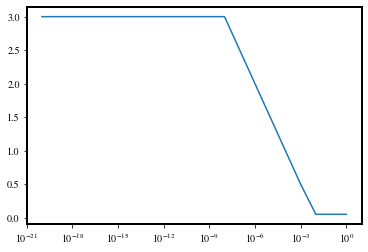

In [387]:
plt.plot(x,y)
plt.xscale('log')
plt.show()

In [388]:
# try to fit this data:
from scipy.optimize import curve_fit
# from numpy import *

# write the inverse function:
def f(x, A, B, C):
    return C*(1/(x+A)) + 0.05

# now fir the data
popt, pcov = curve_fit(f, x, y)


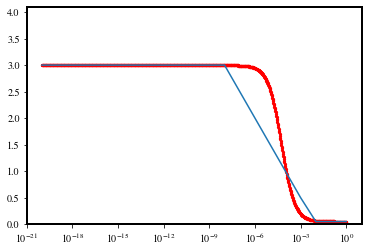

In [389]:
x2 = np.logspace(-20,0,1000)
plt.plot(x,y)
plt.scatter(x2, f(x2, popt[0], popt[1], popt[2]), s=5, color='red')
plt.xscale('log')
# plt.yscale('lin')
plt.ylim(0,4.1)
plt.show()

In [390]:
f(1e-5, popt[0], popt[1], popt[2])

2.5246569769684593

In [391]:
popt # this seems appropriate...

array([5.24002529e-05, 1.00000000e+00, 1.54419221e-04])

In [211]:
f(x, popt[0])

TypeError: f() missing 2 required positional arguments: 'B' and 'C'

In [259]:
a = np.full(10001,99)
a2 = a[0:100]
b = np.zeros(len(a))

In [261]:
aa = a2.reshape(len(a2), 1)

In [269]:
aaa = aa[:,0]
b[0:100] = aaa

In [296]:
df = pd.DataFrame({'A':[1,2,3,4,5,6,7,8,9,10,11,12]})
b = np.zeros(len(df))

In [304]:
df = pd.DataFrame({'A':[1,2,3,4,5,6,7,8,9,10,11,12]})
b = np.zeros(len(df))
for j in range((len(df)//5)+1):
    print('~~~~~~~~~~~~~~~~~~~~~')
    print(j, j*5, (1+j)*5)
    data = df.loc[j*5:(1+j)*5, 'A']
    b[j*5:(1+j)*5 + 1] = data
    print(b)

~~~~~~~~~~~~~~~~~~~~~
0 0 5
[1. 2. 3. 4. 5. 6. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~~~~~~~~~~~
1 5 10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.  0.]
~~~~~~~~~~~~~~~~~~~~~
2 10 15
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


In [15]:
df = pd.DataFrame({'A':[2,1,3,4,5,33,7,6,9,10,11,12],
                  'B':[12,11,44,44,44,6,33,33,33,33,1,2],
                  'C':[11,22,33,44,55,66,77,88,99,100,111,222]})

In [16]:
# sorted_idx_df = pd.DataFrame(np.sort((df.loc[:,['A','B']]).values, axis=1), 
#                                         columns=(df.loc[:,['A','B']]).columns).drop_duplicates()
df['name'] = (df['A'].astype(int)).astype(str)+'-'+(df['B'].astype(int)).astype(str)
df['inv_name'] = (df['B'].astype(int)).astype(str)+'-'+(df['A'].astype(int)).astype(str)

In [17]:
df

,A,B,C,name,inv_name
0,2,12,11,2-12,12-2
1,1,11,22,1-11,11-1
2,3,44,33,3-44,44-3
3,4,44,44,4-44,44-4
4,5,44,55,5-44,44-5
5,33,6,66,33-6,6-33
6,7,33,77,7-33,33-7
7,6,33,88,6-33,33-6
8,9,33,99,9-33,33-9
9,10,33,100,10-33,33-10


In [18]:
df2 = df.loc[ df['name'].isin(df['inv_name']) == False ].reset_index(drop=True)
df3 = pd.DataFrame(np.sort((df.loc[:,['A','B']]).values, axis=1), 
                                    columns=(df.loc[:,['A','B']]).columns).drop_duplicates() # chooooose the lower index first...
df3['name'] = (df3['A'].astype(int)).astype(str)+'-'+(df3['B'].astype(int)).astype(str)

In [7]:
df4 = df.loc[ df['name'].isin(df3['name'])==True ].reset_index(drop=True)

In [8]:
### need to think of a better way to sort duplicate columns bc it will make the first column value the lower one.....
### potentially a huge issue in the body of the code
df['flag'] = [0]*len(df)
df
# df.loc[ df['name'].isin(df['inv_name']) == True ]

,A,B,C,name,inv_name,flag
0,2,12,11,2-12,12-2,0
1,1,11,22,1-11,11-1,0
2,3,44,33,3-44,44-3,0
3,4,44,44,4-44,44-4,0
4,5,44,55,5-44,44-5,0
5,33,6,66,33-6,6-33,0
6,7,33,77,7-33,33-7,0
7,6,33,88,6-33,33-6,0
8,9,33,99,9-33,33-9,0
9,10,33,100,10-33,33-10,0


In [9]:
# come up with a method where the IDs dont flip...
# np.sort((df.loc[:,['A','B']]).values, axis=1), 
sort_idx = np.argsort((df.loc[:,['A','B']]).values, axis=1)
arr = np.array(df.loc[:, ['A', 'B']].values)
arr_ysort = np.take_along_axis(arr, sort_idx, axis=1)
# unique at axis 0 to get rid of duplicates
uniq_arr, uniq_idx = np.unique(arr_ysort, return_index=True, return_inverse=False, axis=0)
# return the unique pairing
uniq_p = arr[np.sort(uniq_idx)]


# unsort_y_idx = sort_idx[uniq_idx]
# # unshuffel in axis=1 direction to return to original order
# final_arry = np.take_along_axis(uniq_arr, unsort_y_idx, axis=1)
# # unshuffle in axis=1 direction
# # final step is to return this to a df and match back... preserve the original order.......


In [10]:
uniq_p

# what are uniq_idx new idxs in the new df

array([[ 2, 12],
       [ 1, 11],
       [ 3, 44],
       [ 4, 44],
       [ 5, 44],
       [33,  6],
       [ 7, 33],
       [ 9, 33],
       [10, 33]])

In [10]:
# df3 = pd.DataFrame(np.sort((df.loc[:,['A','B']]).values, axis=1), 
#                                     columns=(df.loc[:,['A','B']]).columns).drop_duplicates()
a=np.sort((df.loc[:,['A','B']]).values, axis=1)
                                    # columns=(df.loc[:,['A','B']]).columns).drop_duplicates()
b=pd.DataFrame(a, columns=(df.loc[:,['A','B']]).columns).drop_duplicates()

In [12]:
b

,A,B
0,2,12
1,1,11
2,3,44
3,4,44
4,5,44
5,6,33
6,7,33
8,9,33
9,10,33


In [95]:
uniq_arr, uniq_idx = np.unique(arr_ysort, return_index=True, axis=0)

In [97]:
arr_ysort[uniq_idx]

array([[ 1, 11],
       [ 2, 12],
       [ 3, 44],
       [ 4, 44],
       [ 5, 44],
       [ 6, 33],
       [ 7, 33],
       [ 9, 33],
       [10, 33]])

In [102]:
unsort_y_idx = sort_idx[uniq_idx]
# finally unsort in y
np.take_along_axis(uniq_arr, unsort_y_idx, axis=1)

array([[ 1, 11],
       [ 2, 12],
       [ 3, 44],
       [ 4, 44],
       [ 5, 44],
       [33,  6],
       [ 7, 33],
       [ 9, 33],
       [10, 33]])

In [19]:
df

,A,B,C,name,inv_name
0,2,12,11,2-12,12-2
1,1,11,22,1-11,11-1
2,3,44,33,3-44,44-3
3,4,44,44,4-44,44-4
4,5,44,55,5-44,44-5
5,33,6,66,33-6,6-33
6,7,33,77,7-33,33-7
7,6,33,88,6-33,33-6
8,9,33,99,9-33,33-9
9,10,33,100,10-33,33-10


In [20]:
df3

,A,B,name
0,2,12,2-12
1,1,11,1-11
2,3,44,3-44
3,4,44,4-44
4,5,44,5-44
5,6,33,6-33
6,7,33,7-33
8,9,33,9-33
9,10,33,10-33


In [5]:
df

,A,B,C,D
0,2,12,11,88
1,1,11,22,99
2,3,44,33,11
3,4,44,44,111
4,5,44,55,22
5,33,6,66,77
6,7,33,77,222
7,6,33,88,33
8,9,33,99,44
9,10,33,100,66


In [20]:
np.abs(np.log10(0.05/0.01))

0.6989700043360189

In [15]:
# start with 0.05
# then dS = dS + dS
dS= 0.05
dS = dS+0.05

In [22]:
# say you try selecting masses 10 times, then your log difference would be 
1-(1-0.13)*(1-0.219)*(1-0.062)

0.36265714000000004

In [22]:
with fits.open('/nobackup/c1029594/CANDELS_AGN_merger_data/COSMOS_data/COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits') as data:
    COSMOS = pd.DataFrame(data[1].data)

In [37]:
CD = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data3.csv')

/tmp/ipykernel_71612/1827400239.py:1: DtypeWarning: Columns (25,34) have mixed types. Specify dtype option on import or set low_memory=False.
  CD = pd.read_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data3.csv')


In [26]:
CD['ID_CHANDRA'] = COSMOS['ID_CHANDRA']

In [38]:
 # CD.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data333.csv', index=False)

In [41]:
CD2 = CD.fillna(-99)

In [43]:
CD2.to_csv('/nobackup/c1029594/CANDELS_AGN_merger_data/CANDELS_COSMOS_CATS/COSMOS_data3.csv', index=False)